<a href="https://colab.research.google.com/github/ajkourabi/RGB-Mixer-ASIC/blob/main/openlane_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## RGB Mixer Chip

This notebook showcases my work in developing a chip from Verilog. I use OpenLane, which is an open source RTL to ASIC automated workflow tool.

You can see my project's github [here](https://github.com/ajkourabi/learning_verilog/tree/main).

I set this Colab up such that you can make a chip by inserting synthesizable Verilog code into the "Creating the design" section.

I also try to annotate each step throughout the process such that it is clear what is being done and the purpose of each step. This colab is based off the OpenLane template colab, which can be found on their [github](https://github.com/efabless/openlane2).

In [1]:
%%capture
# @title Setup Nix.
import os
import sys
import shutil

os.environ["LOCALE_ARCHIVE"] = "/usr/lib/locale/locale-archive"

if "google.colab" in sys.modules:
    if shutil.which("nix-env") is None:
        !curl -L https://nixos.org/nix/install | bash -s -- --daemon --yes
        !echo "extra-experimental-features = nix-command flakes" >> /etc/nix/nix.conf
        !killall nix-daemon
else:
    if shutil.which("nix-env") is None:
        raise RuntimeError("Nix is not installed!")

os.environ["PATH"] = f"/nix/var/nix/profiles/default/bin/:{os.getenv('PATH')}"

In [50]:
%%capture
# @title Get OpenLane {display-mode: "form"}
# @markdown Click the ▷ button to download and install OpenLane.
# @markdown
# @markdown This will install OpenLane's tool dependencies using Nix,
# @markdown and OpenLane itself using PIP.
# @markdown
# @markdown Note that `python3-tk` may need to be installed using your OS's
# @markdown package manager.
import os
import subprocess
import IPython

openlane_version = "version-2.1"  # @param {key:"OpenLane Version", type:"string"}

if openlane_version == "latest":
    openlane_version = "main"

pdk_root = "~/.volare"  # @param {key:"PDK Root", type:"string"}

pdk_root = os.path.expanduser(pdk_root)

pdk = "sky130"  # @param {key:"PDK (without the variant)", type:"string"}

openlane_ipynb_path = os.path.join(os.getcwd(), "openlane_ipynb")

display(IPython.display.HTML("<h3>Downloading OpenLane…</a>"))


TESTING_LOCALLY = False
!rm -rf {openlane_ipynb_path}
!mkdir -p {openlane_ipynb_path}
if TESTING_LOCALLY:
    !ln -s {os.getcwd()} {openlane_ipynb_path}
else:
    !curl -L "https://github.com/efabless/openlane2/tarball/{openlane_version}" | tar -xzC {openlane_ipynb_path} --strip-components 1

try:
    import tkinter
except ImportError:
    if "google.colab" in sys.modules:
        !sudo apt-get install python-tk

try:
    import tkinter
except ImportError as e:
    display(
        IPython.display.HTML(
            '<h3 style="color: #800020";>❌ Failed to import the <code>tkinter</code> library for Python, which is required to load PDK configuration values. Make sure <code>python3-tk</code> or equivalent is installed on your system.</a>'
        )
    )
    raise e from None


display(IPython.display.HTML("<h3>Downloading OpenLane's dependencies…</a>"))
try:
    subprocess.check_call(
        ["nix", "profile", "install", ".#colab-env", "--accept-flake-config"],
        cwd=openlane_ipynb_path,
    )
except subprocess.CalledProcessError as e:
    display(
        IPython.display.HTML(
            '<h3 style="color: #800020";>❌ Failed to install binary dependencies using Nix…</h3>'
        )
    )

display(IPython.display.HTML("<h3>Downloading Python dependencies using PIP…</a>"))
try:
    subprocess.check_call(
        ["pip3", "install", "."],
        cwd=openlane_ipynb_path,
    )
except subprocess.CalledProcessError as e:
    display(
        IPython.display.HTML(
            '<h3 style="color: #800020";>❌ Failed to install Python dependencies using PIP…</h3>'
        )
    )
    raise e from None

display(IPython.display.HTML("<h3>Downloading PDK…</a>"))
import volare

volare.enable(
    volare.get_volare_home(pdk_root),
    pdk,
    open(
        os.path.join(openlane_ipynb_path, "openlane", "open_pdks_rev"),
        encoding="utf8",
    )
    .read()
    .strip(),
)

sys.path.insert(0, openlane_ipynb_path)
display(IPython.display.HTML("<h3>⭕️ Done.</a>"))

import logging

logging.getLogger().handlers.clear()

def display_metrics(module_name):
    # Dynamically access the module's state_out
    output_state = globals()[module_name].state_out

    print(f"\nAll available metrics for {module_name}:")
    for key, value in output_state.metrics.items():
        print(f"{key}: {value}")

In [3]:
import openlane

print(openlane.__version__)

2.1.11


### Creating the design

Create a design using Verilog. This is where the Verilog code is added. This describes the basic functionality that we want on a chip.

In [4]:
%%writefile rgb_led_driver.v
module rgb_led_driver(
    input clk, rst,
    input blue_A, blue_B, red_A, red_B, green_A, green_B,
    output pwm_red, pwm_green, pwm_blue
);


    wire [7:0] red_counter;
    wire [7:0] green_counter;
    wire [7:0] blue_counter;

    rotary_encoder encoder_red (
        .clk(clk),
        .rst(rst),
        .A(red_A),
        .B(red_B),
        .count(red_counter)
    );

    pwm_driver driver_red (
        .clk(clk),
        .rst(rst),
        .duty_cycle(red_counter),
        .pwm_out(pwm_red)
    );

    rotary_encoder encoder_green (
        .clk(clk),
        .rst(rst),
        .A(green_A),
        .B(green_B),
        .count(green_counter)
    );

    pwm_driver driver_green (
        .clk(clk),
        .rst(rst),
        .duty_cycle(green_counter),
        .pwm_out(pwm_green)
    );

    rotary_encoder encoder_blue (
        .clk(clk),
        .rst(rst),
        .A(blue_A),
        .B(blue_B),
        .count(blue_counter)
    );

    pwm_driver driver_blue (
        .clk(clk),
        .rst(rst),
        .duty_cycle(blue_counter),
        .pwm_out(pwm_blue)
    );

endmodule

module pwm_driver(
input wire clk,
input wire rst,
input wire [7:0] duty_cycle,
output reg pwm_out
);
reg [7:0] cycle;
reg [7:0] counter;


// Calculate cycle value
always @(duty_cycle) begin
    cycle = (duty_cycle * 50) / 255; // Approximation of duty_cycle / 5.1
end

always @(posedge clk or posedge rst) begin
    if (rst) begin
        pwm_out <= 1'b0;
        counter <= 8'b0;
    end
    else begin
        if (counter < 8'd50)
            counter <= counter + 8'd1;
        else
            counter <= 8'd0;

        pwm_out <= (counter < cycle) ? 1'b1 : 1'b0;
    end
end
endmodule

module rotary_encoder(

    input clk, rst,
    input A, B,
    output reg [7:0] count

);
    reg Aprev, Bprev;

    always @( posedge clk or posedge rst ) begin : encoder

    if (rst) begin
        Aprev <= 1'b0;
        Bprev <= 1'b0;
        count <= 8'b0;
    end else begin
        Aprev <= A;
        Bprev <= B;
        if (A && !Aprev) begin
            if (!B) begin
                count <= count + 1; //clockwise
            end
            else
                count <= count -1; //anti clockwise
        end
        if (B && !Bprev) begin
            if (A) begin
                count <= count + 1; //clockwise
            end
            else
                count  <= count - 1; //anti clockwise
        end
    end
    end
endmodule

Writing rgb_led_driver.v


In [51]:
%%capture
#setting up the config of the flow
from openlane.config import Config

Config.interactive(
    "rgb_led_driver",
    PDK="sky130A",
    CLOCK_PORT="clk",
    CLOCK_NET="clk",
    CLOCK_PERIOD=10,
    PRIMARY_GDSII_STREAMOUT_TOOL="klayout",
)

# Starting Chip Design Flow

## Synthesis

In [6]:
from openlane.steps import Step
Synthesis = Step.factory.get("Yosys.Synthesis")


Synthesis is the first step in the process and essentially takes the Verilog code and maps the logic onto the standard cells of the PDK. The output is a gate-level netlist, which describes the design using actual logic gates (and thus, transistors). In here, we simply pass the verilog files and OpenLane (through Yosys) takes care of synthesis.

In [52]:
%%capture
from openlane.state import State

synthesis = Synthesis(
    VERILOG_FILES=["./rgb_led_driver.v"],
    state_in=State(),
)
synthesis.start()

In [8]:
display(synthesis)

#### Time Elapsed: 40.40s
#### Views updated:
* Verilog Netlist


In [9]:
#displaying metrics
display_metrics("synthesis")


All available metrics for synthesis:
design__instance__count: 731
design__instance__area: 7368.316800
design__instance_unmapped__count: 0
synthesis__check_error__count: 0


### Floorplanning

Floorplanning does two things:

* Determines the dimensions of the final chip.
* Creates the "cell placement grid" which placed cells must be aligned to.
    * Each cell in the grid is called a "site." Cells can occupy multiple
      sites, with the overwhelming majority of cells occupying multiple sites
      by width, and some standard cell libraries supporting varying heights as well.

Part of the floor is also dedicated to routing, which takes up around 20-30% of the area. One metric the floorplan optimises for is the wire length, which is how far a signal has to travel between connected cells.


In [10]:
%%capture
Floorplan = Step.factory.get("OpenROAD.Floorplan")

floorplan = Floorplan(state_in=synthesis.state_out)
floorplan.start()

In [11]:
#displaying metrics
display_metrics("floorplan")


All available metrics for floorplan:
design__instance__count: 731
design__instance__area: 7368.316800
design__instance_unmapped__count: 0
synthesis__check_error__count: 0
design__die__bbox: 0.0 0.0 132.435 143.155
design__core__bbox: 5.52 10.88 126.5 130.56
flow__warnings__count: 2
flow__errors__count: 0


──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[00:36:44] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=187436;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=639511;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[00:36:44] VERBOSE  Logging subprocess to ]8;id=34254;file:///tmp/openlane_klayout_tmp_r2wm6ce0/klayout-render.log\..]8;;\]8;id=69791;file:///tmp/openlane_klayout_tmp_r2wm6ce0/klayout-render.log\/tmp/openlane_klayout_tmp_r2wm6ce0/]8;;\]8;id=160812;file:///tmp/openlane_klayout_tmp_r2wm6ce0/klayout-render.log\klayout-render.log]8;;\…     ]8;id=501994;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=462095;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

#### Time Elapsed: 2.54s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
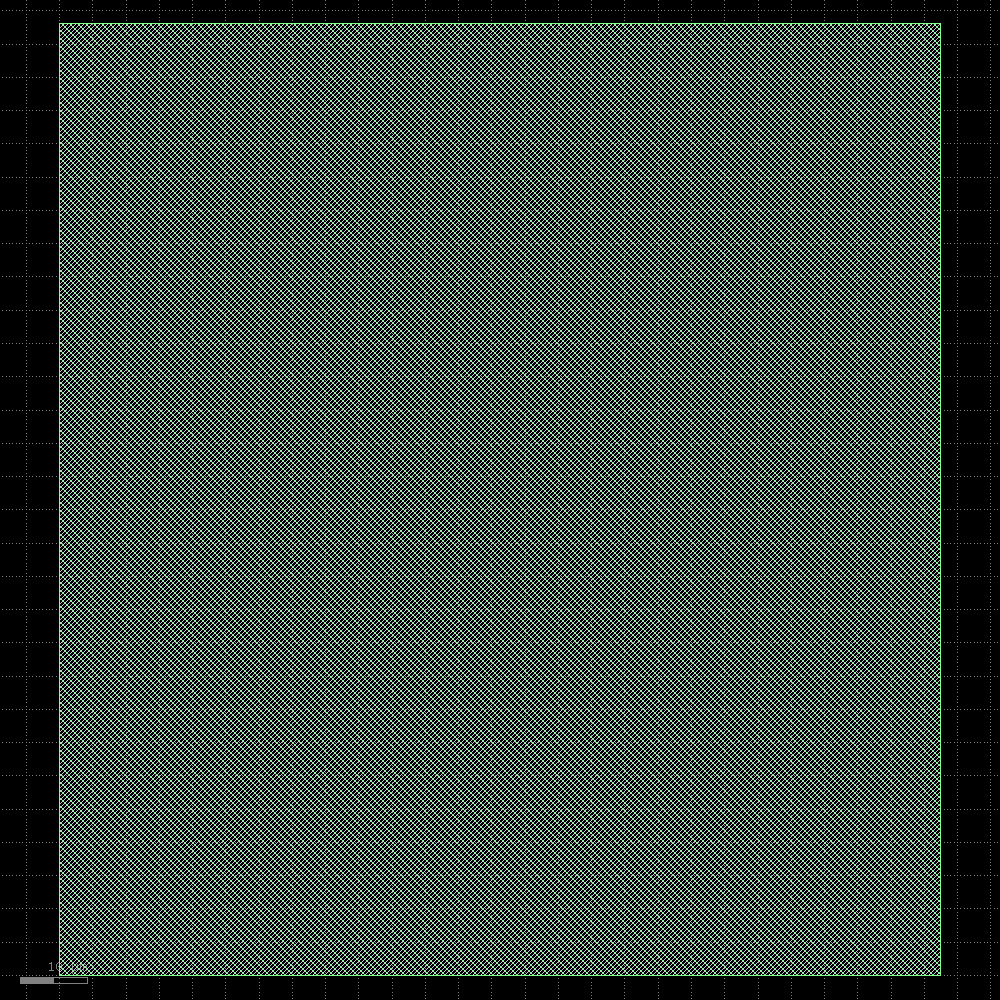

In [12]:
display(floorplan)

### Tap/Endcap Cell Insertion

This places two kinds of cells on the floorplan:

* End caps: these are added at the start and end of each row. These caps ensure proper termination or power connections.

* Tap cells: These connect power supply rails to the wells where the transistors are fabricated. They also help with preventing errors like "latch up" where a short forms with the power rail (thus always remaining at low)


There is a maximum distance between tap cells enforced as part of every   foundry process. Compliance is checked at the Design Rule Checking (DRC) stage.

In [13]:
%%capture
TapEndcapInsertion = Step.factory.get("OpenROAD.TapEndcapInsertion")

tdi = TapEndcapInsertion(state_in=floorplan.state_out)
tdi.start()

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[00:36:46] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=122788;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=5826;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[00:36:46] VERBOSE  Logging subprocess to ]8;id=789713;file:///tmp/openlane_klayout_tmp_xz_gfx0a/klayout-render.log\..]8;;\]8;id=793821;file:///tmp/openlane_klayout_tmp_xz_gfx0a/klayout-render.log\/tmp/openlane_klayout_tmp_xz_gfx0a/]8;;\]8;id=832721;file:///tmp/openlane_klayout_tmp_xz_gfx0a/klayout-render.log\klayout-render.log]8;;\…     ]8;id=632847;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=813452;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

#### Time Elapsed: 1.22s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
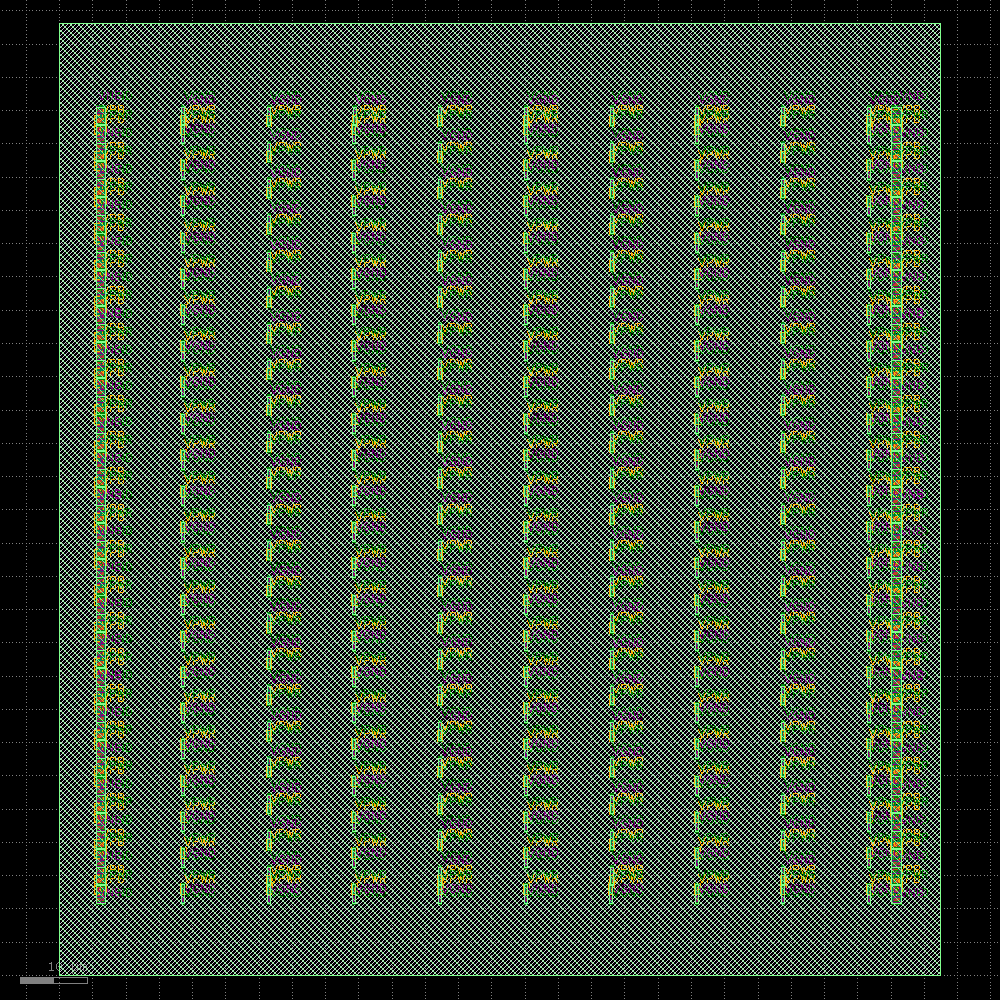

In [14]:
display(tdi)

In [15]:
#displaying metrics
display_metrics("tdi")


All available metrics for tdi:
design__instance__count: 938
design__instance__area: 7627.32
design__instance_unmapped__count: 0
synthesis__check_error__count: 0
design__die__bbox: 0.0 0.0 132.435 143.155
design__core__bbox: 5.52 10.88 126.5 130.56
flow__warnings__count: 0
flow__errors__count: 0
design__io: 11
design__die__area: 18958.7
design__core__area: 14478.9
design__instance__count__stdcell: 938
design__instance__area__stdcell: 7627.32
design__instance__count__macros: 0
design__instance__area__macros: 0
design__instance__utilization: 0.526789
design__instance__utilization__stdcell: 0.526789


### I/O Placement

This places the input and output pins at the periphery of the chip. The ports defined in verilog will get a physical location that connects directly to the chip. This can be crucial as it impacts the timing and overall placement.

In [16]:
%%capture
IOPlacement = Step.factory.get("OpenROAD.IOPlacement")

ioplace = IOPlacement(state_in=tdi.state_out)
ioplace.start()

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[00:36:48] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=538862;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=410229;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[00:36:48] VERBOSE  Logging subprocess to ]8;id=769531;file:///tmp/openlane_klayout_tmp__e5ug82i/klayout-render.log\..]8;;\]8;id=458859;file:///tmp/openlane_klayout_tmp__e5ug82i/klayout-render.log\/tmp/openlane_klayout_tmp__e5ug82i/]8;;\]8;id=743914;file:///tmp/openlane_klayout_tmp__e5ug82i/klayout-render.log\klayout-render.log]8;;\…     ]8;id=11637;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=548209;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

#### Time Elapsed: 1.23s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
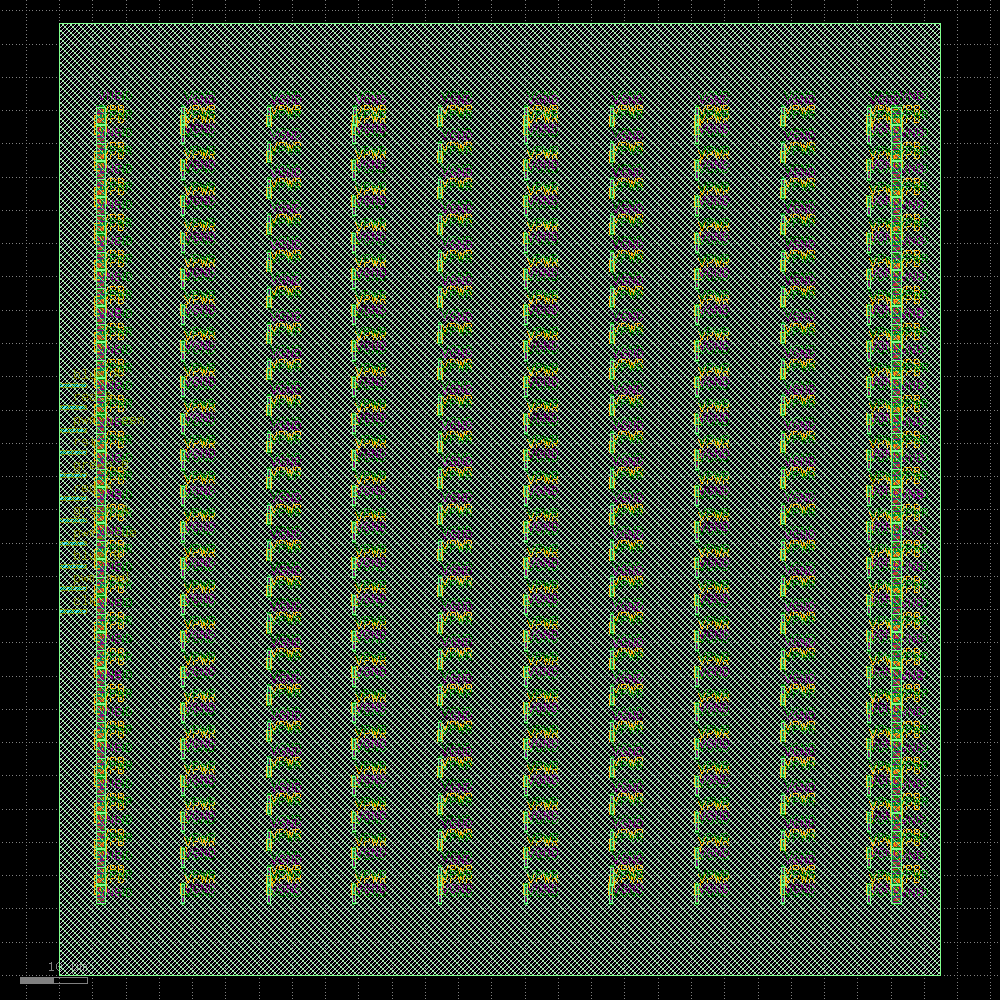

In [17]:
display(ioplace)

In [18]:
#displaying metrics
display_metrics("ioplace")


All available metrics for ioplace:
design__instance__count: 938
design__instance__area: 7627.32
design__instance_unmapped__count: 0
synthesis__check_error__count: 0
design__die__bbox: 0.0 0.0 132.435 143.155
design__core__bbox: 5.52 10.88 126.5 130.56
flow__warnings__count: 0
flow__errors__count: 0
design__io: 11
design__die__area: 18958.7
design__core__area: 14478.9
design__instance__count__stdcell: 938
design__instance__area__stdcell: 7627.32
design__instance__count__macros: 0
design__instance__area__macros: 0
design__instance__utilization: 0.526789
design__instance__utilization__stdcell: 0.526789
floorplan__design__io: 11
design__io__hpwl: 830550


### Generating the Power Distribution Network (PDN)


This creates power rails that are distributed across the chip. Generally this is a set of rows or columns that aim to evenly distribute power throughout the chip, through connecting via tap cells. It is critical to eliminate voltage drops across the PDN as much as possible to ensure even distribution. Excess metal wires may cause unwanted capacitance, but too much power laid out may increase overall consumption. Tradeoffs tradeoffs tradeoffs.


In [19]:
%%capture
GeneratePDN = Step.factory.get("OpenROAD.GeneratePDN")

pdn = GeneratePDN(
    state_in=ioplace.state_out,
    FP_PDN_RING = True,
    FP_PDN_VWIDTH=2,
    FP_PDN_HWIDTH=2,
    FP_PDN_VPITCH=30,
    FP_PDN_HPITCH=30,
)
pdn.start()

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[00:36:51] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=503654;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=978758;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[00:36:51] VERBOSE  Logging subprocess to ]8;id=34091;file:///tmp/openlane_klayout_tmp_22h9rrv3/klayout-render.log\..]8;;\]8;id=207831;file:///tmp/openlane_klayout_tmp_22h9rrv3/klayout-render.log\/tmp/openlane_klayout_tmp_22h9rrv3/]8;;\]8;id=744116;file:///tmp/openlane_klayout_tmp_22h9rrv3/klayout-render.log\klayout-render.log]8;;\…     ]8;id=280827;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=484233;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

#### Time Elapsed: 1.34s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
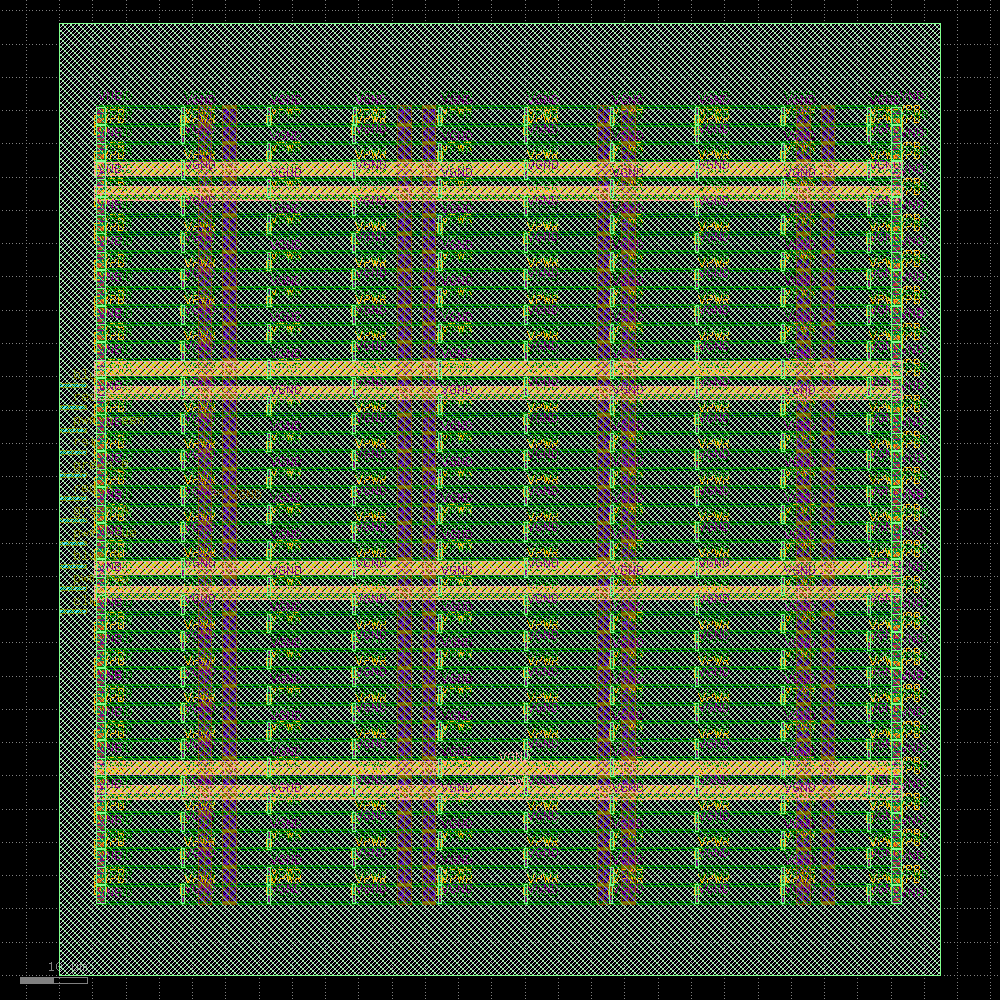

In [20]:
display(pdn)

In [21]:
#displaying metrics
display_metrics("pdn")


All available metrics for pdn:
design__instance__count: 938
design__instance__area: 7627.32
design__instance_unmapped__count: 0
synthesis__check_error__count: 0
design__die__bbox: 0.0 0.0 132.435 143.155
design__core__bbox: 5.52 10.88 126.5 130.56
flow__warnings__count: 0
flow__errors__count: 0
design__io: 13
design__die__area: 18958.7
design__core__area: 14478.9
design__instance__count__stdcell: 938
design__instance__area__stdcell: 7627.32
design__instance__count__macros: 0
design__instance__area__macros: 0
design__instance__utilization: 0.526789
design__instance__utilization__stdcell: 0.526789
floorplan__design__io: 11
design__io__hpwl: 830550
design__power_grid_violation__count__net:VGND: 0
design__power_grid_violation__count__net:VPWR: 0
design__power_grid_violation__count: 0


### Global Placement

This is the rough sketch of where the standard cells will go. Most of the cells placed here are actually illegal (e.g. there is lots overlap between them). The goal here is to get a good guess on where things will go. One consideration here is the wire length minimization.

In [22]:
%%capture
GlobalPlacement = Step.factory.get("OpenROAD.GlobalPlacement")

gpl = GlobalPlacement(state_in=pdn.state_out)
gpl.start()

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[00:36:58] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=560925;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=438850;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[00:36:58] VERBOSE  Logging subprocess to ]8;id=982193;file:///tmp/openlane_klayout_tmp_8hegap1a/klayout-render.log\..]8;;\]8;id=452517;file:///tmp/openlane_klayout_tmp_8hegap1a/klayout-render.log\/tmp/openlane_klayout_tmp_8hegap1a/]8;;\]8;id=737181;file:///tmp/openlane_klayout_tmp_8hegap1a/klayout-render.log\klayout-render.log]8;;\…     ]8;id=355141;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=579793;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

#### Time Elapsed: 6.04s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
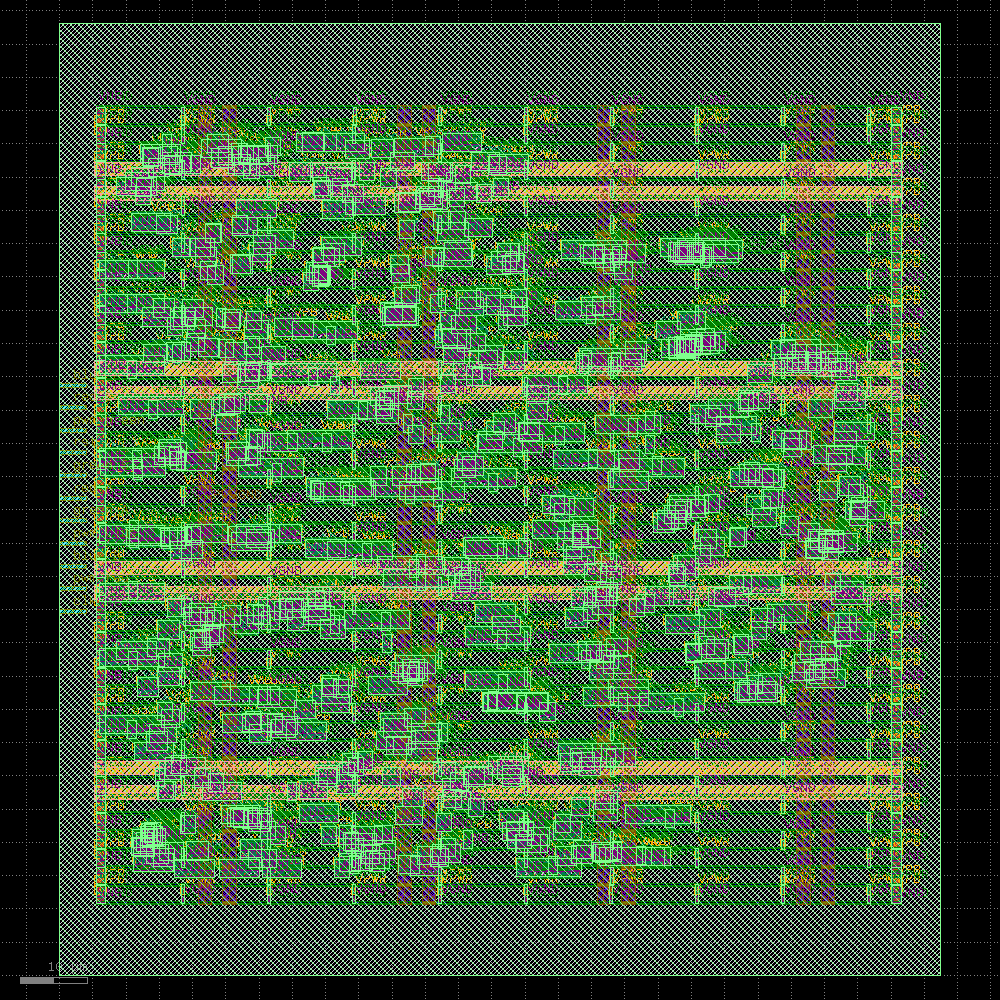

In [23]:
display(gpl)

This step is an optimisation step that fine tunes the original placement, adding buffers where it expects timing issues to occur.

In [53]:
%%capture
TimingOptimization = Step.factory.get("OpenROAD.RepairDesignPostGPL")

timing_opt = TimingOptimization(state_in=gpl.state_out)
timing_opt.start()

### Detailed Placement

This aligns the fuzzy placement from before with the grid, "legalizing" it.

In [54]:
%%capture
DetailedPlacement = Step.factory.get("OpenROAD.DetailedPlacement")

dpl = DetailedPlacement(state_in=timing_opt.state_out)
dpl.start()

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[00:37:06] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=6856;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=354740;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[00:37:06] VERBOSE  Logging subprocess to ]8;id=898435;file:///tmp/openlane_klayout_tmp_osgoz0uo/klayout-render.log\..]8;;\]8;id=336132;file:///tmp/openlane_klayout_tmp_osgoz0uo/klayout-render.log\/tmp/openlane_klayout_tmp_osgoz0uo/]8;;\]8;id=655926;file:///tmp/openlane_klayout_tmp_osgoz0uo/klayout-render.log\klayout-render.log]8;;\…     ]8;id=447587;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=779371;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

#### Time Elapsed: 1.42s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
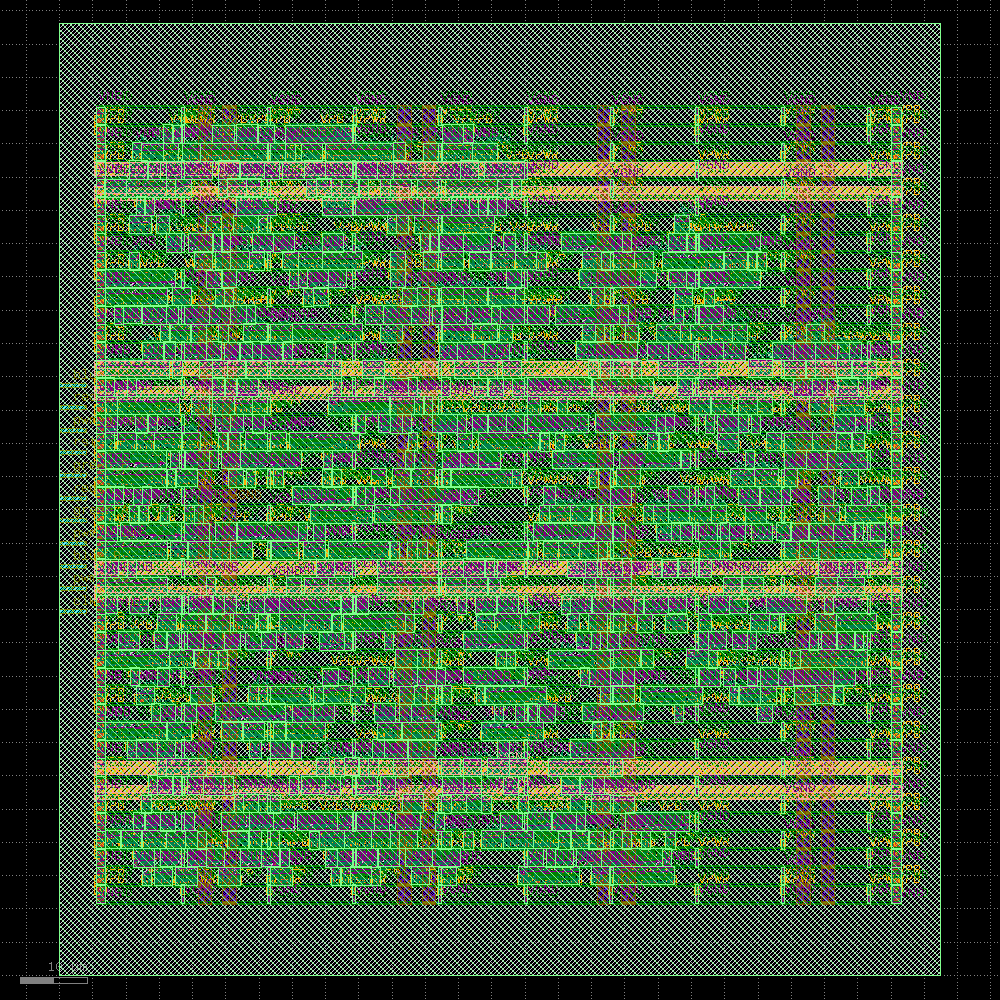

In [26]:
display(dpl)

In [27]:
display_metrics("dpl")


All available metrics for dpl:
design__instance__count: 977
design__instance__area: 6633.86
design__instance_unmapped__count: 0
synthesis__check_error__count: 0
design__die__bbox: 0.0 0.0 132.435 143.155
design__core__bbox: 5.52 10.88 126.5 130.56
flow__warnings__count: 0
flow__errors__count: 0
design__io: 13
design__die__area: 18958.7
design__core__area: 14478.9
design__instance__count__stdcell: 977
design__instance__area__stdcell: 6633.86
design__instance__count__macros: 0
design__instance__area__macros: 0
design__instance__utilization: 0.458175
design__instance__utilization__stdcell: 0.458175
floorplan__design__io: 11
design__io__hpwl: 830550
design__power_grid_violation__count__net:VGND: 0
design__power_grid_violation__count__net:VPWR: 0
design__power_grid_violation__count: 0
timing__drv__floating__nets: 0
timing__drv__floating__pins: 0
design__instance__displacement__total: 0
design__instance__displacement__mean: 0
design__instance__displacement__max: 0
route__wirelength__estimat

### Clock Tree Synthesis (CTS)


Given we have a final placement done, it is time to generate a clock tree. This tree is comprised of a set of buffers used for clock signals, aiming to minimize "clock skew". Clock skew refers to the delay of the clock cycle from one register to another. It can be cause by wire length differences, for example. Timing violations prevent effective functioning of the chip. It is called a tree because the general architecture for how the clock signal is distributed looks something like what is below.
Practically, these buffers are added between cells.
 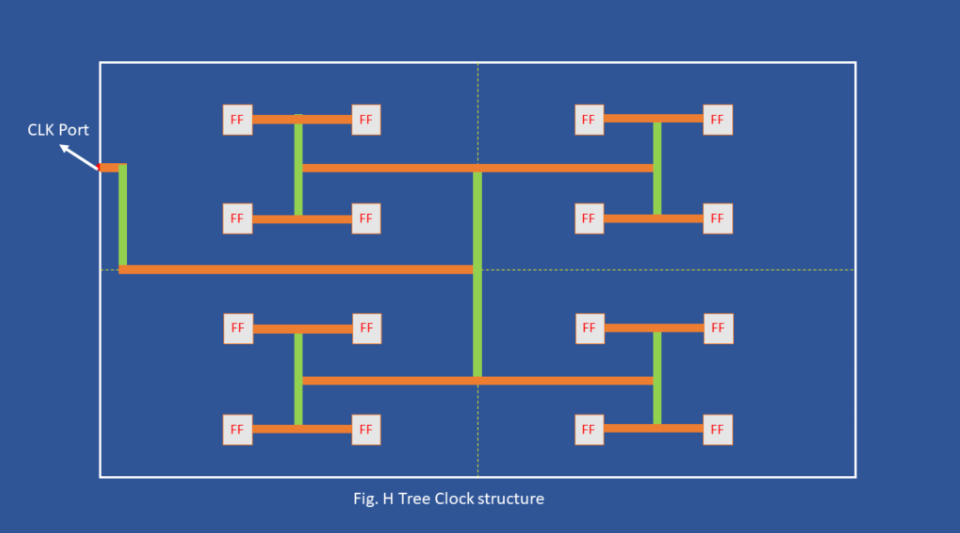



In [28]:
%%capture
CTS = Step.factory.get("OpenROAD.CTS")

cts = CTS(state_in=dpl.state_out)
cts.start()

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[00:37:23] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=995575;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=437715;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[00:37:23] VERBOSE  Logging subprocess to ]8;id=85406;file:///tmp/openlane_klayout_tmp_3288yfbb/klayout-render.log\..]8;;\]8;id=750960;file:///tmp/openlane_klayout_tmp_3288yfbb/klayout-render.log\/tmp/openlane_klayout_tmp_3288yfbb/]8;;\]8;id=343993;file:///tmp/openlane_klayout_tmp_3288yfbb/klayout-render.log\klayout-render.log]8;;\…     ]8;id=493252;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=240677;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

#### Time Elapsed: 15.34s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
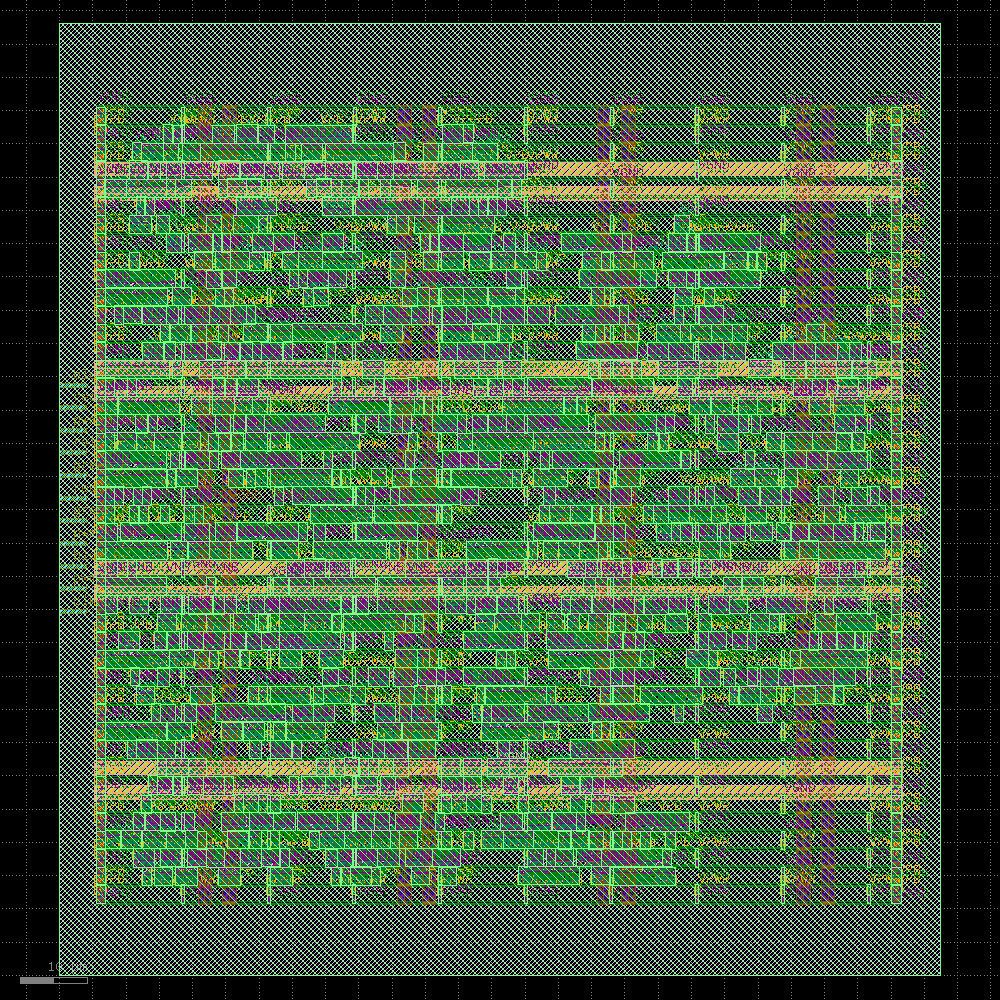

In [29]:
display(cts)

In [30]:
display_metrics("cts")


All available metrics for cts:
design__instance__count: 993
design__instance__area: 6945.41
design__instance_unmapped__count: 0
synthesis__check_error__count: 0
design__die__bbox: 0.0 0.0 132.435 143.155
design__core__bbox: 5.52 10.88 126.5 130.56
flow__warnings__count: 33696
flow__errors__count: 0
design__io: 13
design__die__area: 18958.7
design__core__area: 14478.9
design__instance__count__stdcell: 993
design__instance__area__stdcell: 6945.41
design__instance__count__macros: 0
design__instance__area__macros: 0
design__instance__utilization: 0.479692
design__instance__utilization__stdcell: 0.479692
floorplan__design__io: 11
design__io__hpwl: 830550
design__power_grid_violation__count__net:VGND: 0
design__power_grid_violation__count__net:VPWR: 0
design__power_grid_violation__count: 0
timing__drv__floating__nets: 0
timing__drv__floating__pins: 0
design__instance__displacement__total: 154.964
design__instance__displacement__mean: 0.143
design__instance__displacement__max: 6.86
route__wi

### Global Routing

Similar to global placement, this step plans the approximate route between the standard cells. There are many considerations here like wire length, routing density, timing constraints for critical paths, etc.

This just formulates a dataset that provides a routing guide, and as you might guess, the detailed routing stage is what adds routes between cells on the desing.


In [31]:
%%capture
GlobalRouting = Step.factory.get("OpenROAD.GlobalRouting")

grt = GlobalRouting(state_in=cts.state_out)
grt.start()

In [32]:
display_metrics("grt")


All available metrics for grt:
design__instance__count: 993
design__instance__area: 6945.41
design__instance_unmapped__count: 0
synthesis__check_error__count: 0
design__die__bbox: 0.0 0.0 132.435 143.155
design__core__bbox: 5.52 10.88 126.5 130.56
flow__warnings__count: 0
flow__errors__count: 0
design__io: 13
design__die__area: 18958.7
design__core__area: 14478.9
design__instance__count__stdcell: 993
design__instance__area__stdcell: 6945.41
design__instance__count__macros: 0
design__instance__area__macros: 0
design__instance__utilization: 0.479692
design__instance__utilization__stdcell: 0.479692
floorplan__design__io: 11
design__io__hpwl: 830550
design__power_grid_violation__count__net:VGND: 0
design__power_grid_violation__count__net:VPWR: 0
design__power_grid_violation__count: 0
timing__drv__floating__nets: 0
timing__drv__floating__pins: 0
design__instance__displacement__total: 154.964
design__instance__displacement__mean: 0.143
design__instance__displacement__max: 6.86
route__wirele

In [55]:
%%capture
from openlane.steps import Step

RepairDesignPostGRT = Step.factory.get("OpenROAD.RepairDesignPostGRT")

repair = RepairDesignPostGRT(state_in=grt.state_out)
repair.start()

### Detailed Routing

This step places down metal wires connecting different cells based on the guidlines of the global routing data set. This could involve many different layers of metal connecting different parts of the standard cells together. This often happens across three dimensions.

There could be many metal layers (generally more than 10). Lower layers are used for local connections, while upper layers are used for power distribuition. Vias are generally used to connect different layers.

Congestions is generally discouraged though in some instances unavoidable. Detailed routing is the most time consuming and hardest part of the process. Recent AI chips contain more than 200 billion transistors which need to be connected, which is very hard to do optimally!

Detailed routing is NP-hard, which means there is no known polynomial-time algorithm to solve it optimally, so a set of heuristics guide the process.

Google and Nvidia both use RL agents to aid in this step.

This step takes the longest.

In [57]:

DetailedRouting = Step.factory.get("OpenROAD.DetailedRouting")

drt = DetailedRouting(state_in=repair.state_out)
drt.start()

──────────────────────────────────────────────── Detailed Routing ─────────────────────────────────────────────────

[01:07:53] VERBOSE  Running 'OpenROAD.DetailedRouting'…                                                ]8;id=135180;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=361275;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[01:07:53] INFO     Running TritonRoute with 2 threads…                                            ]8;id=363621;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=389547;file:///content/openlane_ipynb/openlane/steps/openroad.py#1619\1619]8;;\

[01:07:53] VERBOSE  Logging subprocess to                                                              ]8;id=500284;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=226101;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=832835;file:///content/openlane_run/28-openroad-detailedrouting/openroad-detailedrouting.log\openlane_run/]8;;\]8;id=887756;file:///content/openlane_run/28-openroad-detailedrouting/openroad-detailedrouting.log\28]8;;\]8;id=832835;file:///content/openlane_run/28-openroad-detailedrouting/openroad-detailedrouting.log\-openroad-detailedrouting/openroad-detailedrouting.log]8;;\…                         

Reading OpenROAD database at '/content/openlane_run/26-openroad-repairdesignpostgrt/rgb_led_driver.odb'…

Reading library file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading design constraints file at '/content/openlane_ipynb/openlane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 2

[INFO] Setting input delay to: 2

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

[INFO ORD-0030] Using 2 thread(s).

[INFO DRT-0149] Reading tech and libs.

[01:07:54] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=267800;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=85029;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\
                    layer mcon                                                                                     

[01:07:54] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=759749;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=691914;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\
                    layer mcon                                                                                     

[01:07:54] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=100794;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=707063;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\
                    layer via                                                                                      

[01:07:54] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=462580;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=297822;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\
                    layer via                                                                                      

[01:07:54] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=713599;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=967522;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\
                    layer via2                                                                                     

[01:07:54] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=290136;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=384549;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\
                    layer via2                                                                                     

[01:07:54] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=945954;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=934709;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\
                    layer via3                                                                                     

[01:07:54] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=665880;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=843620;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\
                    layer via3                                                                                     

[01:07:54] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=803572;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=847298;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\
                    layer via4                                                                                     

[01:07:54] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=456936;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=113090;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\
                    layer via4                                                                                     

Units:                1000

Number of layers:     13

Number of macros:     441

Number of vias:       29

Number of viarulegen: 25

[INFO DRT-0150] Reading design.

Design:                   rgb_led_driver

Die area:                 ( 0 0 ) ( 132435 143155 )

Number of track patterns: 12

Number of DEF vias:       0

Number of components:     1081

Number of terminals:      13

Number of snets:          2

Number of nets:           787

[INFO DRT-0167] List of default vias:

Layer via

default via: M1M2_PR

Layer via2

default via: M2M3_PR

Layer via3

default via: M3M4_PR

Layer via4

default via: M4M5_PR

[INFO DRT-0162] Library cell analysis.

[INFO DRT-0163] Instance analysis.

[INFO DRT-0164] Number of unique instances = 228.

[INFO DRT-0168] Init region query.

[INFO DRT-0024]   Complete FR_MASTERSLICE.

[INFO DRT-0024]   Complete Fr_VIA.

[INFO DRT-0024]   Complete li1.

[INFO DRT-0024]   Complete mcon.

[INFO DRT-0024]   Complete met1.

[INFO DRT-0024]   Complete via.

[INFO DRT-0024]   Complete met2.

[INFO DRT-0024]   Complete via2.

[INFO DRT-0024]   Complete met3.

[INFO DRT-0024]   Complete via3.

[INFO DRT-0024]   Complete met4.

[INFO DRT-0024]   Complete via4.

[INFO DRT-0024]   Complete met5.

[INFO DRT-0033] FR_MASTERSLICE shape region query size = 0.

[INFO DRT-0033] FR_VIA shape region query size = 0.

[INFO DRT-0033] li1 shape region query size = 24300.

[INFO DRT-0033] mcon shape region query size = 0.

[INFO DRT-0033] met1 shape region query size = 3286.

[INFO DRT-0033] via shape region query size = 1080.

[INFO DRT-0033] met2 shape region query size = 360.

[INFO DRT-0033] via2 shape region query size = 900.

[INFO DRT-0033] met3 shape region query size = 551.

[INFO DRT-0033] via3 shape region query size = 900.

[INFO DRT-0033] met4 shape region query size = 228.

[INFO DRT-0033] via4 shape region query size = 32.

[INFO DRT-0033] met5 shape region query size = 48.

[INFO DRT-0165] Start pin access.

[INFO DRT-0078]   Complete 862 pins.

[INFO DRT-0079]   Complete 100 unique inst patterns.

[INFO DRT-0079]   Complete 200 unique inst patterns.

[INFO DRT-0081]   Complete 222 unique inst patterns.

[INFO DRT-0084]   Complete 420 groups.

#scanned instances     = 1081

#unique  instances     = 228

#stdCellGenAp          = 6417

#stdCellValidPlanarAp  = 57

#stdCellValidViaAp     = 5001

#stdCellPinNoAp        = 0

#stdCellPinCnt         = 2708

#instTermValidViaApCnt = 0

#macroGenAp            = 0

#macroValidPlanarAp    = 0

#macroValidViaAp       = 0

#macroNoAp             = 0

[INFO DRT-0166] Complete pin access.

[INFO DRT-0267] cpu time = 00:00:55, elapsed time = 00:00:37, memory = 119.80 (MB), peak = 284.24 (MB)

Number of guides:     4987

[INFO DRT-0169] Post process guides.

[INFO DRT-0176] GCELLGRID X 0 DO 19 STEP 6900 ;

[INFO DRT-0177] GCELLGRID Y 0 DO 20 STEP 6900 ;

[INFO DRT-0028]   Complete FR_MASTERSLICE.

[INFO DRT-0028]   Complete Fr_VIA.

[INFO DRT-0028]   Complete li1.

[INFO DRT-0028]   Complete mcon.

[INFO DRT-0028]   Complete met1.

[INFO DRT-0028]   Complete via.

[INFO DRT-0028]   Complete met2.

[INFO DRT-0028]   Complete via2.

[INFO DRT-0028]   Complete met3.

[INFO DRT-0028]   Complete via3.

[INFO DRT-0028]   Complete met4.

[INFO DRT-0028]   Complete via4.

[INFO DRT-0028]   Complete met5.

[INFO DRT-0178] Init guide query.

[INFO DRT-0035]   Complete FR_MASTERSLICE (guide).

[INFO DRT-0035]   Complete Fr_VIA (guide).

[INFO DRT-0035]   Complete li1 (guide).

[INFO DRT-0035]   Complete mcon (guide).

[INFO DRT-0035]   Complete met1 (guide).

[INFO DRT-0035]   Complete via (guide).

[INFO DRT-0035]   Complete met2 (guide).

[INFO DRT-0035]   Complete via2 (guide).

[INFO DRT-0035]   Complete met3 (guide).

[INFO DRT-0035]   Complete via3 (guide).

[INFO DRT-0035]   Complete met4 (guide).

[INFO DRT-0035]   Complete via4 (guide).

[INFO DRT-0035]   Complete met5 (guide).

[INFO DRT-0036] FR_MASTERSLICE guide region query size = 0.

[INFO DRT-0036] FR_VIA guide region query size = 0.

[INFO DRT-0036] li1 guide region query size = 1889.

[INFO DRT-0036] mcon guide region query size = 0.

[INFO DRT-0036] met1 guide region query size = 1325.

[INFO DRT-0036] via guide region query size = 0.

[INFO DRT-0036] met2 guide region query size = 622.

[INFO DRT-0036] via2 guide region query size = 0.

[INFO DRT-0036] met3 guide region query size = 15.

[INFO DRT-0036] via3 guide region query size = 0.

[INFO DRT-0036] met4 guide region query size = 0.

[INFO DRT-0036] via4 guide region query size = 0.

[INFO DRT-0036] met5 guide region query size = 0.

[INFO DRT-0179] Init gr pin query.

[INFO DRT-0245] skipped writing guide updates to database.

[INFO DRT-0185] Post process initialize RPin region query.

[INFO DRT-0181] Start track assignment.

[INFO DRT-0184] Done with 2511 vertical wires in 1 frboxes and 1340 horizontal wires in 1 frboxes.

[INFO DRT-0186] Done with 228 vertical wires in 1 frboxes and 386 horizontal wires in 1 frboxes.

[INFO DRT-0182] Complete track assignment.

[INFO DRT-0267] cpu time = 00:00:00, elapsed time = 00:00:00, memory = 130.06 (MB), peak = 284.24 (MB)

[INFO DRT-0187] Start routing data preparation.

[INFO DRT-0267] cpu time = 00:00:00, elapsed time = 00:00:00, memory = 130.06 (MB), peak = 284.24 (MB)

[INFO DRT-0194] Start detail routing.

[INFO DRT-0195] Start 0th optimization iteration.

Completing 10% with 0 violations.

elapsed time = 00:00:00, memory = 143.70 (MB).

Completing 20% with 0 violations.

elapsed time = 00:00:00, memory = 147.74 (MB).

Completing 30% with 0 violations.

elapsed time = 00:00:02, memory = 156.32 (MB).

Completing 40% with 0 violations.

elapsed time = 00:00:03, memory = 142.27 (MB).

Completing 50% with 38 violations.

elapsed time = 00:00:06, memory = 185.32 (MB).

Completing 60% with 38 violations.

elapsed time = 00:00:09, memory = 172.46 (MB).

Completing 70% with 124 violations.

elapsed time = 00:00:14, memory = 186.89 (MB).

Completing 80% with 124 violations.

elapsed time = 00:00:15, memory = 186.89 (MB).

Completing 90% with 191 violations.

elapsed time = 00:00:19, memory = 199.01 (MB).

Completing 100% with 243 violations.

elapsed time = 00:00:19, memory = 199.01 (MB).

[INFO DRT-0199]   Number of violations = 350.

Viol/Layer         li1   mcon   met1   met2   met3

Cut Spacing          0      1      0      0      0

Metal Spacing        7      0     51      8      7

Recheck              0      0     65     41      1

Short                0      0    153     16      0

[INFO DRT-0267] cpu time = 00:00:28, elapsed time = 00:00:20, memory = 532.42 (MB), peak = 532.42 (MB)

Total wire length = 13235 um.

Total wire length on LAYER li1 = 0 um.

Total wire length on LAYER met1 = 7184 um.

Total wire length on LAYER met2 = 5781 um.

Total wire length on LAYER met3 = 270 um.

Total wire length on LAYER met4 = 0 um.

Total wire length on LAYER met5 = 0 um.

Total number of vias = 5228.

Up-via summary (total 5228):

-----------------------

FR_MASTERSLICE       0

li1    2643

met1    2554

met2      31

met3       0

met4       0

-----------------------

5228

[INFO DRT-0195] Start 1st optimization iteration.

Completing 10% with 350 violations.

elapsed time = 00:00:01, memory = 532.42 (MB).

Completing 20% with 350 violations.

elapsed time = 00:00:02, memory = 532.42 (MB).

Completing 30% with 350 violations.

elapsed time = 00:00:03, memory = 532.42 (MB).

Completing 40% with 280 violations.

elapsed time = 00:00:07, memory = 532.42 (MB).

Completing 50% with 280 violations.

elapsed time = 00:00:07, memory = 532.42 (MB).

Completing 60% with 280 violations.

elapsed time = 00:00:07, memory = 532.42 (MB).

Completing 70% with 190 violations.

elapsed time = 00:00:09, memory = 532.42 (MB).

Completing 80% with 190 violations.

elapsed time = 00:00:11, memory = 532.42 (MB).

Completing 90% with 92 violations.

elapsed time = 00:00:11, memory = 532.42 (MB).

Completing 100% with 85 violations.

elapsed time = 00:00:13, memory = 532.42 (MB).

[INFO DRT-0199]   Number of violations = 85.

Viol/Layer        met1   met2   met3

Metal Spacing       14      5      6

Short               48     12      0

[INFO DRT-0267] cpu time = 00:00:18, elapsed time = 00:00:14, memory = 532.42 (MB), peak = 532.42 (MB)

Total wire length = 13088 um.

Total wire length on LAYER li1 = 0 um.

Total wire length on LAYER met1 = 7109 um.

Total wire length on LAYER met2 = 5758 um.

Total wire length on LAYER met3 = 219 um.

Total wire length on LAYER met4 = 0 um.

Total wire length on LAYER met5 = 0 um.

Total number of vias = 5211.

Up-via summary (total 5211):

-----------------------

FR_MASTERSLICE       0

li1    2641

met1    2545

met2      25

met3       0

met4       0

-----------------------

5211

[INFO DRT-0195] Start 2nd optimization iteration.

Completing 10% with 85 violations.

elapsed time = 00:00:00, memory = 532.42 (MB).

Completing 20% with 85 violations.

elapsed time = 00:00:02, memory = 532.62 (MB).

Completing 30% with 79 violations.

elapsed time = 00:00:02, memory = 532.62 (MB).

Completing 40% with 79 violations.

elapsed time = 00:00:02, memory = 532.62 (MB).

Completing 50% with 79 violations.

elapsed time = 00:00:07, memory = 532.62 (MB).

Completing 60% with 93 violations.

elapsed time = 00:00:07, memory = 532.62 (MB).

Completing 70% with 93 violations.

elapsed time = 00:00:10, memory = 532.62 (MB).

Completing 80% with 82 violations.

elapsed time = 00:00:11, memory = 532.62 (MB).

Completing 90% with 82 violations.

elapsed time = 00:00:12, memory = 532.62 (MB).

Completing 100% with 107 violations.

elapsed time = 00:00:16, memory = 532.62 (MB).

[INFO DRT-0199]   Number of violations = 107.

Viol/Layer        met1   met2

Metal Spacing       20      3

Short               73     11

[INFO DRT-0267] cpu time = 00:00:19, elapsed time = 00:00:16, memory = 532.89 (MB), peak = 554.64 (MB)

Total wire length = 13016 um.

Total wire length on LAYER li1 = 0 um.

Total wire length on LAYER met1 = 7025 um.

Total wire length on LAYER met2 = 5760 um.

Total wire length on LAYER met3 = 231 um.

Total wire length on LAYER met4 = 0 um.

Total wire length on LAYER met5 = 0 um.

Total number of vias = 5196.

Up-via summary (total 5196):

-----------------------

FR_MASTERSLICE       0

li1    2641

met1    2526

met2      29

met3       0

met4       0

-----------------------

5196

[INFO DRT-0195] Start 3rd optimization iteration.

Completing 10% with 107 violations.

elapsed time = 00:00:00, memory = 532.89 (MB).

Completing 20% with 107 violations.

elapsed time = 00:00:00, memory = 532.89 (MB).

Completing 30% with 107 violations.

elapsed time = 00:00:01, memory = 532.89 (MB).

Completing 40% with 107 violations.

elapsed time = 00:00:02, memory = 532.89 (MB).

Completing 50% with 66 violations.

elapsed time = 00:00:04, memory = 532.89 (MB).

Completing 60% with 66 violations.

elapsed time = 00:00:04, memory = 532.89 (MB).

Completing 70% with 37 violations.

elapsed time = 00:00:05, memory = 532.89 (MB).

Completing 80% with 37 violations.

elapsed time = 00:00:06, memory = 532.89 (MB).

Completing 90% with 17 violations.

elapsed time = 00:00:07, memory = 532.89 (MB).

Completing 100% with 2 violations.

elapsed time = 00:00:08, memory = 532.89 (MB).

[INFO DRT-0199]   Number of violations = 2.

Viol/Layer        met1

Short                2

[INFO DRT-0267] cpu time = 00:00:09, elapsed time = 00:00:08, memory = 532.89 (MB), peak = 554.64 (MB)

Total wire length = 13039 um.

Total wire length on LAYER li1 = 0 um.

Total wire length on LAYER met1 = 6948 um.

Total wire length on LAYER met2 = 5774 um.

Total wire length on LAYER met3 = 317 um.

Total wire length on LAYER met4 = 0 um.

Total wire length on LAYER met5 = 0 um.

Total number of vias = 5268.

Up-via summary (total 5268):

-----------------------

FR_MASTERSLICE       0

li1    2641

met1    2563

met2      64

met3       0

met4       0

-----------------------

5268

[INFO DRT-0195] Start 4th optimization iteration.

Completing 10% with 2 violations.

elapsed time = 00:00:00, memory = 532.89 (MB).

Completing 20% with 2 violations.

elapsed time = 00:00:00, memory = 532.89 (MB).

Completing 30% with 2 violations.

elapsed time = 00:00:00, memory = 532.89 (MB).

Completing 40% with 2 violations.

elapsed time = 00:00:00, memory = 532.89 (MB).

Completing 50% with 2 violations.

elapsed time = 00:00:00, memory = 532.89 (MB).

Completing 60% with 2 violations.

elapsed time = 00:00:00, memory = 532.89 (MB).

Completing 70% with 0 violations.

elapsed time = 00:00:00, memory = 532.89 (MB).

Completing 80% with 0 violations.

elapsed time = 00:00:00, memory = 532.89 (MB).

Completing 90% with 0 violations.

elapsed time = 00:00:00, memory = 532.89 (MB).

Completing 100% with 0 violations.

elapsed time = 00:00:00, memory = 532.89 (MB).

[INFO DRT-0199]   Number of violations = 0.

[INFO DRT-0267] cpu time = 00:00:01, elapsed time = 00:00:01, memory = 532.89 (MB), peak = 554.64 (MB)

Total wire length = 13043 um.

Total wire length on LAYER li1 = 0 um.

Total wire length on LAYER met1 = 6952 um.

Total wire length on LAYER met2 = 5775 um.

Total wire length on LAYER met3 = 314 um.

Total wire length on LAYER met4 = 0 um.

Total wire length on LAYER met5 = 0 um.

Total number of vias = 5265.

Up-via summary (total 5265):

-----------------------

FR_MASTERSLICE       0

li1    2641

met1    2562

met2      62

met3       0

met4       0

-----------------------

5265

[INFO DRT-0198] Complete detail routing.

Total wire length = 13043 um.

Total wire length on LAYER li1 = 0 um.

Total wire length on LAYER met1 = 6952 um.

Total wire length on LAYER met2 = 5775 um.

Total wire length on LAYER met3 = 314 um.

Total wire length on LAYER met4 = 0 um.

Total wire length on LAYER met5 = 0 um.

Total number of vias = 5265.

Up-via summary (total 5265):

-----------------------

FR_MASTERSLICE       0

li1    2641

met1    2562

met2      62

met3       0

met4       0

-----------------------

5265

[INFO DRT-0267] cpu time = 00:01:17, elapsed time = 00:01:00, memory = 532.89 (MB), peak = 554.64 (MB)

[INFO DRT-0180] Post processing.

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/28-openroad-detailedrouting/rgb_led_driver.odb'…

Writing netlist to '/content/openlane_run/28-openroad-detailedrouting/rgb_led_driver.nl.v'…

Writing powered netlist to '/content/openlane_run/28-openroad-detailedrouting/rgb_led_driver.pnl.v'…

Writing layout to '/content/openlane_run/28-openroad-detailedrouting/rgb_led_driver.def'…

Writing timing constraints to '/content/openlane_run/28-openroad-detailedrouting/rgb_led_driver.sdc'…

{'nl': Path('/content/openlane_run/28-openroad-detailedrouting/rgb_led_driver.nl.v'), 'pnl': Path('/content/openlane_run/28-openroad-detailedrouting/rgb_led_driver.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/28-openroad-detailedrouting/rgb_led_driver.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/28-openroad-detailedrouting/rgb_led_driver.odb'), 'sdc': Path('/content/openlane_run/28-openroad-detailedrouting/rgb_led_driver.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 993, 'design__instance__area': Decimal('6945.41'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 132.435 143.155', 'design__core__bbox': '5.52 10.88 126.5 130.56', 'flow__warnings__count': 10, 'flow__errors__count': 0, 'design__io': 13, 'design__die__area': Decimal('18958.7'), 'design__core__area': Decimal('14478.9'), 'design__instance__count__stdcell': 993, 'design__instance__area__stdcell': Decimal('6945.41'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.479692'), 'design__instance__utilization__stdcell': Decimal('0.479692'), 'floorplan__design__io': 11, 'design__io__hpwl': 830550, 'design__power_grid_violation__count__net:VGND': 0, 'design__power_grid_violation__count__net:VPWR': 0, 'design__power_grid_violation__count': 0, 'timing__drv__floating__nets': 0, 'timing__drv__floating__pins': 0, 'design__instance__displacement__total': 0, 'design__instance__displacement__mean': 0, 'design__instance__displacement__max': 0, 'route__wirelength__estimated': Decimal('11713.7'), 'design__violations': 0, 'antenna__violating__nets': 0, 'antenna__violating__pins': 0, 'route__net': 787, 'route__net__special': 2, 'route__drc_errors__iter:1': 350, 'route__wirelength__iter:1': 13235, 'route__drc_errors__iter:2': 85, 'route__wirelength__iter:2': 13088, 'route__drc_errors__iter:3': 107, 'route__wirelength__iter:3': 13016, 'route__drc_errors__iter:4': 2, 'route__wirelength__iter:4': 13039, 'route__drc_errors__iter:5': 0, 'route__wirelength__iter:5': 13043, 'route__drc_errors': 0, 'route__wirelength': 13043, 'route__vias': 5265, 'route__vias__singlecut': 5265, 'route__vias__multicut': 0}}




> Notice that the metric `route__drc_errors` is continuously updated. This is because we are continuously comparing against the DRC of the manufacturer and ensuring compliance. If not, the chip can not be manufactured. Such concerns can be spaces between metals, how many layers are possible, etc.  




──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[00:39:02] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=460186;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=487861;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[00:39:02] VERBOSE  Logging subprocess to ]8;id=335583;file:///tmp/openlane_klayout_tmp_rsqg_c3s/klayout-render.log\..]8;;\]8;id=360600;file:///tmp/openlane_klayout_tmp_rsqg_c3s/klayout-render.log\/tmp/openlane_klayout_tmp_rsqg_c3s/]8;;\]8;id=227801;file:///tmp/openlane_klayout_tmp_rsqg_c3s/klayout-render.log\klayout-render.log]8;;\…     ]8;id=56037;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=159464;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

#### Time Elapsed: 91.90s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
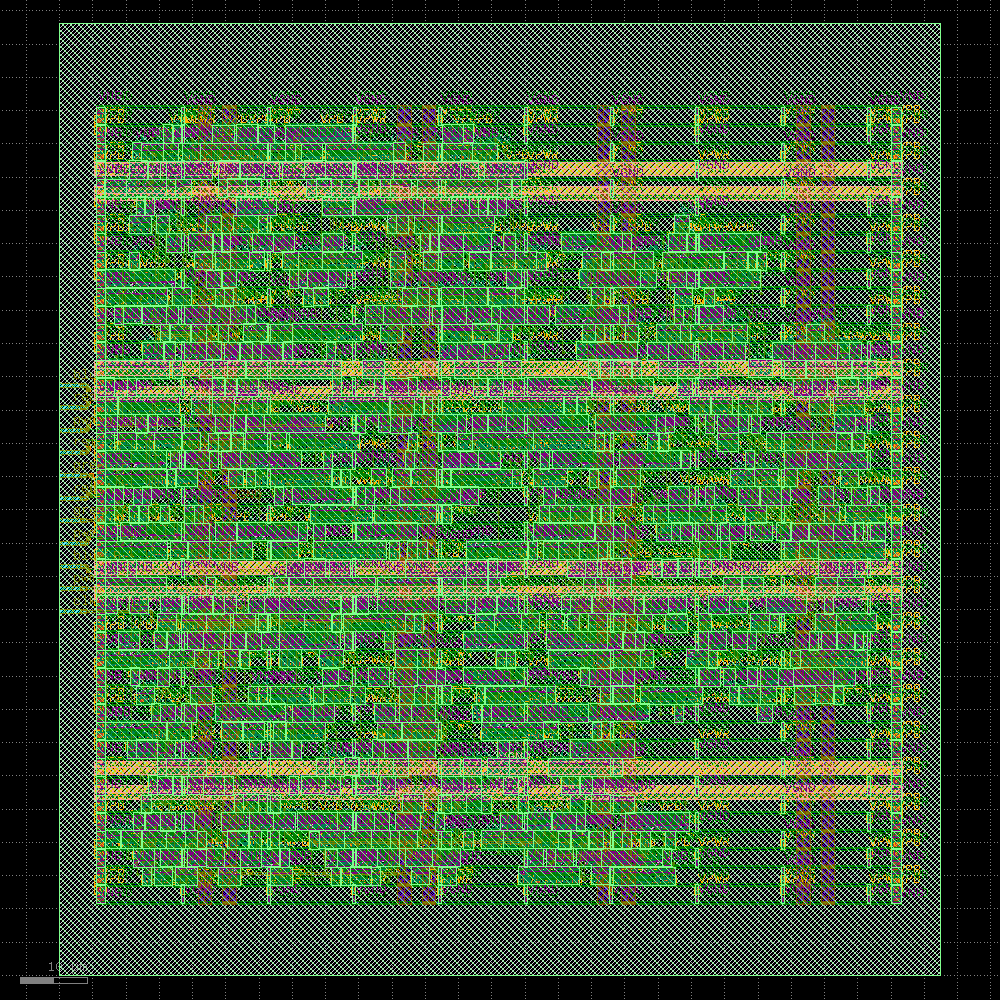

In [35]:
display(drt)

In [36]:
display_metrics("drt")


All available metrics for drt:
design__instance__count: 993
design__instance__area: 6945.41
design__instance_unmapped__count: 0
synthesis__check_error__count: 0
design__die__bbox: 0.0 0.0 132.435 143.155
design__core__bbox: 5.52 10.88 126.5 130.56
flow__warnings__count: 10
flow__errors__count: 0
design__io: 13
design__die__area: 18958.7
design__core__area: 14478.9
design__instance__count__stdcell: 993
design__instance__area__stdcell: 6945.41
design__instance__count__macros: 0
design__instance__area__macros: 0
design__instance__utilization: 0.479692
design__instance__utilization__stdcell: 0.479692
floorplan__design__io: 11
design__io__hpwl: 830550
design__power_grid_violation__count__net:VGND: 0
design__power_grid_violation__count__net:VPWR: 0
design__power_grid_violation__count: 0
timing__drv__floating__nets: 0
timing__drv__floating__pins: 0
design__instance__displacement__total: 0
design__instance__displacement__mean: 0
design__instance__displacement__max: 0
route__wirelength__estima

### Fill Insertion

Additional metal layers are used to fill parts of the die that are empty. One thing that is generally added are decoupling capacitors which improve signal integrity. Additional fills may include grounded fills that can acts as shields, reducing cross talk between lines.

In [37]:
%%capture
FillInsertion = Step.factory.get("OpenROAD.FillInsertion")

fill = FillInsertion(state_in=drt.state_out)
fill.start()

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[00:39:05] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=976368;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=773856;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[00:39:05] VERBOSE  Logging subprocess to ]8;id=325341;file:///tmp/openlane_klayout_tmp_6g_l93cw/klayout-render.log\..]8;;\]8;id=44077;file:///tmp/openlane_klayout_tmp_6g_l93cw/klayout-render.log\/tmp/openlane_klayout_tmp_6g_l93cw/]8;;\]8;id=486061;file:///tmp/openlane_klayout_tmp_6g_l93cw/klayout-render.log\klayout-render.log]8;;\…     ]8;id=293504;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=914165;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

#### Time Elapsed: 0.92s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
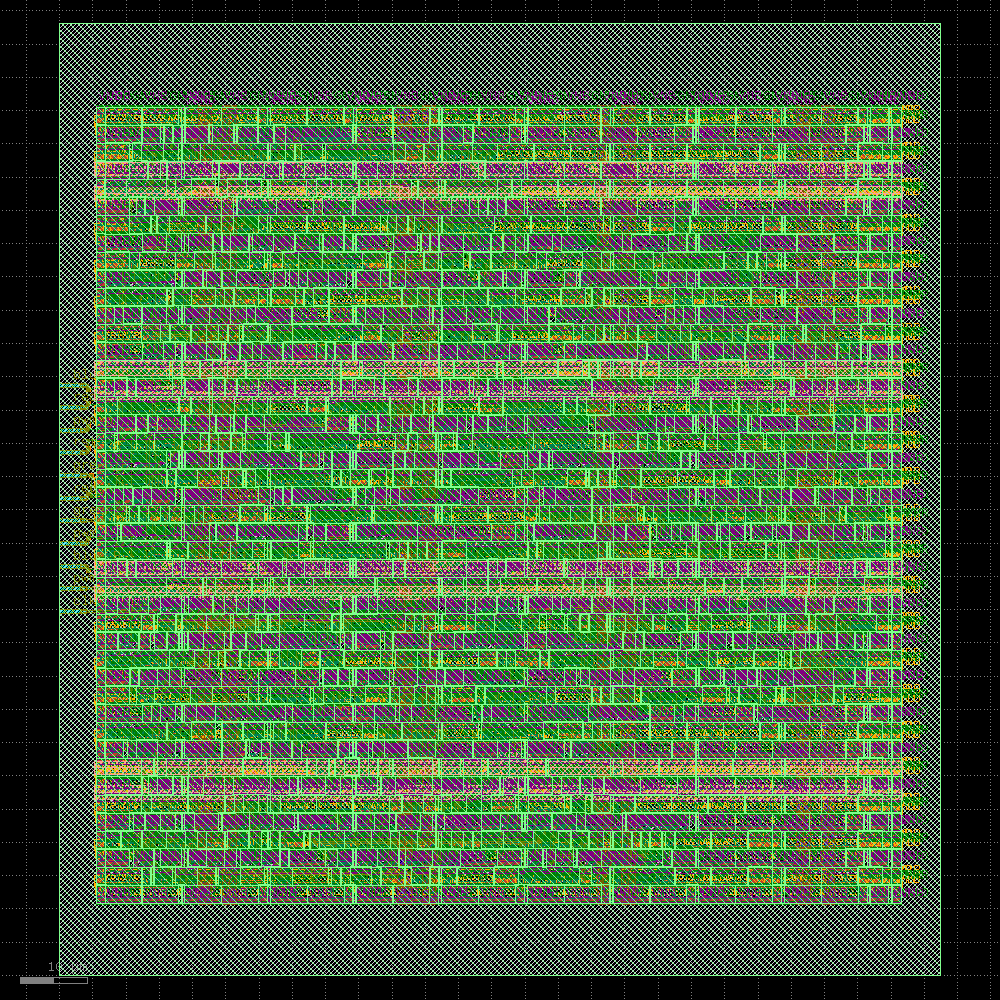

In [38]:
display(fill)

In [39]:
display_metrics("fill")


All available metrics for fill:
design__instance__count: 993
design__instance__area: 6945.41
design__instance_unmapped__count: 0
synthesis__check_error__count: 0
design__die__bbox: 0.0 0.0 132.435 143.155
design__core__bbox: 5.52 10.88 126.5 130.56
flow__warnings__count: 0
flow__errors__count: 0
design__io: 13
design__die__area: 18958.7
design__core__area: 14478.9
design__instance__count__stdcell: 993
design__instance__area__stdcell: 6945.41
design__instance__count__macros: 0
design__instance__area__macros: 0
design__instance__utilization: 0.479692
design__instance__utilization__stdcell: 0.479692
floorplan__design__io: 11
design__io__hpwl: 830550
design__power_grid_violation__count__net:VGND: 0
design__power_grid_violation__count__net:VPWR: 0
design__power_grid_violation__count: 0
timing__drv__floating__nets: 0
timing__drv__floating__pins: 0
design__instance__displacement__total: 0
design__instance__displacement__mean: 0
design__instance__displacement__max: 0
route__wirelength__estima

### Parasitics Extraction a.k.a. Resistance/Capacitance Extraction (RCX)

In this step, parasitic elements of the circuit are identified and or calculated. These parts of the circuit are unwanted (parasitic) and have an impact on timing which we must account for. These impedances are unavoidable in any design and should be minimised.

In [40]:
%%capture
RCX = Step.factory.get("OpenROAD.RCX")

rcx = RCX(state_in=fill.state_out)
rcx.start()

# Sign off

Sign off is the process in which the chip is verified to be working correctly. It is the final stage before the design is sent to a manufacturere.  

### Static Timing Analysis (Post-PnR)

STA is a process that verifies that a chip meets certain constraints on clock
and data timings to run at its rated clock speed.

This identifies the timing differences in the circuit and identifies timing violations (e.g. If the data arrives after or before it is required). It also verifies that it is running at the right clock speed.

STA also ensures that a circuit will correctly perform its function.

In [41]:

STAPostPNR = Step.factory.get("OpenROAD.STAPostPNR")

sta_post_pnr = STAPostPNR(state_in=rcx.state_out)
sta_post_pnr.start()

──────────────────────────────────────── Static Timing Analysis (Post-PnR) ────────────────────────────────────────

[00:39:08] VERBOSE  Running 'OpenROAD.STAPostPNR'…                                                     ]8;id=162777;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=212722;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[00:39:08] INFO     Starting STA for the nom_tt_025C_1v80 timing corner…                            ]8;id=828990;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=133629;file:///content/openlane_ipynb/openlane/steps/openroad.py#561\561]8;;\

[00:39:08] INFO     Starting STA for the nom_ss_100C_1v60 timing corner…                            ]8;id=259120;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=908234;file:///content/openlane_ipynb/openlane/steps/openroad.py#561\561]8;;\

[00:39:08] VERBOSE  Logging subprocess to                                                              ]8;id=784275;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=987889;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=703444;file:///content/openlane_run/15-openroad-stapostpnr/nom_tt_025C_1v80/sta.log\openlane_run/]8;;\]8;id=233799;file:///content/openlane_run/15-openroad-stapostpnr/nom_tt_025C_1v80/sta.log\15]8;;\]8;id=703444;file:///content/openlane_run/15-openroad-stapostpnr/nom_tt_025C_1v80/sta.log\-openroad-stapostpnr/nom_tt_025C_1v80/sta.log]8;;\…                                  

[00:39:08] VERBOSE  Logging subprocess to                                                              ]8;id=563688;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=965182;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=763825;file:///content/openlane_run/15-openroad-stapostpnr/nom_ss_100C_1v60/sta.log\openlane_run/]8;;\]8;id=745288;file:///content/openlane_run/15-openroad-stapostpnr/nom_ss_100C_1v60/sta.log\15]8;;\]8;id=763825;file:///content/openlane_run/15-openroad-stapostpnr/nom_ss_100C_1v60/sta.log\-openroad-stapostpnr/nom_ss_100C_1v60/sta.log]8;;\…                                  

[00:39:10] INFO     Finished STA for the nom_ss_100C_1v60 timing corner.                            ]8;id=510415;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=845321;file:///content/openlane_ipynb/openlane/steps/openroad.py#576\576]8;;\

[00:39:10] INFO     Finished STA for the nom_tt_025C_1v80 timing corner.                            ]8;id=443781;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=229543;file:///content/openlane_ipynb/openlane/steps/openroad.py#576\576]8;;\

[00:39:10] VERBOSE  Logging subprocess to                                                              ]8;id=928113;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=499822;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=683922;file:///content/openlane_run/15-openroad-stapostpnr/nom_ss_100C_1v60/filter_unannotated.log\openlane_run/]8;;\]8;id=406245;file:///content/openlane_run/15-openroad-stapostpnr/nom_ss_100C_1v60/filter_unannotated.log\15]8;;\]8;id=683922;file:///content/openlane_run/15-openroad-stapostpnr/nom_ss_100C_1v60/filter_unannotated.log\-openroad-stapostpnr/nom_ss_100C_1v60/filter_unannotated.log]8;;\…                   

[00:39:10] VERBOSE  Logging subprocess to                                                              ]8;id=811636;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=871533;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=633124;file:///content/openlane_run/15-openroad-stapostpnr/nom_tt_025C_1v80/filter_unannotated.log\openlane_run/]8;;\]8;id=832082;file:///content/openlane_run/15-openroad-stapostpnr/nom_tt_025C_1v80/filter_unannotated.log\15]8;;\]8;id=633124;file:///content/openlane_run/15-openroad-stapostpnr/nom_tt_025C_1v80/filter_unannotated.log\-openroad-stapostpnr/nom_tt_025C_1v80/filter_unannotated.log]8;;\…                   

[00:39:12] INFO     Starting STA for the nom_ff_n40C_1v95 timing corner…                            ]8;id=741283;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=758312;file:///content/openlane_ipynb/openlane/steps/openroad.py#561\561]8;;\

[00:39:12] VERBOSE  Logging subprocess to                                                              ]8;id=669554;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=966950;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=883079;file:///content/openlane_run/15-openroad-stapostpnr/nom_ff_n40C_1v95/sta.log\openlane_run/]8;;\]8;id=435439;file:///content/openlane_run/15-openroad-stapostpnr/nom_ff_n40C_1v95/sta.log\15]8;;\]8;id=883079;file:///content/openlane_run/15-openroad-stapostpnr/nom_ff_n40C_1v95/sta.log\-openroad-stapostpnr/nom_ff_n40C_1v95/sta.log]8;;\…                                  

[00:39:12] INFO     Starting STA for the min_tt_025C_1v80 timing corner…                            ]8;id=738014;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=235521;file:///content/openlane_ipynb/openlane/steps/openroad.py#561\561]8;;\

[00:39:12] VERBOSE  Logging subprocess to                                                              ]8;id=691193;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=125308;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=705403;file:///content/openlane_run/15-openroad-stapostpnr/min_tt_025C_1v80/sta.log\openlane_run/]8;;\]8;id=552686;file:///content/openlane_run/15-openroad-stapostpnr/min_tt_025C_1v80/sta.log\15]8;;\]8;id=705403;file:///content/openlane_run/15-openroad-stapostpnr/min_tt_025C_1v80/sta.log\-openroad-stapostpnr/min_tt_025C_1v80/sta.log]8;;\…                                  

[00:39:14] INFO     Finished STA for the min_tt_025C_1v80 timing corner.                            ]8;id=828443;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=525274;file:///content/openlane_ipynb/openlane/steps/openroad.py#576\576]8;;\

[00:39:14] VERBOSE  Logging subprocess to                                                              ]8;id=9286;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=56865;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=463296;file:///content/openlane_run/15-openroad-stapostpnr/min_tt_025C_1v80/filter_unannotated.log\openlane_run/]8;;\]8;id=474824;file:///content/openlane_run/15-openroad-stapostpnr/min_tt_025C_1v80/filter_unannotated.log\15]8;;\]8;id=463296;file:///content/openlane_run/15-openroad-stapostpnr/min_tt_025C_1v80/filter_unannotated.log\-openroad-stapostpnr/min_tt_025C_1v80/filter_unannotated.log]8;;\…                   

[00:39:16] INFO     Finished STA for the nom_ff_n40C_1v95 timing corner.                            ]8;id=396130;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=907286;file:///content/openlane_ipynb/openlane/steps/openroad.py#576\576]8;;\

[00:39:16] VERBOSE  Logging subprocess to                                                              ]8;id=561986;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=958973;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=677475;file:///content/openlane_run/15-openroad-stapostpnr/nom_ff_n40C_1v95/filter_unannotated.log\openlane_run/]8;;\]8;id=445703;file:///content/openlane_run/15-openroad-stapostpnr/nom_ff_n40C_1v95/filter_unannotated.log\15]8;;\]8;id=677475;file:///content/openlane_run/15-openroad-stapostpnr/nom_ff_n40C_1v95/filter_unannotated.log\-openroad-stapostpnr/nom_ff_n40C_1v95/filter_unannotated.log]8;;\…                   

[00:39:16] INFO     Starting STA for the min_ss_100C_1v60 timing corner…                            ]8;id=455461;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=954449;file:///content/openlane_ipynb/openlane/steps/openroad.py#561\561]8;;\

[00:39:16] VERBOSE  Logging subprocess to                                                              ]8;id=486078;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=90481;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=546542;file:///content/openlane_run/15-openroad-stapostpnr/min_ss_100C_1v60/sta.log\openlane_run/]8;;\]8;id=913449;file:///content/openlane_run/15-openroad-stapostpnr/min_ss_100C_1v60/sta.log\15]8;;\]8;id=546542;file:///content/openlane_run/15-openroad-stapostpnr/min_ss_100C_1v60/sta.log\-openroad-stapostpnr/min_ss_100C_1v60/sta.log]8;;\…                                  

[00:39:18] INFO     Starting STA for the min_ff_n40C_1v95 timing corner…                            ]8;id=668967;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=204496;file:///content/openlane_ipynb/openlane/steps/openroad.py#561\561]8;;\

[00:39:18] VERBOSE  Logging subprocess to                                                              ]8;id=615929;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=545217;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=844826;file:///content/openlane_run/15-openroad-stapostpnr/min_ff_n40C_1v95/sta.log\openlane_run/]8;;\]8;id=134459;file:///content/openlane_run/15-openroad-stapostpnr/min_ff_n40C_1v95/sta.log\15]8;;\]8;id=844826;file:///content/openlane_run/15-openroad-stapostpnr/min_ff_n40C_1v95/sta.log\-openroad-stapostpnr/min_ff_n40C_1v95/sta.log]8;;\…                                  

[00:39:18] INFO     Finished STA for the min_ss_100C_1v60 timing corner.                            ]8;id=481144;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=704025;file:///content/openlane_ipynb/openlane/steps/openroad.py#576\576]8;;\

[00:39:18] VERBOSE  Logging subprocess to                                                              ]8;id=118842;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=452000;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=440202;file:///content/openlane_run/15-openroad-stapostpnr/min_ss_100C_1v60/filter_unannotated.log\openlane_run/]8;;\]8;id=707450;file:///content/openlane_run/15-openroad-stapostpnr/min_ss_100C_1v60/filter_unannotated.log\15]8;;\]8;id=440202;file:///content/openlane_run/15-openroad-stapostpnr/min_ss_100C_1v60/filter_unannotated.log\-openroad-stapostpnr/min_ss_100C_1v60/filter_unannotated.log]8;;\…                   

[00:39:20] INFO     Starting STA for the max_tt_025C_1v80 timing corner…                            ]8;id=534620;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=440844;file:///content/openlane_ipynb/openlane/steps/openroad.py#561\561]8;;\

[00:39:20] VERBOSE  Logging subprocess to                                                              ]8;id=554502;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=493543;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=699902;file:///content/openlane_run/15-openroad-stapostpnr/max_tt_025C_1v80/sta.log\openlane_run/]8;;\]8;id=860780;file:///content/openlane_run/15-openroad-stapostpnr/max_tt_025C_1v80/sta.log\15]8;;\]8;id=699902;file:///content/openlane_run/15-openroad-stapostpnr/max_tt_025C_1v80/sta.log\-openroad-stapostpnr/max_tt_025C_1v80/sta.log]8;;\…                                  

[00:39:23] INFO     Finished STA for the max_tt_025C_1v80 timing corner.                            ]8;id=875258;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=580518;file:///content/openlane_ipynb/openlane/steps/openroad.py#576\576]8;;\

[00:39:23] VERBOSE  Logging subprocess to                                                              ]8;id=978156;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=603101;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=501828;file:///content/openlane_run/15-openroad-stapostpnr/max_tt_025C_1v80/filter_unannotated.log\openlane_run/]8;;\]8;id=438493;file:///content/openlane_run/15-openroad-stapostpnr/max_tt_025C_1v80/filter_unannotated.log\15]8;;\]8;id=501828;file:///content/openlane_run/15-openroad-stapostpnr/max_tt_025C_1v80/filter_unannotated.log\-openroad-stapostpnr/max_tt_025C_1v80/filter_unannotated.log]8;;\…                   

[00:39:23] INFO     Finished STA for the min_ff_n40C_1v95 timing corner.                            ]8;id=614842;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=331011;file:///content/openlane_ipynb/openlane/steps/openroad.py#576\576]8;;\

[00:39:23] VERBOSE  Logging subprocess to                                                              ]8;id=363672;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=246761;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=86055;file:///content/openlane_run/15-openroad-stapostpnr/min_ff_n40C_1v95/filter_unannotated.log\openlane_run/]8;;\]8;id=897736;file:///content/openlane_run/15-openroad-stapostpnr/min_ff_n40C_1v95/filter_unannotated.log\15]8;;\]8;id=86055;file:///content/openlane_run/15-openroad-stapostpnr/min_ff_n40C_1v95/filter_unannotated.log\-openroad-stapostpnr/min_ff_n40C_1v95/filter_unannotated.log]8;;\…                   

[00:39:24] INFO     Starting STA for the max_ss_100C_1v60 timing corner…                            ]8;id=510973;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=3314;file:///content/openlane_ipynb/openlane/steps/openroad.py#561\561]8;;\

[00:39:24] VERBOSE  Logging subprocess to                                                              ]8;id=918818;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=562118;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=743974;file:///content/openlane_run/15-openroad-stapostpnr/max_ss_100C_1v60/sta.log\openlane_run/]8;;\]8;id=697321;file:///content/openlane_run/15-openroad-stapostpnr/max_ss_100C_1v60/sta.log\15]8;;\]8;id=743974;file:///content/openlane_run/15-openroad-stapostpnr/max_ss_100C_1v60/sta.log\-openroad-stapostpnr/max_ss_100C_1v60/sta.log]8;;\…                                  

[00:39:25] INFO     Starting STA for the max_ff_n40C_1v95 timing corner…                            ]8;id=496003;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=107627;file:///content/openlane_ipynb/openlane/steps/openroad.py#561\561]8;;\

[00:39:25] VERBOSE  Logging subprocess to                                                              ]8;id=838349;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=336533;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=486826;file:///content/openlane_run/15-openroad-stapostpnr/max_ff_n40C_1v95/sta.log\openlane_run/]8;;\]8;id=118195;file:///content/openlane_run/15-openroad-stapostpnr/max_ff_n40C_1v95/sta.log\15]8;;\]8;id=486826;file:///content/openlane_run/15-openroad-stapostpnr/max_ff_n40C_1v95/sta.log\-openroad-stapostpnr/max_ff_n40C_1v95/sta.log]8;;\…                                  

[00:39:27] INFO     Finished STA for the max_ss_100C_1v60 timing corner.                            ]8;id=506669;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=472671;file:///content/openlane_ipynb/openlane/steps/openroad.py#576\576]8;;\

[00:39:27] VERBOSE  Logging subprocess to                                                              ]8;id=92554;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=912412;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=597448;file:///content/openlane_run/15-openroad-stapostpnr/max_ss_100C_1v60/filter_unannotated.log\openlane_run/]8;;\]8;id=963271;file:///content/openlane_run/15-openroad-stapostpnr/max_ss_100C_1v60/filter_unannotated.log\15]8;;\]8;id=597448;file:///content/openlane_run/15-openroad-stapostpnr/max_ss_100C_1v60/filter_unannotated.log\-openroad-stapostpnr/max_ss_100C_1v60/filter_unannotated.log]8;;\…                   

[00:39:28] INFO     Finished STA for the max_ff_n40C_1v95 timing corner.                            ]8;id=661800;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=988998;file:///content/openlane_ipynb/openlane/steps/openroad.py#576\576]8;;\

[00:39:28] VERBOSE  Logging subprocess to                                                              ]8;id=654592;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=38507;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=699668;file:///content/openlane_run/15-openroad-stapostpnr/max_ff_n40C_1v95/filter_unannotated.log\openlane_run/]8;;\]8;id=60128;file:///content/openlane_run/15-openroad-stapostpnr/max_ff_n40C_1v95/filter_unannotated.log\15]8;;\]8;id=699668;file:///content/openlane_run/15-openroad-stapostpnr/max_ff_n40C_1v95/filter_unannotated.log\-openroad-stapostpnr/max_ff_n40C_1v95/filter_unannotated.log]8;;\…                   

┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┓
┃                      ┃       ┃       ┃      ┃       ┃ of   ┃       ┃      ┃       ┃      ┃ of    ┃      ┃       ┃
┃                      ┃       ┃ Reg   ┃      ┃       ┃ whi… ┃       ┃ Reg  ┃       ┃      ┃ which ┃      ┃       ┃
┃                      ┃ Hold  ┃ to    ┃      ┃ Hold  ┃ reg  ┃ Setup ┃ to   ┃       ┃ Set… ┃ reg   ┃ Max  ┃ Max   ┃
┃                      ┃ Worst ┃ Reg   ┃ Hold ┃ Vio   ┃ to   ┃ Worst ┃ Reg  ┃ Setup ┃ Vio  ┃ to    ┃ Cap  ┃ Slew  ┃
┃ Corner/Group         ┃ Slack ┃ Paths ┃ TNS  ┃ Count ┃ reg  ┃ Slack ┃ Pat… ┃ TNS   ┃ Cou… ┃ reg   ┃ Vio… ┃ Viol… ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━┩
│ Overall              │ 0.06… │ 0.06… │ 0.0… │ 0     │ 0    │ -4.4… │ -4.… │ -12.… │ 9    │ 9     │ 0    │ 0     │
│ nom_tt_025C_1v80     │ 0.26… │ 0.26… │ 0.0… │ 0     │ 0    │ 2.74… │ 2.7… │ 0.00… │ 0    │ 0     │ 0    │ 0     │
│ nom_ss_100C_1v60     │ 0.80… │ 0.80… │ 0.0… │ 0     │ 0    │ -4.3… │ -4.… │ -12.… │ 3    │ 3     │ 0    │ 0     │
│ nom_ff_n40C_1v95     │ 0.06… │ 0.06… │ 0.0… │ 0     │ 0    │ 5.32… │ 5.3… │ 0.00… │ 0    │ 0     │ 0    │ 0     │
│ min_tt_025C_1v80     │ 0.26… │ 0.26… │ 0.0… │ 0     │ 0    │ 2.79… │ 2.7… │ 0.00… │ 0    │ 0     │ 0    │ 0     │
│ min_ss_100C_1v60     │ 0.79… │ 0.79… │ 0.0… │ 0     │ 0    │ -4.2… │ -4.… │ -11.… │ 3    │ 3     │ 0    │ 0     │
│ min_ff_n40C_1v95     │ 0.06… │ 0.06… │ 0.0… │ 0     │ 0    │ 5.35… │ 5.3… │ 0.00… │ 0    │ 0     │ 0    │ 0     │
│ max_tt_025C_1v80     │ 0.27… │ 0.27… │ 0.0… │ 0     │ 0    │ 2.68… │ 2.6… │ 0.00… │ 0    │ 0     │ 0    │ 0     │
│ max_ss_100C_1v60     │ 0.80… │ 0.80… │ 0.0… │ 0     │ 0    │ -4.4… │ -4.… │ -12.… │ 3    │ 3     │ 0    │ 0     │
│ max_ff_n40C_1v95     │ 0.06… │ 0.06… │ 0.0… │ 0     │ 0    │ 5.28… │ 5.2… │ 0.00… │ 0    │ 0     │ 0    │ 0     │
└──────────────────────┴───────┴───────┴──────┴───────┴──────┴───────┴──────┴───────┴──────┴───────┴──────┴───────┘

┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┓
┃                      ┃ Hold     ┃ Reg to   ┃          ┃          ┃ of which  ┃ Setup    ┃           ┃          ┃           ┃ of which ┃           ┃          ┃
┃                      ┃ Worst    ┃ Reg      ┃          ┃ Hold Vio ┃ reg to    ┃ Worst    ┃ Reg to    ┃ Setup    ┃ Setup Vio ┃ reg to   ┃ Max Cap   ┃ Max Slew ┃
┃ Corner/Group         ┃ Slack    ┃ Paths    ┃ Hold TNS ┃ Count    ┃ reg       ┃ Slack    ┃ Reg Paths ┃ TNS      ┃ Count     ┃ reg      ┃ Violatio… ┃ Violati… ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━┩
│ Overall              │ 0.0645   │ 0.0645   │ 0.0000   │ 0        │ 0         │ -4.4590  │ -4.4590   │ -12.5779 │ 9         │ 9        │ 0         │ 0        │
│ nom_tt_025C_1v80     │ 0.2693   │ 0.2693   │ 0.0000   │ 0        │ 0         │ 2.7416   │ 2.7416    │ 0.0000   │ 0         │ 0        │ 0         │ 0        │
│ nom_ss_100C_1v60     │ 0.8012   │ 0.8012   │ 0.0000   │ 0        │ 0         │ -4.3599  │ -4.3599   │ -12.2528 │ 3         │ 3        │ 0         │ 0        │
│ nom_ff_n40C_1v95     │ 0.0672   │ 0.0672   │ 0.0000   │ 0        │ 0         │ 5.3242   │ 5.3242    │ 0.0000   │ 0         │ 0        │ 0         │ 0        │
│ min_tt_025C_1v80     │ 0.2653   │ 0.2653   │ 0.0000   │ 0        │ 0         │ 2.7912   │ 2.7912    │ 0.0000   │ 0         │ 0        │ 0         │ 0        │
│ min_ss_100C_1v60     │ 0.7941   │ 0.7941   │ 0.0000   │ 0        │ 0         │ -4.2801  │ -4.2801   │ -11.9696 │ 3         │ 3        │ 0         │ 0        │
│ min_ff_n40C_1v95     │ 0.0645   │ 0.0645   │ 0.0000   │ 0        │ 0         │ 5.3588   │ 5.3588    │ 0.0000   │ 0         │ 0        │ 0         │ 0        │
│ max_tt_025C_1v80     │ 0.2720   │ 0.2720   │ 0.0000   │ 0        │ 0         │ 2.6853   │ 2.6853    │ 0.0000   │ 0         │ 0        │ 0         │ 0        │
│ max_ss_100C_1v60     │ 0.8076   │ 0.8076   │ 0.0000   │ 0        │ 0         │ -4.4590  │ -4.4590   │ -12.5779 │ 3         │ 3        │ 0         │ 0        │
│ max_ff_n40C_1v95     │ 0.0691   │ 0.0691   │ 0.0000   │ 0        │ 0         │ 5.2850   │ 5.2850    │ 0.0000   │ 0         │ 0        │ 0         │ 0        │
└──────────────────────┴──────────┴──────────┴──────────┴──────────┴───────────┴──────────┴───────────┴──────────┴───────────┴──────────┴───────────┴──────────┘

{'nl': Path('/content/openlane_run/13-openroad-fillinsertion/rgb_led_driver.nl.v'), 'pnl': Path('/content/openlane_run/13-openroad-fillinsertion/rgb_led_driver.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/13-openroad-fillinsertion/rgb_led_driver.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/13-openroad-fillinsertion/rgb_led_driver.odb'), 'sdc': Path('/content/openlane_run/13-openroad-fillinsertion/rgb_led_driver.sdc'), 'sdf': {'nom_tt_025C_1v80': Path('/content/openlane_run/15-openroad-stapostpnr/nom_tt_025C_1v80/rgb_led_driver__nom_tt_025C_1v80.sdf'), 'nom_ss_100C_1v60': Path('/content/openlane_run/15-openroad-stapostpnr/nom_ss_100C_1v60/rgb_led_driver__nom_ss_100C_1v60.sdf'), 'nom_ff_n40C_1v95': Path('/content/openlane_run/15-openroad-stapostpnr/nom_ff_n40C_1v95/rgb_led_driver__nom_ff_n40C_1v95.sdf'), 'min_tt_025C_1v80': Path('/content/openlane_run/15-openroad-stapostpnr/min_tt_025C_1v80/rgb_led_driver__min_tt_025C_1v80.sdf'), 'min_ss_100C_1v60': Path('/content/openlane_run/15-openroad-stapostpnr/min_ss_100C_1v60/rgb_led_driver__min_ss_100C_1v60.sdf'), 'min_ff_n40C_1v95': Path('/content/openlane_run/15-openroad-stapostpnr/min_ff_n40C_1v95/rgb_led_driver__min_ff_n40C_1v95.sdf'), 'max_tt_025C_1v80': Path('/content/openlane_run/15-openroad-stapostpnr/max_tt_025C_1v80/rgb_led_driver__max_tt_025C_1v80.sdf'), 'max_ss_100C_1v60': Path('/content/openlane_run/15-openroad-stapostpnr/max_ss_100C_1v60/rgb_led_driver__max_ss_100C_1v60.sdf'), 'max_ff_n40C_1v95': Path('/content/openlane_run/15-openroad-stapostpnr/max_ff_n40C_1v95/rgb_led_driver__max_ff_n40C_1v95.sdf')}, 'spef': {'nom_*': Path('/content/openlane_run/14-openroad-rcx/nom/rgb_led_driver.nom.spef'), 'min_*': Path('/content/openlane_run/14-openroad-rcx/min/rgb_led_driver.min.spef'), 'max_*': Path('/content/openlane_run/14-openroad-rcx/max/rgb_led_driver.max.spef')}, 'lib': {'nom_tt_025C_1v80': Path('/content/openlane_run/15-openroad-stapostpnr/nom_tt_025C_1v80/rgb_led_driver__nom_tt_025C_1v80.lib'), 'nom_ss_100C_1v60': Path('/content/openlane_run/15-openroad-stapostpnr/nom_ss_100C_1v60/rgb_led_driver__nom_ss_100C_1v60.lib'), 'nom_ff_n40C_1v95': Path('/content/openlane_run/15-openroad-stapostpnr/nom_ff_n40C_1v95/rgb_led_driver__nom_ff_n40C_1v95.lib'), 'min_tt_025C_1v80': Path('/content/openlane_run/15-openroad-stapostpnr/min_tt_025C_1v80/rgb_led_driver__min_tt_025C_1v80.lib'), 'min_ss_100C_1v60': Path('/content/openlane_run/15-openroad-stapostpnr/min_ss_100C_1v60/rgb_led_driver__min_ss_100C_1v60.lib'), 'min_ff_n40C_1v95': Path('/content/openlane_run/15-openroad-stapostpnr/min_ff_n40C_1v95/rgb_led_driver__min_ff_n40C_1v95.lib'), 'max_tt_025C_1v80': Path('/content/openlane_run/15-openroad-stapostpnr/max_tt_025C_1v80/rgb_led_driver__max_tt_025C_1v80.lib'), 'max_ss_100C_1v60': Path('/content/openlane_run/15-openroad-stapostpnr/max_ss_100C_1v60/rgb_led_driver__max_ss_100C_1v60.lib'), 'max_ff_n40C_1v95': Path('/content/openlane_run/15-openroad-stapostpnr/max_ff_n40C_1v95/rgb_led_driver__max_ff_n40C_1v95.lib')}, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 993, 'design__instance__area': Decimal('6945.41'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 132.435 143.155', 'design__core__bbox': '5.52 10.88 126.5 130.56', 'flow__warnings__count': 1, 'flow__errors__count': 0, 'design__io': 13, 'design__die__area': Decimal('18958.7'), 'design__core__area': Decimal('14478.9'), 'design__instance__count__stdcell': 993, 'design__instance__area__stdcell': Decimal('6945.41'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.479692'), 'design__instance__utilization__stdcell': Decimal('0.479692'), 'floorplan__design__io': 11, 'design__io__hpwl': 830550, 'design__power_grid_violation__count__net:VGND': 0,

### Stream-out

Stream-out is the process of converting the designs from the abstract formats
using during floorplanning, placement and routing into a concrete format called
GDSII (lit. Graphic Design System 2), which is the final file that is then sent
for fabrication.

In [58]:
%%capture
StreamOut = Step.factory.get("KLayout.StreamOut")

gds = StreamOut(state_in=sta_post_pnr.state_out)
gds.start()

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[00:39:30] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=389077;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=298815;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[00:39:30] VERBOSE  Logging subprocess to ]8;id=509216;file:///tmp/openlane_klayout_tmp_6h2snait/klayout-render.log\..]8;;\]8;id=736153;file:///tmp/openlane_klayout_tmp_6h2snait/klayout-render.log\/tmp/openlane_klayout_tmp_6h2snait/]8;;\]8;id=174022;file:///tmp/openlane_klayout_tmp_6h2snait/klayout-render.log\klayout-render.log]8;;\…     ]8;id=706320;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=41203;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

#### Time Elapsed: 0.92s
#### Views updated:
* GDSII Stream
* GDSII Stream (KLayout)
#### Preview:
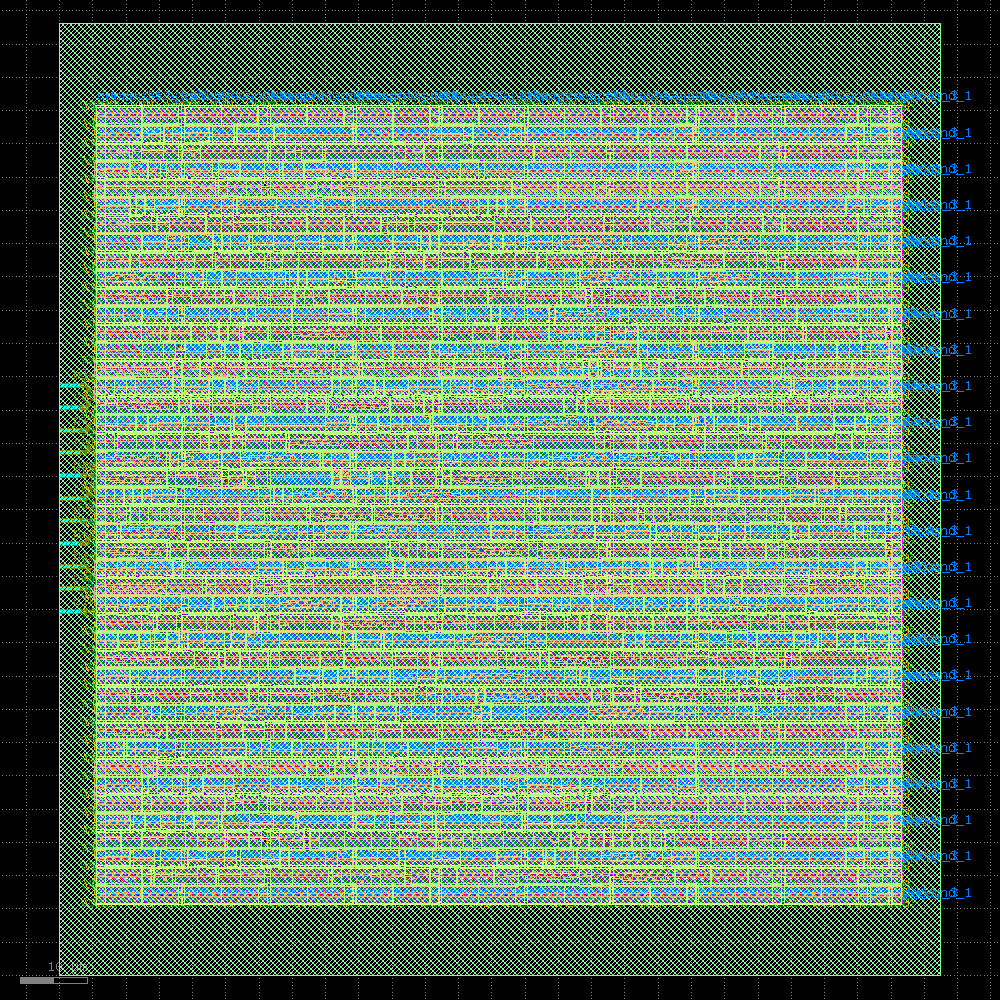

In [43]:
display(gds)

### Design Rule Checks (DRC)


This checks the design against rules set by the foundry, ensuring the design is manufacturable. This could be  the minimum allowed spacing between two wires, for example.

> This is why the PDK is so important. It sets the rules based off of which we can make a chip.

In [44]:
DRC = Step.factory.get("Magic.DRC")

drc = DRC(state_in=gds.state_out)
drc.start()

─────────────────────────────────────────────── Design Rule Checks ────────────────────────────────────────────────

[00:39:31] VERBOSE  Running 'Magic.DRC'…                                                               ]8;id=7025;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=185893;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[00:39:31] VERBOSE  Logging subprocess to ]8;id=579469;file:///content/openlane_run/17-magic-drc/magic-drc.log\openlane_run/]8;;\]8;id=410386;file:///content/openlane_run/17-magic-drc/magic-drc.log\17]8;;\]8;id=579469;file:///content/openlane_run/17-magic-drc/magic-drc.log\-magic-drc/magic-drc.log]8;;\…                     ]8;id=33015;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=251908;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

Magic 8.3 revision 483 - Compiled on Sun Jun  2 18:57:41 UTC 2024.

Starting magic under Tcl interpreter

Using the terminal as the console.

Using NULL graphics device.

Processing system .magicrc file

Sourcing design .magicrc for technology sky130A ...

2 Magic internal units = 1 Lambda

Input style sky130(): scaleFactor=2, multiplier=2

The following types are not handled by extraction and will be treated as non-electrical types:

ubm

Scaled tech values by 2 / 1 to match internal grid scaling

Loading sky130A Device Generator Menu ...

Loading "/content/openlane_ipynb/openlane/scripts/magic/wrapper.tcl" from command line.

Warning: Calma reading is not undoable!  I hope that's OK.

Library written using GDS-II Release 6.0

Library name: LIB

Reading "VIA_M1M2_PR_MR".

Reading "VIA_M2M3_PR".

Reading "VIA_M1M2_PR".

Reading "VIA_L1M1_PR_MR".

Reading "VIA_via2_3_2000_480_1_6_320_320".

Reading "VIA_via3_4_2000_480_1_5_400_400".

Reading "VIA_via4_5_2000_480_1_5_400_400".

Reading "VIA_via5_6_2000_2000_1_1_1600_1600".

Reading "sky130_fd_sc_hd__clkbuf_1".

Reading "sky130_fd_sc_hd__buf_1".

Reading "sky130_fd_sc_hd__buf_4".

Reading "sky130_fd_sc_hd__buf_2".

Reading "sky130_fd_sc_hd__clkbuf_2".

Reading "sky130_fd_sc_hd__clkbuf_4".

Reading "sky130_fd_sc_hd__clkinv_2".

Reading "sky130_fd_sc_hd__clkinvlp_4".

Reading "sky130_fd_sc_hd__clkbuf_8".

Reading "sky130_fd_sc_hd__bufinv_16".

Reading "sky130_fd_sc_hd__clkinv_4".

Reading "sky130_fd_sc_hd__clkbuf_16".

Reading "sky130_fd_sc_hd__conb_1".

Reading "sky130_fd_sc_hd__dfrtp_2".

Reading "sky130_fd_sc_hd__dfrtp_4".

Reading "sky130_fd_sc_hd__dfrtp_1".

Reading "sky130_fd_sc_hd__o311ai_1".

Reading "sky130_fd_sc_hd__and4b_2".

Reading "sky130_fd_sc_hd__a21oi_2".

Reading "sky130_fd_sc_hd__and2_2".

Reading "sky130_fd_sc_hd__o32ai_4".

Reading "sky130_fd_sc_hd__and4bb_1".

Reading "sky130_fd_sc_hd__o211ai_1".

Reading "sky130_fd_sc_hd__a21boi_2".

Reading "sky130_fd_sc_hd__o2111ai_1".

Reading "sky130_fd_sc_hd__o31ai_4".

Reading "sky130_fd_sc_hd__nand4_2".

Reading "sky130_fd_sc_hd__nor2_2".

Reading "sky130_fd_sc_hd__nand4_4".

Reading "sky130_fd_sc_hd__xor2_4".

Reading "sky130_fd_sc_hd__o2111a_2".

Reading "sky130_fd_sc_hd__a32o_1".

Reading "sky130_fd_sc_hd__o21ai_4".

Reading "sky130_fd_sc_hd__a21o_2".

Reading "sky130_fd_sc_hd__mux2_2".

Reading "sky130_fd_sc_hd__xnor2_4".

Reading "sky130_fd_sc_hd__nand2b_2".

Reading "sky130_fd_sc_hd__nand3_1".

Reading "sky130_fd_sc_hd__nand3b_1".

Reading "sky130_fd_sc_hd__a21bo_1".

Reading "sky130_fd_sc_hd__o22ai_1".

Reading "sky130_fd_sc_hd__o22ai_2".

Reading "sky130_fd_sc_hd__o2111ai_2".

Reading "sky130_fd_sc_hd__a311o_1".

Reading "sky130_fd_sc_hd__a41o_2".

Reading "sky130_fd_sc_hd__and4b_1".

Reading "sky130_fd_sc_hd__o31a_2".

Reading "sky130_fd_sc_hd__or3b_2".

Reading "sky130_fd_sc_hd__a41o_1".

Reading "sky130_fd_sc_hd__xnor2_2".

Reading "sky130_fd_sc_hd__xor2_2".

Reading "sky130_fd_sc_hd__a211o_1".

Reading "sky130_fd_sc_hd__a221o_1".

Reading "sky130_fd_sc_hd__o2111a_1".

Reading "sky130_fd_sc_hd__o2bb2a_1".

Reading "sky130_fd_sc_hd__nor3_2".

Reading "sky130_fd_sc_hd__a21boi_1".

Reading "sky130_fd_sc_hd__and3b_1".

Reading "sky130_fd_sc_hd__and2b_1".

Reading "sky130_fd_sc_hd__o311a_1".

Reading "sky130_fd_sc_hd__o31ai_1".

Reading "sky130_fd_sc_hd__and3_1".

Reading "sky130_fd_sc_hd__or3b_1".

Reading "sky130_fd_sc_hd__xor2_1".

Reading "sky130_fd_sc_hd__nand2_2".

Reading "sky130_fd_sc_hd__o2bb2a_2".

Reading "sky130_fd_sc_hd__a22o_1".

Reading "sky130_fd_sc_hd__o21bai_1".

Reading "sky130_fd_sc_hd__nand2b_1".

Reading "sky130_fd_sc_hd__or4_1".

Reading "sky130_fd_sc_hd__o21ai_1".

Reading "sky130_fd_sc_hd__o21a_2".

Reading "sky130_fd_sc_hd__mux2_1".

Reading "sky130_fd_sc_hd__o31a_1".

Reading "sky130_fd_sc_hd__o41a_1".

Reading "sky130_fd_sc_hd__a2bb2o_1".

Reading "sky130_fd_sc_hd__a21oi_1".

Reading "sky130_fd_sc_hd__a21o_1".

Reading "sky130_fd_sc_hd__o22a_1".

Reading "sky130_fd_sc_hd__o32a_1".

Reading "sky130_fd_sc_hd__o211a_1".

Reading "sky130_fd_sc_hd__xnor2_1".

Reading "sky130_fd_sc_hd__a31o_1".

Reading "sky130_fd_sc_hd__and2_1".

Reading "sky130_fd_sc_hd__o21ba_1".

Reading "sky130_fd_sc_hd__nor3_1".

Reading "sky130_fd_sc_hd__or2_1".

Reading "sky130_fd_sc_hd__nor2_1".

Reading "sky130_fd_sc_hd__or3_1".

Reading "sky130_fd_sc_hd__and4_1".

Reading "sky130_fd_sc_hd__or4b_1".

Reading "sky130_fd_sc_hd__o21ai_2".

Reading "sky130_fd_sc_hd__o21a_1".

Reading "sky130_fd_sc_hd__nand2_1".

Reading "sky130_fd_sc_hd__o22a_2".

Reading "sky130_fd_sc_hd__inv_2".

Reading "sky130_fd_sc_hd__tapvpwrvgnd_1".

Reading "sky130_fd_sc_hd__fill_2".

Reading "sky130_fd_sc_hd__decap_4".

Reading "sky130_fd_sc_hd__decap_8".

Reading "sky130_fd_sc_hd__fill_1".

Reading "sky130_fd_sc_hd__decap_6".

Reading "sky130_ef_sc_hd__decap_12".

Reading "sky130_fd_sc_hd__decap_3".

Reading "rgb_led_driver".

5000 uses

[INFO] Loading rgb_led_driver

DRC style is now "drc(full)"

Loading DRC CIF style.

No errors found.

[INFO] COUNT: 0

[INFO] Should be divided by 3 or 4

[INFO] DRC Checking DONE (/content/openlane_run/17-magic-drc/reports/drc_violations.magic.rpt)

[INFO] Saving mag view with DRC errors (/content/openlane_run/17-magic-drc/views/rgb_led_driver.drc.mag)

[INFO] Saved

{'nl': Path('/content/openlane_run/13-openroad-fillinsertion/rgb_led_driver.nl.v'), 'pnl': Path('/content/openlane_run/13-openroad-fillinsertion/rgb_led_driver.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/13-openroad-fillinsertion/rgb_led_driver.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/13-openroad-fillinsertion/rgb_led_driver.odb'), 'sdc': Path('/content/openlane_run/13-openroad-fillinsertion/rgb_led_driver.sdc'), 'sdf': {'nom_tt_025C_1v80': Path('/content/openlane_run/15-openroad-stapostpnr/nom_tt_025C_1v80/rgb_led_driver__nom_tt_025C_1v80.sdf'), 'nom_ss_100C_1v60': Path('/content/openlane_run/15-openroad-stapostpnr/nom_ss_100C_1v60/rgb_led_driver__nom_ss_100C_1v60.sdf'), 'nom_ff_n40C_1v95': Path('/content/openlane_run/15-openroad-stapostpnr/nom_ff_n40C_1v95/rgb_led_driver__nom_ff_n40C_1v95.sdf'), 'min_tt_025C_1v80': Path('/content/openlane_run/15-openroad-stapostpnr/min_tt_025C_1v80/rgb_led_driver__min_tt_025C_1v80.sdf'), 'min_ss_100C_1v60': Path('/content/openlane_run/15-openroad-stapostpnr/min_ss_100C_1v60/rgb_led_driver__min_ss_100C_1v60.sdf'), 'min_ff_n40C_1v95': Path('/content/openlane_run/15-openroad-stapostpnr/min_ff_n40C_1v95/rgb_led_driver__min_ff_n40C_1v95.sdf'), 'max_tt_025C_1v80': Path('/content/openlane_run/15-openroad-stapostpnr/max_tt_025C_1v80/rgb_led_driver__max_tt_025C_1v80.sdf'), 'max_ss_100C_1v60': Path('/content/openlane_run/15-openroad-stapostpnr/max_ss_100C_1v60/rgb_led_driver__max_ss_100C_1v60.sdf'), 'max_ff_n40C_1v95': Path('/content/openlane_run/15-openroad-stapostpnr/max_ff_n40C_1v95/rgb_led_driver__max_ff_n40C_1v95.sdf')}, 'spef': {'nom_*': Path('/content/openlane_run/14-openroad-rcx/nom/rgb_led_driver.nom.spef'), 'min_*': Path('/content/openlane_run/14-openroad-rcx/min/rgb_led_driver.min.spef'), 'max_*': Path('/content/openlane_run/14-openroad-rcx/max/rgb_led_driver.max.spef')}, 'lib': {'nom_tt_025C_1v80': Path('/content/openlane_run/15-openroad-stapostpnr/nom_tt_025C_1v80/rgb_led_driver__nom_tt_025C_1v80.lib'), 'nom_ss_100C_1v60': Path('/content/openlane_run/15-openroad-stapostpnr/nom_ss_100C_1v60/rgb_led_driver__nom_ss_100C_1v60.lib'), 'nom_ff_n40C_1v95': Path('/content/openlane_run/15-openroad-stapostpnr/nom_ff_n40C_1v95/rgb_led_driver__nom_ff_n40C_1v95.lib'), 'min_tt_025C_1v80': Path('/content/openlane_run/15-openroad-stapostpnr/min_tt_025C_1v80/rgb_led_driver__min_tt_025C_1v80.lib'), 'min_ss_100C_1v60': Path('/content/openlane_run/15-openroad-stapostpnr/min_ss_100C_1v60/rgb_led_driver__min_ss_100C_1v60.lib'), 'min_ff_n40C_1v95': Path('/content/openlane_run/15-openroad-stapostpnr/min_ff_n40C_1v95/rgb_led_driver__min_ff_n40C_1v95.lib'), 'max_tt_025C_1v80': Path('/content/openlane_run/15-openroad-stapostpnr/max_tt_025C_1v80/rgb_led_driver__max_tt_025C_1v80.lib'), 'max_ss_100C_1v60': Path('/content/openlane_run/15-openroad-stapostpnr/max_ss_100C_1v60/rgb_led_driver__max_ss_100C_1v60.lib'), 'max_ff_n40C_1v95': Path('/content/openlane_run/15-openroad-stapostpnr/max_ff_n40C_1v95/rgb_led_driver__max_ff_n40C_1v95.lib')}, 'spice': None, 'mag': None, 'gds': Path('/content/openlane_run/16-klayout-streamout/rgb_led_driver.gds'), 'mag_gds': None, 'klayout_gds': Path('/content/openlane_run/16-klayout-streamout/rgb_led_driver.klayout.gds'), 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 993, 'design__instance__area': Decimal('6945.41'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 132.435 143.155', 'design__core__bbox': '5.52 10.88 126.5 130.56', 'flow__warnings__count': 1, 'flow__errors__count': 0, 'design__io': 13, 'design__die__area': Decimal('18958.7'), 'design__core__area': Decimal('14478.9'), 'design__instance__count__stdcell': 993, 'design__instance__area__stdcell': Decimal('6945.41'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.479692'), 'design__instance__utilization__s

### Layout vs. Schematic (LVS)

This compares the chip layout with the schematic generated from Verilog. The goal here is to make sure all paths are the same and avoid shorts, open wires, or missing components.

Common failure modes include shorts, mismateches in the physical implementation that do not exist in the original schematic, etc.

In this case, the schematic is quite simple. As such, the checking here is not very complicated. However, for more complex designs, this step is crucial.

In [45]:
%%capture
SpiceExtraction = Step.factory.get("Magic.SpiceExtraction")

spx = SpiceExtraction(state_in=drc.state_out)
spx.start()

In [46]:
LVS = Step.factory.get("Netgen.LVS")

lvs = LVS(state_in=spx.state_out)
lvs.start()

─────────────────────────────────────────────────── Netgen LVS ────────────────────────────────────────────────────

[00:39:39] VERBOSE  Running 'Netgen.LVS'…                                                              ]8;id=618032;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=671879;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[00:39:39] VERBOSE  Logging subprocess to ]8;id=758711;file:///content/openlane_run/19-netgen-lvs/netgen-lvs.log\openlane_run/]8;;\]8;id=399621;file:///content/openlane_run/19-netgen-lvs/netgen-lvs.log\19]8;;\]8;id=758711;file:///content/openlane_run/19-netgen-lvs/netgen-lvs.log\-netgen-lvs/netgen-lvs.log]8;;\…                   ]8;id=204993;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=997758;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

Netgen 1.5.270 compiled on Sun Jun  2 19:00:27 UTC 2024

Warning: netgen command 'format' use fully-qualified name '::netgen::format'

Warning: netgen command 'global' use fully-qualified name '::netgen::global'

Warning:  A case-insensitive file has been read and so the      verilog file must be treated case-insensitive to   
match.

Reading SPICE netlist file                                                                                         
'/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_ef_sc_hd__decap_12.spice'...

Call to undefined subcircuit sky130_fd_pr__pfet_01v8_hvt

Creating placeholder cell definition.

Call to undefined subcircuit sky130_fd_pr__nfet_01v8

Creating placeholder cell definition.

Reading SPICE netlist file '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_ef_sc_hd__fill_12.spice'...

Reading SPICE netlist file '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_ef_sc_hd__fill_4.spice'...

Reading SPICE netlist file '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_ef_sc_hd__fill_8.spice'...

Reading SPICE netlist file '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_fd_sc_hd.spice'...

Call to undefined subcircuit sky130_fd_sc_hd__nand2_2

Creating placeholder cell definition.

Call to undefined subcircuit sky130_fd_sc_hd__nor2_2

Creating placeholder cell definition.

Warning:  A case-insensitive file has been read and so the      verilog file must be treated case-insensitive to   
match.

Note:  Implicit pin HI in instance _1396__41 of sky130_fd_sc_hd__conb_1 in cell rgb_led_driver

Note:  Implicit pin HI in instance _1378__42 of sky130_fd_sc_hd__conb_1 in cell rgb_led_driver

Note:  Implicit pin HI in instance _1377__43 of sky130_fd_sc_hd__conb_1 in cell rgb_led_driver

Note:  Implicit pin HI in instance _1359__44 of sky130_fd_sc_hd__conb_1 in cell rgb_led_driver

Note:  Implicit pin HI in instance _1358__45 of sky130_fd_sc_hd__conb_1 in cell rgb_led_driver

Note:  Implicit pin HI in instance _1397__40 of sky130_fd_sc_hd__conb_1 in cell rgb_led_driver

Note:  Implicit pin Y in instance clkload0 of sky130_fd_sc_hd__clkinv_4 in cell rgb_led_driver

Note:  Implicit pin Y in instance clkload1 of sky130_fd_sc_hd__bufinv_16 in cell rgb_led_driver

Note:  Implicit pin X in instance clkload2 of sky130_fd_sc_hd__clkbuf_8 in cell rgb_led_driver

Note:  Implicit pin Y in instance clkload3 of sky130_fd_sc_hd__clkinvlp_4 in cell rgb_led_driver

Note:  Implicit pin Y in instance clkload4 of sky130_fd_sc_hd__clkinv_2 in cell rgb_led_driver

Note:  Implicit pin X in instance clkload5 of sky130_fd_sc_hd__clkbuf_4 in cell rgb_led_driver

Note:  Implicit pin X in instance clkload6 of sky130_fd_sc_hd__clkbuf_8 in cell rgb_led_driver

Treating empty subcircuits as black-box cells

Generating JSON file result

Reading setup file /content/openlane_ipynb/openlane/scripts/netgen/setup.tcl

Model sky130_fd_pr__res_generic_po pin end_a == end_b

No property mult found for device sky130_fd_pr__res_generic_po

Model sky130_fd_pr__nfet_01v8 pin 1 == 3

No property mult found for device sky130_fd_pr__nfet_01v8

No property sa found for device sky130_fd_pr__nfet_01v8

No property sb found for device sky130_fd_pr__nfet_01v8

No property sd found for device sky130_fd_pr__nfet_01v8

No property nf found for device sky130_fd_pr__nfet_01v8

No property nrd found for device sky130_fd_pr__nfet_01v8

No property nrs found for device sky130_fd_pr__nfet_01v8

No property area found for device sky130_fd_pr__nfet_01v8

No property perim found for device sky130_fd_pr__nfet_01v8

No property topography found for device sky130_fd_pr__nfet_01v8

Model sky130_fd_pr__pfet_01v8_hvt pin 1 == 3

No property mult found for device sky130_fd_pr__pfet_01v8_hvt

No property sa found for device sky130_fd_pr__pfet_01v8_hvt

No property sb found for device sky130_fd_pr__pfet_01v8_hvt

No property sd found for device sky130_fd_pr__pfet_01v8_hvt

No property nf found for device sky130_fd_pr__pfet_01v8_hvt

No property nrd found for device sky130_fd_pr__pfet_01v8_hvt

No property nrs found for device sky130_fd_pr__pfet_01v8_hvt

No property area found for device sky130_fd_pr__pfet_01v8_hvt

No property perim found for device sky130_fd_pr__pfet_01v8_hvt

No property topography found for device sky130_fd_pr__pfet_01v8_hvt

No property value found for device sky130_fd_pr__diode_pw2nd_05v5

No property mult found for device sky130_fd_pr__diode_pw2nd_05v5

No property perim found for device sky130_fd_pr__diode_pw2nd_05v5

Comparison output logged to file /content/openlane_run/19-netgen-lvs/reports/lvs.netgen.rpt

Logging to file "/content/openlane_run/19-netgen-lvs/reports/lvs.netgen.rpt" enabled

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__decap_3'

Circuit sky130_fd_sc_hd__decap_3 contains 0 device instances.

Circuit contains 0 nets, and 4 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__decap_3'

Circuit sky130_fd_sc_hd__decap_3 contains 2 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   1

Class: sky130_fd_pr__pfet_01v8_hvt instances:   1

Circuit contains 4 nets.

Circuit sky130_fd_sc_hd__decap_3 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__fill_2'

Circuit sky130_fd_sc_hd__fill_2 contains 0 device instances.

Circuit contains 0 nets, and 4 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__fill_2'

Circuit sky130_fd_sc_hd__fill_2 contains 0 device instances.

Circuit contains 0 nets, and 4 disconnected pins.

Circuit sky130_fd_sc_hd__fill_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_ef_sc_hd__decap_12'

Circuit sky130_ef_sc_hd__decap_12 contains 0 device instances.

Circuit contains 0 nets, and 4 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_ef_sc_hd__decap_12'

Circuit sky130_ef_sc_hd__decap_12 contains 2 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   1

Class: sky130_fd_pr__pfet_01v8_hvt instances:   1

Circuit contains 4 nets.

Circuit sky130_ef_sc_hd__decap_12 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__decap_4'

Circuit sky130_fd_sc_hd__decap_4 contains 0 device instances.

Circuit contains 0 nets, and 4 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__decap_4'

Circuit sky130_fd_sc_hd__decap_4 contains 2 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   1

Class: sky130_fd_pr__pfet_01v8_hvt instances:   1

Circuit contains 4 nets.

Circuit sky130_fd_sc_hd__decap_4 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o211ai_1'

Circuit sky130_fd_sc_hd__o211ai_1 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o211ai_1'

Circuit sky130_fd_sc_hd__o211ai_1 contains 8 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   4

Class: sky130_fd_pr__pfet_01v8_hvt instances:   4

Circuit contains 12 nets.

Circuit sky130_fd_sc_hd__o211ai_1 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a21o_1'

Circuit sky130_fd_sc_hd__a21o_1 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a21o_1'

Circuit sky130_fd_sc_hd__a21o_1 contains 8 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   4

Class: sky130_fd_pr__pfet_01v8_hvt instances:   4

Circuit contains 11 nets.

Circuit sky130_fd_sc_hd__a21o_1 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__decap_8'

Circuit sky130_fd_sc_hd__decap_8 contains 0 device instances.

Circuit contains 0 nets, and 4 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__decap_8'

Circuit sky130_fd_sc_hd__decap_8 contains 2 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   1

Class: sky130_fd_pr__pfet_01v8_hvt instances:   1

Circuit contains 4 nets.

Circuit sky130_fd_sc_hd__decap_8 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__fill_1'

Circuit sky130_fd_sc_hd__fill_1 contains 0 device instances.

Circuit contains 0 nets, and 4 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__fill_1'

Circuit sky130_fd_sc_hd__fill_1 contains 0 device instances.

Circuit contains 0 nets, and 4 disconnected pins.

Circuit sky130_fd_sc_hd__fill_1 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__tapvpwrvgnd_1'

Circuit sky130_fd_sc_hd__tapvpwrvgnd_1 contains 0 device instances.

Circuit contains 0 nets, and 2 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__tapvpwrvgnd_1'

Circuit sky130_fd_sc_hd__tapvpwrvgnd_1 contains 0 device instances.

Circuit contains 0 nets, and 2 disconnected pins.

Circuit sky130_fd_sc_hd__tapvpwrvgnd_1 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__xnor2_1'

Circuit sky130_fd_sc_hd__xnor2_1 contains 0 device instances.

Circuit contains 0 nets, and 7 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__xnor2_1'

Circuit sky130_fd_sc_hd__xnor2_1 contains 10 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   5

Class: sky130_fd_pr__pfet_01v8_hvt instances:   5

Circuit contains 11 nets.

Circuit sky130_fd_sc_hd__xnor2_1 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__inv_2'

Circuit sky130_fd_sc_hd__inv_2 contains 0 device instances.

Circuit contains 0 nets, and 6 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__inv_2'

Circuit sky130_fd_sc_hd__inv_2 contains 4 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   2

Class: sky130_fd_pr__pfet_01v8_hvt instances:   2

Circuit contains 6 nets.

Circuit sky130_fd_sc_hd__inv_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__and2_1'

Circuit sky130_fd_sc_hd__and2_1 contains 0 device instances.

Circuit contains 0 nets, and 7 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__and2_1'

Circuit sky130_fd_sc_hd__and2_1 contains 6 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   3

Class: sky130_fd_pr__pfet_01v8_hvt instances:   3

Circuit contains 9 nets.

Circuit sky130_fd_sc_hd__and2_1 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a41o_2'

Circuit sky130_fd_sc_hd__a41o_2 contains 0 device instances.

Circuit contains 0 nets, and 10 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a41o_2'

Circuit sky130_fd_sc_hd__a41o_2 contains 14 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   7

Class: sky130_fd_pr__pfet_01v8_hvt instances:   7

Circuit contains 15 nets.

Circuit sky130_fd_sc_hd__a41o_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o21ai_1'

Circuit sky130_fd_sc_hd__o21ai_1 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o21ai_1'

Circuit sky130_fd_sc_hd__o21ai_1 contains 6 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   3

Class: sky130_fd_pr__pfet_01v8_hvt instances:   3

Circuit contains 10 nets.

Circuit sky130_fd_sc_hd__o21ai_1 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__decap_6'

Circuit sky130_fd_sc_hd__decap_6 contains 0 device instances.

Circuit contains 0 nets, and 4 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__decap_6'

Circuit sky130_fd_sc_hd__decap_6 contains 2 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   1

Class: sky130_fd_pr__pfet_01v8_hvt instances:   1

Circuit contains 4 nets.

Circuit sky130_fd_sc_hd__decap_6 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__nand2b_1'

Circuit sky130_fd_sc_hd__nand2b_1 contains 0 device instances.

Circuit contains 0 nets, and 7 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__nand2b_1'

Circuit sky130_fd_sc_hd__nand2b_1 contains 6 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   3

Class: sky130_fd_pr__pfet_01v8_hvt instances:   3

Circuit contains 9 nets.

Circuit sky130_fd_sc_hd__nand2b_1 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a31o_1'

Circuit sky130_fd_sc_hd__a31o_1 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a31o_1'

Circuit sky130_fd_sc_hd__a31o_1 contains 10 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   5

Class: sky130_fd_pr__pfet_01v8_hvt instances:   5

Circuit contains 13 nets.

Circuit sky130_fd_sc_hd__a31o_1 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__nand2_1'

Circuit sky130_fd_sc_hd__nand2_1 contains 0 device instances.

Circuit contains 0 nets, and 7 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__nand2_1'

Circuit sky130_fd_sc_hd__nand2_1 contains 4 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   2

Class: sky130_fd_pr__pfet_01v8_hvt instances:   2

Circuit contains 8 nets.

Circuit sky130_fd_sc_hd__nand2_1 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__xnor2_4'

Circuit sky130_fd_sc_hd__xnor2_4 contains 0 device instances.

Circuit contains 0 nets, and 7 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__xnor2_4'

Circuit sky130_fd_sc_hd__xnor2_4 contains 40 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:  20

Class: sky130_fd_pr__pfet_01v8_hvt instances:  20

Circuit contains 11 nets.

Circuit sky130_fd_sc_hd__xnor2_4 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__nor2_1'

Circuit sky130_fd_sc_hd__nor2_1 contains 0 device instances.

Circuit contains 0 nets, and 7 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__nor2_1'

Circuit sky130_fd_sc_hd__nor2_1 contains 4 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   2

Class: sky130_fd_pr__pfet_01v8_hvt instances:   2

Circuit contains 8 nets.

Circuit sky130_fd_sc_hd__nor2_1 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o2bb2a_1'

Circuit sky130_fd_sc_hd__o2bb2a_1 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o2bb2a_1'

Circuit sky130_fd_sc_hd__o2bb2a_1 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 14 nets.

Circuit sky130_fd_sc_hd__o2bb2a_1 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o22a_1'

Circuit sky130_fd_sc_hd__o22a_1 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o22a_1'

Circuit sky130_fd_sc_hd__o22a_1 contains 10 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   5

Class: sky130_fd_pr__pfet_01v8_hvt instances:   5

Circuit contains 13 nets.

Circuit sky130_fd_sc_hd__o22a_1 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__clkbuf_16'

Circuit sky130_fd_sc_hd__clkbuf_16 contains 0 device instances.

Circuit contains 0 nets, and 6 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__clkbuf_16'

Circuit sky130_fd_sc_hd__clkbuf_16 contains 40 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:  20

Class: sky130_fd_pr__pfet_01v8_hvt instances:  20

Circuit contains 7 nets.

Circuit sky130_fd_sc_hd__clkbuf_16 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__dfrtp_1'

Circuit sky130_fd_sc_hd__dfrtp_1 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__dfrtp_1'

Circuit sky130_fd_sc_hd__dfrtp_1 contains 28 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:  14

Class: sky130_fd_pr__pfet_01v8_hvt instances:  14

Circuit contains 21 nets.

Circuit sky130_fd_sc_hd__dfrtp_1 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o32ai_4'

Circuit sky130_fd_sc_hd__o32ai_4 contains 0 device instances.

Circuit contains 0 nets, and 10 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o32ai_4'

Circuit sky130_fd_sc_hd__o32ai_4 contains 40 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:  20

Class: sky130_fd_pr__pfet_01v8_hvt instances:  20

Circuit contains 14 nets.

Circuit sky130_fd_sc_hd__o32ai_4 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o21a_1'

Circuit sky130_fd_sc_hd__o21a_1 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o21a_1'

Circuit sky130_fd_sc_hd__o21a_1 contains 8 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   4

Class: sky130_fd_pr__pfet_01v8_hvt instances:   4

Circuit contains 11 nets.

Circuit sky130_fd_sc_hd__o21a_1 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__xor2_1'

Circuit sky130_fd_sc_hd__xor2_1 contains 0 device instances.

Circuit contains 0 nets, and 7 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__xor2_1'

Circuit sky130_fd_sc_hd__xor2_1 contains 10 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   5

Class: sky130_fd_pr__pfet_01v8_hvt instances:   5

Circuit contains 11 nets.

Circuit sky130_fd_sc_hd__xor2_1 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__nand2b_2'

Circuit sky130_fd_sc_hd__nand2b_2 contains 0 device instances.

Circuit contains 0 nets, and 7 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__nand2b_2'

Circuit sky130_fd_sc_hd__nand2b_2 contains 10 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   5

Class: sky130_fd_pr__pfet_01v8_hvt instances:   5

Circuit contains 9 nets.

Circuit sky130_fd_sc_hd__nand2b_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__or2_1'

Circuit sky130_fd_sc_hd__or2_1 contains 0 device instances.

Circuit contains 0 nets, and 7 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__or2_1'

Circuit sky130_fd_sc_hd__or2_1 contains 6 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   3

Class: sky130_fd_pr__pfet_01v8_hvt instances:   3

Circuit contains 9 nets.

Circuit sky130_fd_sc_hd__or2_1 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__or4_1'

Circuit sky130_fd_sc_hd__or4_1 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__or4_1'

Circuit sky130_fd_sc_hd__or4_1 contains 10 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   5

Class: sky130_fd_pr__pfet_01v8_hvt instances:   5

Circuit contains 13 nets.

Circuit sky130_fd_sc_hd__or4_1 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o32a_1'

Circuit sky130_fd_sc_hd__o32a_1 contains 0 device instances.

Circuit contains 0 nets, and 10 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o32a_1'

Circuit sky130_fd_sc_hd__o32a_1 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 15 nets.

Circuit sky130_fd_sc_hd__o32a_1 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__buf_2'

Circuit sky130_fd_sc_hd__buf_2 contains 0 device instances.

Circuit contains 0 nets, and 6 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__buf_2'

Circuit sky130_fd_sc_hd__buf_2 contains 6 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   3

Class: sky130_fd_pr__pfet_01v8_hvt instances:   3

Circuit contains 7 nets.

Circuit sky130_fd_sc_hd__buf_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__mux2_1'

Circuit sky130_fd_sc_hd__mux2_1 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__mux2_1'

Circuit sky130_fd_sc_hd__mux2_1 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 14 nets.

Circuit sky130_fd_sc_hd__mux2_1 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__xnor2_2'

Circuit sky130_fd_sc_hd__xnor2_2 contains 0 device instances.

Circuit contains 0 nets, and 7 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__xnor2_2'

Circuit sky130_fd_sc_hd__xnor2_2 contains 20 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:  10

Class: sky130_fd_pr__pfet_01v8_hvt instances:  10

Circuit contains 11 nets.

Circuit sky130_fd_sc_hd__xnor2_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o31a_1'

Circuit sky130_fd_sc_hd__o31a_1 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o31a_1'

Circuit sky130_fd_sc_hd__o31a_1 contains 10 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   5

Class: sky130_fd_pr__pfet_01v8_hvt instances:   5

Circuit contains 13 nets.

Circuit sky130_fd_sc_hd__o31a_1 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__and4b_1'

Circuit sky130_fd_sc_hd__and4b_1 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__and4b_1'

Circuit sky130_fd_sc_hd__and4b_1 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 14 nets.

Circuit sky130_fd_sc_hd__and4b_1 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a22o_1'

Circuit sky130_fd_sc_hd__a22o_1 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a22o_1'

Circuit sky130_fd_sc_hd__a22o_1 contains 10 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   5

Class: sky130_fd_pr__pfet_01v8_hvt instances:   5

Circuit contains 13 nets.

Circuit sky130_fd_sc_hd__a22o_1 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__xor2_4'

Circuit sky130_fd_sc_hd__xor2_4 contains 0 device instances.

Circuit contains 0 nets, and 7 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__xor2_4'

Circuit sky130_fd_sc_hd__xor2_4 contains 40 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:  20

Class: sky130_fd_pr__pfet_01v8_hvt instances:  20

Circuit contains 11 nets.

Circuit sky130_fd_sc_hd__xor2_4 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__nand3b_1'

Circuit sky130_fd_sc_hd__nand3b_1 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__nand3b_1'

Circuit sky130_fd_sc_hd__nand3b_1 contains 8 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   4

Class: sky130_fd_pr__pfet_01v8_hvt instances:   4

Circuit contains 11 nets.

Circuit sky130_fd_sc_hd__nand3b_1 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__and4_1'

Circuit sky130_fd_sc_hd__and4_1 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__and4_1'

Circuit sky130_fd_sc_hd__and4_1 contains 10 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   5

Class: sky130_fd_pr__pfet_01v8_hvt instances:   5

Circuit contains 13 nets.

Circuit sky130_fd_sc_hd__and4_1 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a41o_1'

Circuit sky130_fd_sc_hd__a41o_1 contains 0 device instances.

Circuit contains 0 nets, and 10 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a41o_1'

Circuit sky130_fd_sc_hd__a41o_1 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 15 nets.

Circuit sky130_fd_sc_hd__a41o_1 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__or3_1'

Circuit sky130_fd_sc_hd__or3_1 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__or3_1'

Circuit sky130_fd_sc_hd__or3_1 contains 8 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   4

Class: sky130_fd_pr__pfet_01v8_hvt instances:   4

Circuit contains 11 nets.

Circuit sky130_fd_sc_hd__or3_1 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__and2b_1'

Circuit sky130_fd_sc_hd__and2b_1 contains 0 device instances.

Circuit contains 0 nets, and 7 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__and2b_1'

Circuit sky130_fd_sc_hd__and2b_1 contains 8 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   4

Class: sky130_fd_pr__pfet_01v8_hvt instances:   4

Circuit contains 10 nets.

Circuit sky130_fd_sc_hd__and2b_1 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o21ba_1'

Circuit sky130_fd_sc_hd__o21ba_1 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o21ba_1'

Circuit sky130_fd_sc_hd__o21ba_1 contains 10 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   5

Class: sky130_fd_pr__pfet_01v8_hvt instances:   5

Circuit contains 12 nets.

Circuit sky130_fd_sc_hd__o21ba_1 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__and3b_1'

Circuit sky130_fd_sc_hd__and3b_1 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__and3b_1'

Circuit sky130_fd_sc_hd__and3b_1 contains 10 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   5

Class: sky130_fd_pr__pfet_01v8_hvt instances:   5

Circuit contains 12 nets.

Circuit sky130_fd_sc_hd__and3b_1 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__nor2_2'

Circuit sky130_fd_sc_hd__nor2_2 contains 0 device instances.

Circuit contains 0 nets, and 7 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__nor2_2'

Circuit sky130_fd_sc_hd__nor2_2 contains 8 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   4

Class: sky130_fd_pr__pfet_01v8_hvt instances:   4

Circuit contains 8 nets.

Circuit sky130_fd_sc_hd__nor2_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o211a_1'

Circuit sky130_fd_sc_hd__o211a_1 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o211a_1'

Circuit sky130_fd_sc_hd__o211a_1 contains 10 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   5

Class: sky130_fd_pr__pfet_01v8_hvt instances:   5

Circuit contains 13 nets.

Circuit sky130_fd_sc_hd__o211a_1 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__and3_1'

Circuit sky130_fd_sc_hd__and3_1 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__and3_1'

Circuit sky130_fd_sc_hd__and3_1 contains 8 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   4

Class: sky130_fd_pr__pfet_01v8_hvt instances:   4

Circuit contains 11 nets.

Circuit sky130_fd_sc_hd__and3_1 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o41a_1'

Circuit sky130_fd_sc_hd__o41a_1 contains 0 device instances.

Circuit contains 0 nets, and 10 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o41a_1'

Circuit sky130_fd_sc_hd__o41a_1 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 15 nets.

Circuit sky130_fd_sc_hd__o41a_1 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__xor2_2'

Circuit sky130_fd_sc_hd__xor2_2 contains 0 device instances.

Circuit contains 0 nets, and 7 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__xor2_2'

Circuit sky130_fd_sc_hd__xor2_2 contains 20 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:  10

Class: sky130_fd_pr__pfet_01v8_hvt instances:  10

Circuit contains 11 nets.

Circuit sky130_fd_sc_hd__xor2_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__nand4_2'

Circuit sky130_fd_sc_hd__nand4_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__nand4_2'

Circuit sky130_fd_sc_hd__nand4_2 contains 16 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   8

Class: sky130_fd_pr__pfet_01v8_hvt instances:   8

Circuit contains 12 nets.

Circuit sky130_fd_sc_hd__nand4_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__clkinv_4'

Circuit sky130_fd_sc_hd__clkinv_4 contains 0 device instances.

Circuit contains 0 nets, and 6 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__clkinv_4'

Circuit sky130_fd_sc_hd__clkinv_4 contains 10 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   4

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 6 nets.

Circuit sky130_fd_sc_hd__clkinv_4 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a21oi_1'

Circuit sky130_fd_sc_hd__a21oi_1 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a21oi_1'

Circuit sky130_fd_sc_hd__a21oi_1 contains 6 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   3

Class: sky130_fd_pr__pfet_01v8_hvt instances:   3

Circuit contains 10 nets.

Circuit sky130_fd_sc_hd__a21oi_1 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a211o_1'

Circuit sky130_fd_sc_hd__a211o_1 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a211o_1'

Circuit sky130_fd_sc_hd__a211o_1 contains 10 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   5

Class: sky130_fd_pr__pfet_01v8_hvt instances:   5

Circuit contains 13 nets.

Circuit sky130_fd_sc_hd__a211o_1 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a221o_1'

Circuit sky130_fd_sc_hd__a221o_1 contains 0 device instances.

Circuit contains 0 nets, and 10 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a221o_1'

Circuit sky130_fd_sc_hd__a221o_1 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 15 nets.

Circuit sky130_fd_sc_hd__a221o_1 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__bufinv_16'

Circuit sky130_fd_sc_hd__bufinv_16 contains 0 device instances.

Circuit contains 0 nets, and 6 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__bufinv_16'

Circuit sky130_fd_sc_hd__bufinv_16 contains 50 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:  25

Class: sky130_fd_pr__pfet_01v8_hvt instances:  25

Circuit contains 8 nets.

Circuit sky130_fd_sc_hd__bufinv_16 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o2111a_1'

Circuit sky130_fd_sc_hd__o2111a_1 contains 0 device instances.

Circuit contains 0 nets, and 10 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o2111a_1'

Circuit sky130_fd_sc_hd__o2111a_1 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 15 nets.

Circuit sky130_fd_sc_hd__o2111a_1 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__clkbuf_8'

Circuit sky130_fd_sc_hd__clkbuf_8 contains 0 device instances.

Circuit contains 0 nets, and 6 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__clkbuf_8'

Circuit sky130_fd_sc_hd__clkbuf_8 contains 20 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:  10

Class: sky130_fd_pr__pfet_01v8_hvt instances:  10

Circuit contains 7 nets.

Circuit sky130_fd_sc_hd__clkbuf_8 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o31ai_1'

Circuit sky130_fd_sc_hd__o31ai_1 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o31ai_1'

Circuit sky130_fd_sc_hd__o31ai_1 contains 8 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   4

Class: sky130_fd_pr__pfet_01v8_hvt instances:   4

Circuit contains 12 nets.

Circuit sky130_fd_sc_hd__o31ai_1 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__clkinvlp_4'

Circuit sky130_fd_sc_hd__clkinvlp_4 contains 0 device instances.

Circuit contains 0 nets, and 6 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__clkinvlp_4'

Circuit sky130_fd_sc_hd__clkinvlp_4 contains 8 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   4

Class: sky130_fd_pr__pfet_01v8_hvt instances:   4

Circuit contains 8 nets.

Circuit sky130_fd_sc_hd__clkinvlp_4 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__dfrtp_2'

Circuit sky130_fd_sc_hd__dfrtp_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__dfrtp_2'

Circuit sky130_fd_sc_hd__dfrtp_2 contains 30 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:  15

Class: sky130_fd_pr__pfet_01v8_hvt instances:  15

Circuit contains 21 nets.

Circuit sky130_fd_sc_hd__dfrtp_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__nand3_1'

Circuit sky130_fd_sc_hd__nand3_1 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__nand3_1'

Circuit sky130_fd_sc_hd__nand3_1 contains 6 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   3

Class: sky130_fd_pr__pfet_01v8_hvt instances:   3

Circuit contains 10 nets.

Circuit sky130_fd_sc_hd__nand3_1 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a21boi_1'

Circuit sky130_fd_sc_hd__a21boi_1 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a21boi_1'

Circuit sky130_fd_sc_hd__a21boi_1 contains 8 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   4

Class: sky130_fd_pr__pfet_01v8_hvt instances:   4

Circuit contains 11 nets.

Circuit sky130_fd_sc_hd__a21boi_1 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__or3b_1'

Circuit sky130_fd_sc_hd__or3b_1 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__or3b_1'

Circuit sky130_fd_sc_hd__or3b_1 contains 10 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   5

Class: sky130_fd_pr__pfet_01v8_hvt instances:   5

Circuit contains 12 nets.

Circuit sky130_fd_sc_hd__or3b_1 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__clkinv_2'

Circuit sky130_fd_sc_hd__clkinv_2 contains 0 device instances.

Circuit contains 0 nets, and 6 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__clkinv_2'

Circuit sky130_fd_sc_hd__clkinv_2 contains 5 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   2

Class: sky130_fd_pr__pfet_01v8_hvt instances:   3

Circuit contains 6 nets.

Circuit sky130_fd_sc_hd__clkinv_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a311o_1'

Circuit sky130_fd_sc_hd__a311o_1 contains 0 device instances.

Circuit contains 0 nets, and 10 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a311o_1'

Circuit sky130_fd_sc_hd__a311o_1 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 15 nets.

Circuit sky130_fd_sc_hd__a311o_1 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__nand4_4'

Circuit sky130_fd_sc_hd__nand4_4 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__nand4_4'

Circuit sky130_fd_sc_hd__nand4_4 contains 32 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:  16

Class: sky130_fd_pr__pfet_01v8_hvt instances:  16

Circuit contains 12 nets.

Circuit sky130_fd_sc_hd__nand4_4 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__clkbuf_4'

Circuit sky130_fd_sc_hd__clkbuf_4 contains 0 device instances.

Circuit contains 0 nets, and 6 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__clkbuf_4'

Circuit sky130_fd_sc_hd__clkbuf_4 contains 10 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   5

Class: sky130_fd_pr__pfet_01v8_hvt instances:   5

Circuit contains 7 nets.

Circuit sky130_fd_sc_hd__clkbuf_4 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__or4b_1'

Circuit sky130_fd_sc_hd__or4b_1 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__or4b_1'

Circuit sky130_fd_sc_hd__or4b_1 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 14 nets.

Circuit sky130_fd_sc_hd__or4b_1 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__conb_1'

Circuit sky130_fd_sc_hd__conb_1 contains 0 device instances.

Circuit contains 0 nets, and 6 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__conb_1'

Circuit sky130_fd_sc_hd__conb_1 contains 2 device instances.

Class: sky130_fd_pr__res_generic_po instances:   2

Circuit contains 4 nets, and 2 disconnected pins.

Circuit sky130_fd_sc_hd__conb_1 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a21boi_2'

Circuit sky130_fd_sc_hd__a21boi_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a21boi_2'

Circuit sky130_fd_sc_hd__a21boi_2 contains 14 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   7

Class: sky130_fd_pr__pfet_01v8_hvt instances:   7

Circuit contains 12 nets.

Circuit sky130_fd_sc_hd__a21boi_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__mux2_2'

Circuit sky130_fd_sc_hd__mux2_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__mux2_2'

Circuit sky130_fd_sc_hd__mux2_2 contains 14 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   7

Class: sky130_fd_pr__pfet_01v8_hvt instances:   7

Circuit contains 14 nets.

Circuit sky130_fd_sc_hd__mux2_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o21ai_2'

Circuit sky130_fd_sc_hd__o21ai_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o21ai_2'

Circuit sky130_fd_sc_hd__o21ai_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 10 nets.

Circuit sky130_fd_sc_hd__o21ai_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__nand2_2'

Circuit sky130_fd_sc_hd__nand2_2 contains 0 device instances.

Circuit contains 0 nets, and 7 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__nand2_2'

Circuit sky130_fd_sc_hd__nand2_2 contains 8 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   4

Class: sky130_fd_pr__pfet_01v8_hvt instances:   4

Circuit contains 8 nets.

Circuit sky130_fd_sc_hd__nand2_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__clkbuf_2'

Circuit sky130_fd_sc_hd__clkbuf_2 contains 0 device instances.

Circuit contains 0 nets, and 6 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__clkbuf_2'

Circuit sky130_fd_sc_hd__clkbuf_2 contains 6 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   3

Class: sky130_fd_pr__pfet_01v8_hvt instances:   3

Circuit contains 7 nets.

Circuit sky130_fd_sc_hd__clkbuf_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__buf_4'

Circuit sky130_fd_sc_hd__buf_4 contains 0 device instances.

Circuit contains 0 nets, and 6 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__buf_4'

Circuit sky130_fd_sc_hd__buf_4 contains 10 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   5

Class: sky130_fd_pr__pfet_01v8_hvt instances:   5

Circuit contains 7 nets.

Circuit sky130_fd_sc_hd__buf_4 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__buf_1'

Circuit sky130_fd_sc_hd__buf_1 contains 0 device instances.

Circuit contains 0 nets, and 6 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__buf_1'

Circuit sky130_fd_sc_hd__buf_1 contains 4 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   2

Class: sky130_fd_pr__pfet_01v8_hvt instances:   2

Circuit contains 7 nets.

Circuit sky130_fd_sc_hd__buf_1 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o21ai_4'

Circuit sky130_fd_sc_hd__o21ai_4 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o21ai_4'

Circuit sky130_fd_sc_hd__o21ai_4 contains 24 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:  12

Class: sky130_fd_pr__pfet_01v8_hvt instances:  12

Circuit contains 10 nets.

Circuit sky130_fd_sc_hd__o21ai_4 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a21bo_1'

Circuit sky130_fd_sc_hd__a21bo_1 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a21bo_1'

Circuit sky130_fd_sc_hd__a21bo_1 contains 10 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   5

Class: sky130_fd_pr__pfet_01v8_hvt instances:   5

Circuit contains 12 nets.

Circuit sky130_fd_sc_hd__a21bo_1 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a21o_2'

Circuit sky130_fd_sc_hd__a21o_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a21o_2'

Circuit sky130_fd_sc_hd__a21o_2 contains 10 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   5

Class: sky130_fd_pr__pfet_01v8_hvt instances:   5

Circuit contains 11 nets.

Circuit sky130_fd_sc_hd__a21o_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__dfrtp_4'

Circuit sky130_fd_sc_hd__dfrtp_4 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__dfrtp_4'

Circuit sky130_fd_sc_hd__dfrtp_4 contains 34 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:  17

Class: sky130_fd_pr__pfet_01v8_hvt instances:  17

Circuit contains 21 nets.

Circuit sky130_fd_sc_hd__dfrtp_4 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o311ai_1'

Circuit sky130_fd_sc_hd__o311ai_1 contains 0 device instances.

Circuit contains 0 nets, and 10 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o311ai_1'

Circuit sky130_fd_sc_hd__o311ai_1 contains 10 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   5

Class: sky130_fd_pr__pfet_01v8_hvt instances:   5

Circuit contains 14 nets.

Circuit sky130_fd_sc_hd__o311ai_1 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o22ai_1'

Circuit sky130_fd_sc_hd__o22ai_1 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o22ai_1'

Circuit sky130_fd_sc_hd__o22ai_1 contains 8 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   4

Class: sky130_fd_pr__pfet_01v8_hvt instances:   4

Circuit contains 12 nets.

Circuit sky130_fd_sc_hd__o22ai_1 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__and4b_2'

Circuit sky130_fd_sc_hd__and4b_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__and4b_2'

Circuit sky130_fd_sc_hd__and4b_2 contains 14 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   7

Class: sky130_fd_pr__pfet_01v8_hvt instances:   7

Circuit contains 14 nets.

Circuit sky130_fd_sc_hd__and4b_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o22a_2'

Circuit sky130_fd_sc_hd__o22a_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o22a_2'

Circuit sky130_fd_sc_hd__o22a_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 13 nets.

Circuit sky130_fd_sc_hd__o22a_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o31ai_4'

Circuit sky130_fd_sc_hd__o31ai_4 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o31ai_4'

Circuit sky130_fd_sc_hd__o31ai_4 contains 32 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:  16

Class: sky130_fd_pr__pfet_01v8_hvt instances:  16

Circuit contains 12 nets.

Circuit sky130_fd_sc_hd__o31ai_4 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a2bb2o_1'

Circuit sky130_fd_sc_hd__a2bb2o_1 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a2bb2o_1'

Circuit sky130_fd_sc_hd__a2bb2o_1 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 14 nets.

Circuit sky130_fd_sc_hd__a2bb2o_1 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o22ai_2'

Circuit sky130_fd_sc_hd__o22ai_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o22ai_2'

Circuit sky130_fd_sc_hd__o22ai_2 contains 16 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   8

Class: sky130_fd_pr__pfet_01v8_hvt instances:   8

Circuit contains 12 nets.

Circuit sky130_fd_sc_hd__o22ai_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o311a_1'

Circuit sky130_fd_sc_hd__o311a_1 contains 0 device instances.

Circuit contains 0 nets, and 10 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o311a_1'

Circuit sky130_fd_sc_hd__o311a_1 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 15 nets.

Circuit sky130_fd_sc_hd__o311a_1 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__clkbuf_1'

Circuit sky130_fd_sc_hd__clkbuf_1 contains 0 device instances.

Circuit contains 0 nets, and 6 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__clkbuf_1'

Circuit sky130_fd_sc_hd__clkbuf_1 contains 4 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   2

Class: sky130_fd_pr__pfet_01v8_hvt instances:   2

Circuit contains 7 nets.

Circuit sky130_fd_sc_hd__clkbuf_1 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a21oi_2'

Circuit sky130_fd_sc_hd__a21oi_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a21oi_2'

Circuit sky130_fd_sc_hd__a21oi_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 11 nets.

Circuit sky130_fd_sc_hd__a21oi_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o21a_2'

Circuit sky130_fd_sc_hd__o21a_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o21a_2'

Circuit sky130_fd_sc_hd__o21a_2 contains 10 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   5

Class: sky130_fd_pr__pfet_01v8_hvt instances:   5

Circuit contains 11 nets.

Circuit sky130_fd_sc_hd__o21a_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__nor3_1'

Circuit sky130_fd_sc_hd__nor3_1 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__nor3_1'

Circuit sky130_fd_sc_hd__nor3_1 contains 6 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   3

Class: sky130_fd_pr__pfet_01v8_hvt instances:   3

Circuit contains 10 nets.

Circuit sky130_fd_sc_hd__nor3_1 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o2111ai_2'

Circuit sky130_fd_sc_hd__o2111ai_2 contains 0 device instances.

Circuit contains 0 nets, and 10 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o2111ai_2'

Circuit sky130_fd_sc_hd__o2111ai_2 contains 20 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:  10

Class: sky130_fd_pr__pfet_01v8_hvt instances:  10

Circuit contains 14 nets.

Circuit sky130_fd_sc_hd__o2111ai_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__and2_2'

Circuit sky130_fd_sc_hd__and2_2 contains 0 device instances.

Circuit contains 0 nets, and 7 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__and2_2'

Circuit sky130_fd_sc_hd__and2_2 contains 8 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   4

Class: sky130_fd_pr__pfet_01v8_hvt instances:   4

Circuit contains 9 nets.

Circuit sky130_fd_sc_hd__and2_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o2111a_2'

Circuit sky130_fd_sc_hd__o2111a_2 contains 0 device instances.

Circuit contains 0 nets, and 10 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o2111a_2'

Circuit sky130_fd_sc_hd__o2111a_2 contains 14 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   7

Class: sky130_fd_pr__pfet_01v8_hvt instances:   7

Circuit contains 15 nets.

Circuit sky130_fd_sc_hd__o2111a_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o21bai_1'

Circuit sky130_fd_sc_hd__o21bai_1 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o21bai_1'

Circuit sky130_fd_sc_hd__o21bai_1 contains 8 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   4

Class: sky130_fd_pr__pfet_01v8_hvt instances:   4

Circuit contains 11 nets.

Circuit sky130_fd_sc_hd__o21bai_1 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a32o_1'

Circuit sky130_fd_sc_hd__a32o_1 contains 0 device instances.

Circuit contains 0 nets, and 10 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a32o_1'

Circuit sky130_fd_sc_hd__a32o_1 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 15 nets.

Circuit sky130_fd_sc_hd__a32o_1 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o31a_2'

Circuit sky130_fd_sc_hd__o31a_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o31a_2'

Circuit sky130_fd_sc_hd__o31a_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 13 nets.

Circuit sky130_fd_sc_hd__o31a_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__and4bb_1'

Circuit sky130_fd_sc_hd__and4bb_1 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__and4bb_1'

Circuit sky130_fd_sc_hd__and4bb_1 contains 14 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   7

Class: sky130_fd_pr__pfet_01v8_hvt instances:   7

Circuit contains 15 nets.

Circuit sky130_fd_sc_hd__and4bb_1 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__or3b_2'

Circuit sky130_fd_sc_hd__or3b_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__or3b_2'

Circuit sky130_fd_sc_hd__or3b_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 12 nets.

Circuit sky130_fd_sc_hd__or3b_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o2111ai_1'

Circuit sky130_fd_sc_hd__o2111ai_1 contains 0 device instances.

Circuit contains 0 nets, and 10 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o2111ai_1'

Circuit sky130_fd_sc_hd__o2111ai_1 contains 10 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   5

Class: sky130_fd_pr__pfet_01v8_hvt instances:   5

Circuit contains 14 nets.

Circuit sky130_fd_sc_hd__o2111ai_1 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__nor3_2'

Circuit sky130_fd_sc_hd__nor3_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__nor3_2'

Circuit sky130_fd_sc_hd__nor3_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 10 nets.

Circuit sky130_fd_sc_hd__nor3_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o2bb2a_2'

Circuit sky130_fd_sc_hd__o2bb2a_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o2bb2a_2'

Circuit sky130_fd_sc_hd__o2bb2a_2 contains 14 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   7

Class: sky130_fd_pr__pfet_01v8_hvt instances:   7

Circuit contains 14 nets.

Circuit sky130_fd_sc_hd__o2bb2a_2 contains no devices.

Contents of circuit 1:  Circuit: 'rgb_led_driver'

Circuit rgb_led_driver contains 2051 device instances.

Class: sky130_fd_sc_hd__bufinv_16 instances:   1

Class: sky130_fd_sc_hd__o2111ai_1 instances:   1

Class: sky130_fd_sc_hd__o2111ai_2 instances:   1

Class: sky130_fd_sc_hd__a41o_1 instances:   4

Class: sky130_fd_sc_hd__a41o_2 instances:   1

Class: sky130_fd_sc_hd__a31o_1 instances:  13

Class: sky130_fd_sc_hd__a21o_1 instances:  26

Class: sky130_fd_sc_hd__a21o_2 instances:   1

Class: sky130_fd_sc_hd__o32ai_4 instances:   1

Class: sky130_fd_sc_hd__clkbuf_16 instances:   9

Class: sky130_fd_sc_hd__o31ai_1 instances:   3

Class: sky130_fd_sc_hd__o31ai_4 instances:   1

Class: sky130_fd_sc_hd__or4_1 instances:   3

Class: sky130_fd_sc_hd__buf_1 instances:   5

Class: sky130_fd_sc_hd__nand4_2 instances:   2

Class: sky130_fd_sc_hd__buf_2 instances:  19

Class: sky130_fd_sc_hd__buf_4 instances:   5

Class: sky130_fd_sc_hd__nand4_4 instances:   1

Class: sky130_fd_sc_hd__a2bb2o_1 instances:   7

Class: sky130_fd_sc_hd__and3b_1 instances:   7

Class: sky130_fd_sc_hd__xor2_1 instances:  20

Class: sky130_fd_sc_hd__xor2_2 instances:   8

Class: sky130_fd_sc_hd__xor2_4 instances:   2

Class: sky130_ef_sc_hd__decap_12 instances: 273

Class: sky130_fd_sc_hd__dfrtp_1 instances:  47

Class: sky130_fd_sc_hd__dfrtp_2 instances:   6

Class: sky130_fd_sc_hd__dfrtp_4 instances:   4

Class: sky130_fd_sc_hd__and4_1 instances:   7

Class: sky130_fd_sc_hd__inv_2 instances:  90

Class: sky130_fd_sc_hd__clkbuf_1 instances:   1

Class: sky130_fd_sc_hd__clkbuf_2 instances:   4

Class: sky130_fd_sc_hd__clkbuf_4 instances:   6

Class: sky130_fd_sc_hd__clkbuf_8 instances:   2

Class: sky130_fd_sc_hd__or3_1 instances:  13

Class: sky130_fd_sc_hd__nand3_1 instances:   4

Class: sky130_fd_sc_hd__o21ba_1 instances:   9

Class: sky130_fd_sc_hd__and2b_1 instances:  15

Class: sky130_fd_sc_hd__conb_1 instances:   6

Class: sky130_fd_sc_hd__a21boi_1 instances:   4

Class: sky130_fd_sc_hd__a21boi_2 instances:   1

Class: sky130_fd_sc_hd__a21bo_1 instances:   2

Class: sky130_fd_sc_hd__clkinv_2 instances:   1

Class: sky130_fd_sc_hd__clkinv_4 instances:   1

Class: sky130_fd_sc_hd__and3_1 instances:  20

Class: sky130_fd_sc_hd__decap_3 instances: 181

Class: sky130_fd_sc_hd__decap_4 instances:  89

Class: sky130_fd_sc_hd__decap_6 instances:  92

Class: sky130_fd_sc_hd__decap_8 instances: 112

Class: sky130_fd_sc_hd__or2_1 instances:  28

Class: sky130_fd_sc_hd__nand2_1 instances:  69

Class: sky130_fd_sc_hd__nand2_2 instances:   3

Class: sky130_fd_sc_hd__o311ai_1 instances:   1

Class: sky130_fd_sc_hd__nand3b_1 instances:   2

Class: sky130_fd_sc_hd__mux2_1 instances:   8

Class: sky130_fd_sc_hd__mux2_2 instances:   3

Class: sky130_fd_sc_hd__and2_1 instances:  28

Class: sky130_fd_sc_hd__and2_2 instances:   1

Class: sky130_fd_sc_hd__or4b_1 instances:   5

Class: sky130_fd_sc_hd__clkinvlp_4 instances:   1

Class: sky130_fd_sc_hd__o32a_1 instances:   2

Class: sky130_fd_sc_hd__o22a_1 instances:   8

Class: sky130_fd_sc_hd__o22a_2 instances:   1

Class: sky130_fd_sc_hd__xnor2_1 instances:  37

Class: sky130_fd_sc_hd__xnor2_2 instances:   3

Class: sky130_fd_sc_hd__xnor2_4 instances:   4

Class: sky130_fd_sc_hd__o21bai_1 instances:   3

Class: sky130_fd_sc_hd__o211a_1 instances:   8

Class: sky130_fd_sc_hd__nand2b_1 instances:   8

Class: sky130_fd_sc_hd__nand2b_2 instances:   1

Class: sky130_fd_sc_hd__a221o_1 instances:   1

Class: sky130_fd_sc_hd__a211o_1 instances:   9

Class: sky130_fd_sc_hd__o2111a_1 instances:   3

Class: sky130_fd_sc_hd__o2111a_2 instances:   1

Class: sky130_fd_sc_hd__or3b_1 instances:   4

Class: sky130_fd_sc_hd__or3b_2 instances:   1

Class: sky130_fd_sc_hd__nor3_1 instances:   3

Class: sky130_fd_sc_hd__nor3_2 instances:   1

Class: sky130_fd_sc_hd__a32o_1 instances:   1

Class: sky130_fd_sc_hd__o41a_1 instances:   2

Class: sky130_fd_sc_hd__a22o_1 instances:   7

Class: sky130_fd_sc_hd__o31a_1 instances:   8

Class: sky130_fd_sc_hd__o31a_2 instances:   1

Class: sky130_fd_sc_hd__o2bb2a_1 instances:   3

Class: sky130_fd_sc_hd__o2bb2a_2 instances:   1

Class: sky130_fd_sc_hd__o21a_1 instances:  17

Class: sky130_fd_sc_hd__o21a_2 instances:   3

Class: sky130_fd_sc_hd__o311a_1 instances:   4

Class: sky130_fd_sc_hd__o22ai_1 instances:   1

Class: sky130_fd_sc_hd__o22ai_2 instances:   1

Class: sky130_fd_sc_hd__and4b_1 instances:   6

Class: sky130_fd_sc_hd__and4b_2 instances:   1

Class: sky130_fd_sc_hd__o21ai_1 instances:  19

Class: sky130_fd_sc_hd__o21ai_2 instances:   4

Class: sky130_fd_sc_hd__tapvpwrvgnd_1 instances: 207

Class: sky130_fd_sc_hd__o21ai_4 instances:   1

Class: sky130_fd_sc_hd__a21oi_1 instances:  25

Class: sky130_fd_sc_hd__a21oi_2 instances:   1

Class: sky130_fd_sc_hd__a311o_1 instances:   2

Class: sky130_fd_sc_hd__fill_1 instances: 224

Class: sky130_fd_sc_hd__fill_2 instances:  87

Class: sky130_fd_sc_hd__o211ai_1 instances:   2

Class: sky130_fd_sc_hd__and4bb_1 instances:   1

Class: sky130_fd_sc_hd__nor2_1 instances:  43

Class: sky130_fd_sc_hd__nor2_2 instances:   1

Circuit contains 802 nets.

Contents of circuit 2:  Circuit: 'rgb_led_driver'

Circuit rgb_led_driver contains 2051 device instances.

Class: sky130_fd_sc_hd__bufinv_16 instances:   1

Class: sky130_fd_sc_hd__o2111ai_1 instances:   1

Class: sky130_fd_sc_hd__o2111ai_2 instances:   1

Class: sky130_fd_sc_hd__a41o_1 instances:   4

Class: sky130_fd_sc_hd__a41o_2 instances:   1

Class: sky130_fd_sc_hd__a31o_1 instances:  13

Class: sky130_fd_sc_hd__a21o_1 instances:  26

Class: sky130_fd_sc_hd__a21o_2 instances:   1

Class: sky130_fd_sc_hd__o32ai_4 instances:   1

Class: sky130_fd_sc_hd__clkbuf_16 instances:   9

Class: sky130_fd_sc_hd__o31ai_1 instances:   3

Class: sky130_fd_sc_hd__o31ai_4 instances:   1

Class: sky130_fd_sc_hd__or4_1 instances:   3

Class: sky130_fd_sc_hd__buf_1 instances:   5

Class: sky130_fd_sc_hd__nand4_2 instances:   2

Class: sky130_fd_sc_hd__buf_2 instances:  19

Class: sky130_fd_sc_hd__nand4_4 instances:   1

Class: sky130_fd_sc_hd__buf_4 instances:   5

Class: sky130_fd_sc_hd__a2bb2o_1 instances:   7

Class: sky130_fd_sc_hd__and3b_1 instances:   7

Class: sky130_fd_sc_hd__xor2_1 instances:  20

Class: sky130_fd_sc_hd__xor2_2 instances:   8

Class: sky130_fd_sc_hd__xor2_4 instances:   2

Class: sky130_ef_sc_hd__decap_12 instances: 273

Class: sky130_fd_sc_hd__dfrtp_1 instances:  47

Class: sky130_fd_sc_hd__dfrtp_2 instances:   6

Class: sky130_fd_sc_hd__dfrtp_4 instances:   4

Class: sky130_fd_sc_hd__and4_1 instances:   7

Class: sky130_fd_sc_hd__inv_2 instances:  90

Class: sky130_fd_sc_hd__clkbuf_1 instances:   1

Class: sky130_fd_sc_hd__clkbuf_2 instances:   4

Class: sky130_fd_sc_hd__clkbuf_4 instances:   6

Class: sky130_fd_sc_hd__clkbuf_8 instances:   2

Class: sky130_fd_sc_hd__or3_1 instances:  13

Class: sky130_fd_sc_hd__nand3_1 instances:   4

Class: sky130_fd_sc_hd__o21ba_1 instances:   9

Class: sky130_fd_sc_hd__and2b_1 instances:  15

Class: sky130_fd_sc_hd__conb_1 instances:   6

Class: sky130_fd_sc_hd__a21boi_1 instances:   4

Class: sky130_fd_sc_hd__a21boi_2 instances:   1

Class: sky130_fd_sc_hd__a21bo_1 instances:   2

Class: sky130_fd_sc_hd__clkinv_2 instances:   1

Class: sky130_fd_sc_hd__clkinv_4 instances:   1

Class: sky130_fd_sc_hd__and3_1 instances:  20

Class: sky130_fd_sc_hd__decap_3 instances: 181

Class: sky130_fd_sc_hd__decap_4 instances:  89

Class: sky130_fd_sc_hd__decap_6 instances:  92

Class: sky130_fd_sc_hd__decap_8 instances: 112

Class: sky130_fd_sc_hd__or2_1 instances:  28

Class: sky130_fd_sc_hd__nand2_1 instances:  69

Class: sky130_fd_sc_hd__nand2_2 instances:   3

Class: sky130_fd_sc_hd__o311ai_1 instances:   1

Class: sky130_fd_sc_hd__nand3b_1 instances:   2

Class: sky130_fd_sc_hd__mux2_1 instances:   8

Class: sky130_fd_sc_hd__mux2_2 instances:   3

Class: sky130_fd_sc_hd__and2_1 instances:  28

Class: sky130_fd_sc_hd__and2_2 instances:   1

Class: sky130_fd_sc_hd__or4b_1 instances:   5

Class: sky130_fd_sc_hd__clkinvlp_4 instances:   1

Class: sky130_fd_sc_hd__o32a_1 instances:   2

Class: sky130_fd_sc_hd__o22a_1 instances:   8

Class: sky130_fd_sc_hd__o22a_2 instances:   1

Class: sky130_fd_sc_hd__xnor2_1 instances:  37

Class: sky130_fd_sc_hd__xnor2_2 instances:   3

Class: sky130_fd_sc_hd__xnor2_4 instances:   4

Class: sky130_fd_sc_hd__o21bai_1 instances:   3

Class: sky130_fd_sc_hd__o211a_1 instances:   8

Class: sky130_fd_sc_hd__nand2b_1 instances:   8

Class: sky130_fd_sc_hd__nand2b_2 instances:   1

Class: sky130_fd_sc_hd__a221o_1 instances:   1

Class: sky130_fd_sc_hd__a211o_1 instances:   9

Class: sky130_fd_sc_hd__o2111a_1 instances:   3

Class: sky130_fd_sc_hd__o2111a_2 instances:   1

Class: sky130_fd_sc_hd__or3b_1 instances:   4

Class: sky130_fd_sc_hd__or3b_2 instances:   1

Class: sky130_fd_sc_hd__nor3_1 instances:   3

Class: sky130_fd_sc_hd__nor3_2 instances:   1

Class: sky130_fd_sc_hd__a32o_1 instances:   1

Class: sky130_fd_sc_hd__o41a_1 instances:   2

Class: sky130_fd_sc_hd__a22o_1 instances:   7

Class: sky130_fd_sc_hd__o31a_1 instances:   8

Class: sky130_fd_sc_hd__o31a_2 instances:   1

Class: sky130_fd_sc_hd__o2bb2a_1 instances:   3

Class: sky130_fd_sc_hd__o2bb2a_2 instances:   1

Class: sky130_fd_sc_hd__o21a_1 instances:  17

Class: sky130_fd_sc_hd__o21a_2 instances:   3

Class: sky130_fd_sc_hd__o311a_1 instances:   4

Class: sky130_fd_sc_hd__o22ai_1 instances:   1

Class: sky130_fd_sc_hd__o22ai_2 instances:   1

Class: sky130_fd_sc_hd__and4b_1 instances:   6

Class: sky130_fd_sc_hd__o21ai_1 instances:  19

Class: sky130_fd_sc_hd__and4b_2 instances:   1

Class: sky130_fd_sc_hd__tapvpwrvgnd_1 instances: 207

Class: sky130_fd_sc_hd__o21ai_2 instances:   4

Class: sky130_fd_sc_hd__o21ai_4 instances:   1

Class: sky130_fd_sc_hd__a21oi_1 instances:  25

Class: sky130_fd_sc_hd__a21oi_2 instances:   1

Class: sky130_fd_sc_hd__a311o_1 instances:   2

Class: sky130_fd_sc_hd__fill_1 instances: 224

Class: sky130_fd_sc_hd__fill_2 instances:  87

Class: sky130_fd_sc_hd__o211ai_1 instances:   2

Class: sky130_fd_sc_hd__and4bb_1 instances:   1

Class: sky130_fd_sc_hd__nor2_1 instances:  43

Class: sky130_fd_sc_hd__nor2_2 instances:   1

Circuit contains 802 nets.

Circuit was modified by parallel/series device merging.

New circuit summary:

Contents of circuit 1:  Circuit: 'rgb_led_driver'

Circuit rgb_led_driver contains 794 device instances.

Class: sky130_fd_sc_hd__bufinv_16 instances:   1

Class: sky130_fd_sc_hd__o2111ai_1 instances:   1

Class: sky130_fd_sc_hd__o2111ai_2 instances:   1

Class: sky130_fd_sc_hd__a41o_1 instances:   4

Class: sky130_fd_sc_hd__a41o_2 instances:   1

Class: sky130_fd_sc_hd__a31o_1 instances:  13

Class: sky130_fd_sc_hd__a21o_1 instances:  26

Class: sky130_fd_sc_hd__a21o_2 instances:   1

Class: sky130_fd_sc_hd__o32ai_4 instances:   1

Class: sky130_fd_sc_hd__clkbuf_16 instances:   9

Class: sky130_fd_sc_hd__o31ai_1 instances:   3

Class: sky130_fd_sc_hd__o31ai_4 instances:   1

Class: sky130_fd_sc_hd__or4_1 instances:   3

Class: sky130_fd_sc_hd__buf_1 instances:   5

Class: sky130_fd_sc_hd__nand4_2 instances:   2

Class: sky130_fd_sc_hd__buf_2 instances:  19

Class: sky130_fd_sc_hd__buf_4 instances:   5

Class: sky130_fd_sc_hd__nand4_4 instances:   1

Class: sky130_fd_sc_hd__a2bb2o_1 instances:   7

Class: sky130_fd_sc_hd__and3b_1 instances:   7

Class: sky130_fd_sc_hd__xor2_1 instances:  20

Class: sky130_fd_sc_hd__xor2_2 instances:   8

Class: sky130_fd_sc_hd__xor2_4 instances:   2

Class: sky130_ef_sc_hd__decap_12 instances:   1

Class: sky130_fd_sc_hd__dfrtp_1 instances:  47

Class: sky130_fd_sc_hd__dfrtp_2 instances:   6

Class: sky130_fd_sc_hd__dfrtp_4 instances:   4

Class: sky130_fd_sc_hd__and4_1 instances:   7

Class: sky130_fd_sc_hd__inv_2 instances:  90

Class: sky130_fd_sc_hd__clkbuf_1 instances:   1

Class: sky130_fd_sc_hd__clkbuf_2 instances:   4

Class: sky130_fd_sc_hd__clkbuf_4 instances:   6

Class: sky130_fd_sc_hd__clkbuf_8 instances:   2

Class: sky130_fd_sc_hd__or3_1 instances:  13

Class: sky130_fd_sc_hd__nand3_1 instances:   4

Class: sky130_fd_sc_hd__o21ba_1 instances:   9

Class: sky130_fd_sc_hd__and2b_1 instances:  15

Class: sky130_fd_sc_hd__conb_1 instances:   6

Class: sky130_fd_sc_hd__a21boi_1 instances:   4

Class: sky130_fd_sc_hd__a21boi_2 instances:   1

Class: sky130_fd_sc_hd__a21bo_1 instances:   2

Class: sky130_fd_sc_hd__clkinv_2 instances:   1

Class: sky130_fd_sc_hd__clkinv_4 instances:   1

Class: sky130_fd_sc_hd__and3_1 instances:  20

Class: sky130_fd_sc_hd__decap_3 instances:   1

Class: sky130_fd_sc_hd__decap_4 instances:   1

Class: sky130_fd_sc_hd__decap_6 instances:   1

Class: sky130_fd_sc_hd__decap_8 instances:   1

Class: sky130_fd_sc_hd__or2_1 instances:  28

Class: sky130_fd_sc_hd__nand2_1 instances:  69

Class: sky130_fd_sc_hd__nand2_2 instances:   3

Class: sky130_fd_sc_hd__o311ai_1 instances:   1

Class: sky130_fd_sc_hd__nand3b_1 instances:   2

Class: sky130_fd_sc_hd__mux2_1 instances:   8

Class: sky130_fd_sc_hd__mux2_2 instances:   3

Class: sky130_fd_sc_hd__and2_1 instances:  28

Class: sky130_fd_sc_hd__and2_2 instances:   1

Class: sky130_fd_sc_hd__or4b_1 instances:   5

Class: sky130_fd_sc_hd__clkinvlp_4 instances:   1

Class: sky130_fd_sc_hd__o32a_1 instances:   2

Class: sky130_fd_sc_hd__o22a_1 instances:   8

Class: sky130_fd_sc_hd__o22a_2 instances:   1

Class: sky130_fd_sc_hd__xnor2_1 instances:  37

Class: sky130_fd_sc_hd__xnor2_2 instances:   3

Class: sky130_fd_sc_hd__xnor2_4 instances:   4

Class: sky130_fd_sc_hd__o21bai_1 instances:   3

Class: sky130_fd_sc_hd__o211a_1 instances:   8

Class: sky130_fd_sc_hd__nand2b_1 instances:   8

Class: sky130_fd_sc_hd__nand2b_2 instances:   1

Class: sky130_fd_sc_hd__a221o_1 instances:   1

Class: sky130_fd_sc_hd__a211o_1 instances:   9

Class: sky130_fd_sc_hd__o2111a_1 instances:   3

Class: sky130_fd_sc_hd__o2111a_2 instances:   1

Class: sky130_fd_sc_hd__or3b_1 instances:   4

Class: sky130_fd_sc_hd__or3b_2 instances:   1

Class: sky130_fd_sc_hd__nor3_1 instances:   3

Class: sky130_fd_sc_hd__nor3_2 instances:   1

Class: sky130_fd_sc_hd__a32o_1 instances:   1

Class: sky130_fd_sc_hd__o41a_1 instances:   2

Class: sky130_fd_sc_hd__a22o_1 instances:   7

Class: sky130_fd_sc_hd__o31a_1 instances:   8

Class: sky130_fd_sc_hd__o31a_2 instances:   1

Class: sky130_fd_sc_hd__o2bb2a_1 instances:   3

Class: sky130_fd_sc_hd__o2bb2a_2 instances:   1

Class: sky130_fd_sc_hd__o21a_1 instances:  17

Class: sky130_fd_sc_hd__o21a_2 instances:   3

Class: sky130_fd_sc_hd__o311a_1 instances:   4

Class: sky130_fd_sc_hd__o22ai_1 instances:   1

Class: sky130_fd_sc_hd__o22ai_2 instances:   1

Class: sky130_fd_sc_hd__and4b_1 instances:   6

Class: sky130_fd_sc_hd__and4b_2 instances:   1

Class: sky130_fd_sc_hd__o21ai_1 instances:  19

Class: sky130_fd_sc_hd__o21ai_2 instances:   4

Class: sky130_fd_sc_hd__tapvpwrvgnd_1 instances:   1

Class: sky130_fd_sc_hd__o21ai_4 instances:   1

Class: sky130_fd_sc_hd__a21oi_1 instances:  25

Class: sky130_fd_sc_hd__a21oi_2 instances:   1

Class: sky130_fd_sc_hd__a311o_1 instances:   2

Class: sky130_fd_sc_hd__fill_1 instances:   1

Class: sky130_fd_sc_hd__fill_2 instances:   1

Class: sky130_fd_sc_hd__o211ai_1 instances:   2

Class: sky130_fd_sc_hd__and4bb_1 instances:   1

Class: sky130_fd_sc_hd__nor2_1 instances:  43

Class: sky130_fd_sc_hd__nor2_2 instances:   1

Circuit contains 802 nets.

Contents of circuit 2:  Circuit: 'rgb_led_driver'

Circuit rgb_led_driver contains 794 device instances.

Class: sky130_fd_sc_hd__bufinv_16 instances:   1

Class: sky130_fd_sc_hd__o2111ai_1 instances:   1

Class: sky130_fd_sc_hd__o2111ai_2 instances:   1

Class: sky130_fd_sc_hd__a41o_1 instances:   4

Class: sky130_fd_sc_hd__a41o_2 instances:   1

Class: sky130_fd_sc_hd__a31o_1 instances:  13

Class: sky130_fd_sc_hd__a21o_1 instances:  26

Class: sky130_fd_sc_hd__a21o_2 instances:   1

Class: sky130_fd_sc_hd__o32ai_4 instances:   1

Class: sky130_fd_sc_hd__clkbuf_16 instances:   9

Class: sky130_fd_sc_hd__o31ai_1 instances:   3

Class: sky130_fd_sc_hd__o31ai_4 instances:   1

Class: sky130_fd_sc_hd__or4_1 instances:   3

Class: sky130_fd_sc_hd__buf_1 instances:   5

Class: sky130_fd_sc_hd__nand4_2 instances:   2

Class: sky130_fd_sc_hd__buf_2 instances:  19

Class: sky130_fd_sc_hd__nand4_4 instances:   1

Class: sky130_fd_sc_hd__buf_4 instances:   5

Class: sky130_fd_sc_hd__a2bb2o_1 instances:   7

Class: sky130_fd_sc_hd__and3b_1 instances:   7

Class: sky130_fd_sc_hd__xor2_1 instances:  20

Class: sky130_fd_sc_hd__xor2_2 instances:   8

Class: sky130_fd_sc_hd__xor2_4 instances:   2

Class: sky130_ef_sc_hd__decap_12 instances:   1

Class: sky130_fd_sc_hd__dfrtp_1 instances:  47

Class: sky130_fd_sc_hd__dfrtp_2 instances:   6

Class: sky130_fd_sc_hd__dfrtp_4 instances:   4

Class: sky130_fd_sc_hd__and4_1 instances:   7

Class: sky130_fd_sc_hd__inv_2 instances:  90

Class: sky130_fd_sc_hd__clkbuf_1 instances:   1

Class: sky130_fd_sc_hd__clkbuf_2 instances:   4

Class: sky130_fd_sc_hd__clkbuf_4 instances:   6

Class: sky130_fd_sc_hd__clkbuf_8 instances:   2

Class: sky130_fd_sc_hd__or3_1 instances:  13

Class: sky130_fd_sc_hd__nand3_1 instances:   4

Class: sky130_fd_sc_hd__o21ba_1 instances:   9

Class: sky130_fd_sc_hd__and2b_1 instances:  15

Class: sky130_fd_sc_hd__conb_1 instances:   6

Class: sky130_fd_sc_hd__a21boi_1 instances:   4

Class: sky130_fd_sc_hd__a21boi_2 instances:   1

Class: sky130_fd_sc_hd__a21bo_1 instances:   2

Class: sky130_fd_sc_hd__clkinv_2 instances:   1

Class: sky130_fd_sc_hd__clkinv_4 instances:   1

Class: sky130_fd_sc_hd__and3_1 instances:  20

Class: sky130_fd_sc_hd__decap_3 instances:   1

Class: sky130_fd_sc_hd__decap_4 instances:   1

Class: sky130_fd_sc_hd__decap_6 instances:   1

Class: sky130_fd_sc_hd__decap_8 instances:   1

Class: sky130_fd_sc_hd__or2_1 instances:  28

Class: sky130_fd_sc_hd__nand2_1 instances:  69

Class: sky130_fd_sc_hd__nand2_2 instances:   3

Class: sky130_fd_sc_hd__o311ai_1 instances:   1

Class: sky130_fd_sc_hd__nand3b_1 instances:   2

Class: sky130_fd_sc_hd__mux2_1 instances:   8

Class: sky130_fd_sc_hd__mux2_2 instances:   3

Class: sky130_fd_sc_hd__and2_1 instances:  28

Class: sky130_fd_sc_hd__and2_2 instances:   1

Class: sky130_fd_sc_hd__or4b_1 instances:   5

Class: sky130_fd_sc_hd__clkinvlp_4 instances:   1

Class: sky130_fd_sc_hd__o32a_1 instances:   2

Class: sky130_fd_sc_hd__o22a_1 instances:   8

Class: sky130_fd_sc_hd__o22a_2 instances:   1

Class: sky130_fd_sc_hd__xnor2_1 instances:  37

Class: sky130_fd_sc_hd__xnor2_2 instances:   3

Class: sky130_fd_sc_hd__xnor2_4 instances:   4

Class: sky130_fd_sc_hd__o21bai_1 instances:   3

Class: sky130_fd_sc_hd__o211a_1 instances:   8

Class: sky130_fd_sc_hd__nand2b_1 instances:   8

Class: sky130_fd_sc_hd__nand2b_2 instances:   1

Class: sky130_fd_sc_hd__a221o_1 instances:   1

Class: sky130_fd_sc_hd__a211o_1 instances:   9

Class: sky130_fd_sc_hd__o2111a_1 instances:   3

Class: sky130_fd_sc_hd__o2111a_2 instances:   1

Class: sky130_fd_sc_hd__or3b_1 instances:   4

Class: sky130_fd_sc_hd__or3b_2 instances:   1

Class: sky130_fd_sc_hd__nor3_1 instances:   3

Class: sky130_fd_sc_hd__nor3_2 instances:   1

Class: sky130_fd_sc_hd__a32o_1 instances:   1

Class: sky130_fd_sc_hd__o41a_1 instances:   2

Class: sky130_fd_sc_hd__a22o_1 instances:   7

Class: sky130_fd_sc_hd__o31a_1 instances:   8

Class: sky130_fd_sc_hd__o31a_2 instances:   1

Class: sky130_fd_sc_hd__o2bb2a_1 instances:   3

Class: sky130_fd_sc_hd__o2bb2a_2 instances:   1

Class: sky130_fd_sc_hd__o21a_1 instances:  17

Class: sky130_fd_sc_hd__o21a_2 instances:   3

Class: sky130_fd_sc_hd__o311a_1 instances:   4

Class: sky130_fd_sc_hd__o22ai_1 instances:   1

Class: sky130_fd_sc_hd__o22ai_2 instances:   1

Class: sky130_fd_sc_hd__and4b_1 instances:   6

Class: sky130_fd_sc_hd__o21ai_1 instances:  19

Class: sky130_fd_sc_hd__and4b_2 instances:   1

Class: sky130_fd_sc_hd__tapvpwrvgnd_1 instances:   1

Class: sky130_fd_sc_hd__o21ai_2 instances:   4

Class: sky130_fd_sc_hd__o21ai_4 instances:   1

Class: sky130_fd_sc_hd__a21oi_1 instances:  25

Class: sky130_fd_sc_hd__a21oi_2 instances:   1

Class: sky130_fd_sc_hd__a311o_1 instances:   2

Class: sky130_fd_sc_hd__fill_1 instances:   1

Class: sky130_fd_sc_hd__fill_2 instances:   1

Class: sky130_fd_sc_hd__o211ai_1 instances:   2

Class: sky130_fd_sc_hd__and4bb_1 instances:   1

Class: sky130_fd_sc_hd__nor2_1 instances:  43

Class: sky130_fd_sc_hd__nor2_2 instances:   1

Circuit contains 802 nets.

Circuit 1 contains 794 devices, Circuit 2 contains 794 devices.

Circuit 1 contains 802 nets,    Circuit 2 contains 802 nets.

Final result:

Circuits match uniquely.

.

Logging to file "/content/openlane_run/19-netgen-lvs/reports/lvs.netgen.rpt" disabled

LVS Done.

{'nl': Path('/content/openlane_run/13-openroad-fillinsertion/rgb_led_driver.nl.v'), 'pnl': Path('/content/openlane_run/13-openroad-fillinsertion/rgb_led_driver.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/13-openroad-fillinsertion/rgb_led_driver.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/13-openroad-fillinsertion/rgb_led_driver.odb'), 'sdc': Path('/content/openlane_run/13-openroad-fillinsertion/rgb_led_driver.sdc'), 'sdf': {'nom_tt_025C_1v80': Path('/content/openlane_run/15-openroad-stapostpnr/nom_tt_025C_1v80/rgb_led_driver__nom_tt_025C_1v80.sdf'), 'nom_ss_100C_1v60': Path('/content/openlane_run/15-openroad-stapostpnr/nom_ss_100C_1v60/rgb_led_driver__nom_ss_100C_1v60.sdf'), 'nom_ff_n40C_1v95': Path('/content/openlane_run/15-openroad-stapostpnr/nom_ff_n40C_1v95/rgb_led_driver__nom_ff_n40C_1v95.sdf'), 'min_tt_025C_1v80': Path('/content/openlane_run/15-openroad-stapostpnr/min_tt_025C_1v80/rgb_led_driver__min_tt_025C_1v80.sdf'), 'min_ss_100C_1v60': Path('/content/openlane_run/15-openroad-stapostpnr/min_ss_100C_1v60/rgb_led_driver__min_ss_100C_1v60.sdf'), 'min_ff_n40C_1v95': Path('/content/openlane_run/15-openroad-stapostpnr/min_ff_n40C_1v95/rgb_led_driver__min_ff_n40C_1v95.sdf'), 'max_tt_025C_1v80': Path('/content/openlane_run/15-openroad-stapostpnr/max_tt_025C_1v80/rgb_led_driver__max_tt_025C_1v80.sdf'), 'max_ss_100C_1v60': Path('/content/openlane_run/15-openroad-stapostpnr/max_ss_100C_1v60/rgb_led_driver__max_ss_100C_1v60.sdf'), 'max_ff_n40C_1v95': Path('/content/openlane_run/15-openroad-stapostpnr/max_ff_n40C_1v95/rgb_led_driver__max_ff_n40C_1v95.sdf')}, 'spef': {'nom_*': Path('/content/openlane_run/14-openroad-rcx/nom/rgb_led_driver.nom.spef'), 'min_*': Path('/content/openlane_run/14-openroad-rcx/min/rgb_led_driver.min.spef'), 'max_*': Path('/content/openlane_run/14-openroad-rcx/max/rgb_led_driver.max.spef')}, 'lib': {'nom_tt_025C_1v80': Path('/content/openlane_run/15-openroad-stapostpnr/nom_tt_025C_1v80/rgb_led_driver__nom_tt_025C_1v80.lib'), 'nom_ss_100C_1v60': Path('/content/openlane_run/15-openroad-stapostpnr/nom_ss_100C_1v60/rgb_led_driver__nom_ss_100C_1v60.lib'), 'nom_ff_n40C_1v95': Path('/content/openlane_run/15-openroad-stapostpnr/nom_ff_n40C_1v95/rgb_led_driver__nom_ff_n40C_1v95.lib'), 'min_tt_025C_1v80': Path('/content/openlane_run/15-openroad-stapostpnr/min_tt_025C_1v80/rgb_led_driver__min_tt_025C_1v80.lib'), 'min_ss_100C_1v60': Path('/content/openlane_run/15-openroad-stapostpnr/min_ss_100C_1v60/rgb_led_driver__min_ss_100C_1v60.lib'), 'min_ff_n40C_1v95': Path('/content/openlane_run/15-openroad-stapostpnr/min_ff_n40C_1v95/rgb_led_driver__min_ff_n40C_1v95.lib'), 'max_tt_025C_1v80': Path('/content/openlane_run/15-openroad-stapostpnr/max_tt_025C_1v80/rgb_led_driver__max_tt_025C_1v80.lib'), 'max_ss_100C_1v60': Path('/content/openlane_run/15-openroad-stapostpnr/max_ss_100C_1v60/rgb_led_driver__max_ss_100C_1v60.lib'), 'max_ff_n40C_1v95': Path('/content/openlane_run/15-openroad-stapostpnr/max_ff_n40C_1v95/rgb_led_driver__max_ff_n40C_1v95.lib')}, 'spice': Path('/content/openlane_run/18-magic-spiceextraction/rgb_led_driver.spice'), 'mag': None, 'gds': Path('/content/openlane_run/16-klayout-streamout/rgb_led_driver.gds'), 'mag_gds': None, 'klayout_gds': Path('/content/openlane_run/16-klayout-streamout/rgb_led_driver.klayout.gds'), 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 993, 'design__instance__area': Decimal('6945.41'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 132.435 143.155', 'design__core__bbox': '5.52 10.88 126.5 130.56', 'flow__warnings__count': 1, 'flow__errors__count': 0, 'design__io': 13, 'design__die__area': Decimal('18958.7'), 'design__core__area': Decimal('14478.9'), 'design__instance__count__stdcell': 993, 'design__instance__area__stdcell': Decimal('6945.41'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instanc

# Analysis

I wanted to get some metrics regarding how the chip operates. I do not have a very strong sense of what the numbers should be exactly, but I think it would be valuable to establish a reference!

I also think this will help me understand what metrics matter and at what stages they are measured.

## IR Voltage Drop

The voltage may drop due to resistance in the PDN. This can cause logical failures if the voltage drops too low in specific areas of the chip. For example, if the voltage is not high enough, the transistor can not switch.

In [47]:
IRDropReport = Step.factory.get("OpenROAD.IRDropReport")

ir_drop = IRDropReport(
    state_in=sta_post_pnr.state_out,
    VSRC_LOC="source {PDK_ROOT}/sky130A/libs.tech/openlane/set_vsrc.tcl",
)
ir_drop.start()

display(ir_drop)

───────────────────────────────────────────── Generate IR Drop Report ─────────────────────────────────────────────

[00:39:47] VERBOSE  Running 'OpenROAD.IRDropReport'…                                                   ]8;id=512419;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=968746;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[00:39:47] WARNING  'VSRC_LOC_FILES' was not given a value, which may make the results of IR drop  ]8;id=426105;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=85770;file:///content/openlane_ipynb/openlane/steps/openroad.py#1848\1848]8;;\
                    analysis inaccurate. If you are not integrating a top-level chip for                           
                    manufacture, you may ignore this warning, otherwise, see the documentation for                 
                    'VSRC_LOC_FILES'.                                                                              

[00:39:49] VERBOSE  Logging subprocess to                                                              ]8;id=886903;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=904632;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=1392;file:///content/openlane_run/20-openroad-irdropreport/openroad-irdropreport.log\openlane_run/]8;;\]8;id=445651;file:///content/openlane_run/20-openroad-irdropreport/openroad-irdropreport.log\20]8;;\]8;id=1392;file:///content/openlane_run/20-openroad-irdropreport/openroad-irdropreport.log\-openroad-irdropreport/openroad-irdropreport.log]8;;\…                               

Reading OpenROAD database at '/content/openlane_run/13-openroad-fillinsertion/rgb_led_driver.odb'…

Reading library file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading design constraints file at '/content/openlane_ipynb/openlane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 2

[INFO] Setting input delay to: 2

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

[INFO] Setting RC values…

[INFO] Using voltage extracted from lib (1.8000000000V) for power nets and 0V for ground nets…

[00:39:51] VERBOSE  [INFO PSM-0040] All shapes on net VPWR are connected.                          ]8;id=604519;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=555045;file:///content/openlane_ipynb/openlane/steps/openroad.py#1860\1860]8;;\
                    ########## IR report #################                                                         
                    Net              : VPWR                                                                        
                    Corner           : nom_tt_025C_1v80                                                            
                    Supply voltage   : 1.80e+00 V                                                                  
                    Worstcase voltage: 1.80e+00 V                                                                  
                    Average voltage  : 1.80e+00 V                                                                  
                    Average IR drop  : 4.16e-05 V                                                                  
                    Worstcase IR drop: 1.53e-04 V                                                                  
                    Percentage drop  : 0.01 %                                                                      
                    ######################################                                                         
                    [INFO PSM-0040] All shapes on net VGND are connected.                                          
                    ########## IR report #################                                                         
                    Net              : VGND                                                                        
                    Corner           : nom_tt_025C_1v80                                                            
                    Supply voltage   : 0.00e+00 V                                                                  
                    Worstcase voltage: 1.41e-04 V                                                                  
                    Average voltage  : 3.94e-05 V                                                                  
                    Average IR drop  : 3.94e-05 V                                                                  
                    Worstcase IR drop: 1.41e-04 V                                                                  
                    Percentage drop  : 0.01 %                                                                      
                    ######################################                                                         
                                                                                                                   

#### Time Elapsed: 3.11s


> The voltage drop in the power net is around 0.01%. My undertsanding is less than 5% is preferred. The voltage on the ground net is zero, which is expeceted. Results look robust!

## Antenna Effect

Long metal lines can accumilate charge during manufacturing, which harms the transistor gate's oxide (charge accumilation can impact the turn on voltage for transistors).

Antenna diodes are used in this case to eliminate that issue.

In [48]:
Antenna = Step.factory.get("OpenROAD.CheckAntennas")

ant = Antenna(state_in=spx.state_out)
ant.start()

───────────────────────────────────────────────── Check Antennas ──────────────────────────────────────────────────

[00:39:51] VERBOSE  Running 'OpenROAD.CheckAntennas'…                                                  ]8;id=50027;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=28348;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[00:39:51] VERBOSE  Logging subprocess to                                                              ]8;id=557923;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=433877;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=960288;file:///content/openlane_run/21-openroad-checkantennas/openroad-checkantennas.log\openlane_run/]8;;\]8;id=955837;file:///content/openlane_run/21-openroad-checkantennas/openroad-checkantennas.log\21]8;;\]8;id=960288;file:///content/openlane_run/21-openroad-checkantennas/openroad-checkantennas.log\-openroad-checkantennas/openroad-checkantennas.log]8;;\…                             

Reading OpenROAD database at '/content/openlane_run/13-openroad-fillinsertion/rgb_led_driver.odb'…

Reading library file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading design constraints file at '/content/openlane_ipynb/openlane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 2

[INFO] Setting input delay to: 2

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

┏━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━┳━━━━━┳━━━━━━━┓
┃ P / R ┃ Partial ┃ Required ┃ Net ┃ Pin ┃ Layer ┃
┡━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━╇━━━━━╇━━━━━━━┩
└───────┴─────────┴──────────┴─────┴─────┴───────┘

{'nl': Path('/content/openlane_run/13-openroad-fillinsertion/rgb_led_driver.nl.v'), 'pnl': Path('/content/openlane_run/13-openroad-fillinsertion/rgb_led_driver.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/13-openroad-fillinsertion/rgb_led_driver.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/13-openroad-fillinsertion/rgb_led_driver.odb'), 'sdc': Path('/content/openlane_run/13-openroad-fillinsertion/rgb_led_driver.sdc'), 'sdf': {'nom_tt_025C_1v80': Path('/content/openlane_run/15-openroad-stapostpnr/nom_tt_025C_1v80/rgb_led_driver__nom_tt_025C_1v80.sdf'), 'nom_ss_100C_1v60': Path('/content/openlane_run/15-openroad-stapostpnr/nom_ss_100C_1v60/rgb_led_driver__nom_ss_100C_1v60.sdf'), 'nom_ff_n40C_1v95': Path('/content/openlane_run/15-openroad-stapostpnr/nom_ff_n40C_1v95/rgb_led_driver__nom_ff_n40C_1v95.sdf'), 'min_tt_025C_1v80': Path('/content/openlane_run/15-openroad-stapostpnr/min_tt_025C_1v80/rgb_led_driver__min_tt_025C_1v80.sdf'), 'min_ss_100C_1v60': Path('/content/openlane_run/15-openroad-stapostpnr/min_ss_100C_1v60/rgb_led_driver__min_ss_100C_1v60.sdf'), 'min_ff_n40C_1v95': Path('/content/openlane_run/15-openroad-stapostpnr/min_ff_n40C_1v95/rgb_led_driver__min_ff_n40C_1v95.sdf'), 'max_tt_025C_1v80': Path('/content/openlane_run/15-openroad-stapostpnr/max_tt_025C_1v80/rgb_led_driver__max_tt_025C_1v80.sdf'), 'max_ss_100C_1v60': Path('/content/openlane_run/15-openroad-stapostpnr/max_ss_100C_1v60/rgb_led_driver__max_ss_100C_1v60.sdf'), 'max_ff_n40C_1v95': Path('/content/openlane_run/15-openroad-stapostpnr/max_ff_n40C_1v95/rgb_led_driver__max_ff_n40C_1v95.sdf')}, 'spef': {'nom_*': Path('/content/openlane_run/14-openroad-rcx/nom/rgb_led_driver.nom.spef'), 'min_*': Path('/content/openlane_run/14-openroad-rcx/min/rgb_led_driver.min.spef'), 'max_*': Path('/content/openlane_run/14-openroad-rcx/max/rgb_led_driver.max.spef')}, 'lib': {'nom_tt_025C_1v80': Path('/content/openlane_run/15-openroad-stapostpnr/nom_tt_025C_1v80/rgb_led_driver__nom_tt_025C_1v80.lib'), 'nom_ss_100C_1v60': Path('/content/openlane_run/15-openroad-stapostpnr/nom_ss_100C_1v60/rgb_led_driver__nom_ss_100C_1v60.lib'), 'nom_ff_n40C_1v95': Path('/content/openlane_run/15-openroad-stapostpnr/nom_ff_n40C_1v95/rgb_led_driver__nom_ff_n40C_1v95.lib'), 'min_tt_025C_1v80': Path('/content/openlane_run/15-openroad-stapostpnr/min_tt_025C_1v80/rgb_led_driver__min_tt_025C_1v80.lib'), 'min_ss_100C_1v60': Path('/content/openlane_run/15-openroad-stapostpnr/min_ss_100C_1v60/rgb_led_driver__min_ss_100C_1v60.lib'), 'min_ff_n40C_1v95': Path('/content/openlane_run/15-openroad-stapostpnr/min_ff_n40C_1v95/rgb_led_driver__min_ff_n40C_1v95.lib'), 'max_tt_025C_1v80': Path('/content/openlane_run/15-openroad-stapostpnr/max_tt_025C_1v80/rgb_led_driver__max_tt_025C_1v80.lib'), 'max_ss_100C_1v60': Path('/content/openlane_run/15-openroad-stapostpnr/max_ss_100C_1v60/rgb_led_driver__max_ss_100C_1v60.lib'), 'max_ff_n40C_1v95': Path('/content/openlane_run/15-openroad-stapostpnr/max_ff_n40C_1v95/rgb_led_driver__max_ff_n40C_1v95.lib')}, 'spice': Path('/content/openlane_run/18-magic-spiceextraction/rgb_led_driver.spice'), 'mag': None, 'gds': Path('/content/openlane_run/16-klayout-streamout/rgb_led_driver.gds'), 'mag_gds': None, 'klayout_gds': Path('/content/openlane_run/16-klayout-streamout/rgb_led_driver.klayout.gds'), 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 993, 'design__instance__area': Decimal('6945.41'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 132.435 143.155', 'design__core__bbox': '5.52 10.88 126.5 130.56', 'flow__warnings__count': 0, 'flow__errors__count': 0, 'design__io': 13, 'design__die__area': Decimal('18958.7'), 'design__core__area': Decimal('14478.9'), 'design__instance__count__stdcell': 993, 'design__instance__area__stdcell': Decimal('6945.41'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instanc

> The table is empty, which means no potential sources of charge accumilation through the Antenna effect was found.

## Image

In [49]:
Render = Step.factory.get("KLayout.Render")

render = Render(state_in=ant.state_out)
render.start()

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[00:39:52] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=913984;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=177274;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[00:39:52] VERBOSE  Logging subprocess to ]8;id=211618;file:///content/openlane_run/22-klayout-render/klayout-render.log\openlane_run/]8;;\]8;id=418291;file:///content/openlane_run/22-klayout-render/klayout-render.log\22]8;;\]8;id=211618;file:///content/openlane_run/22-klayout-render/klayout-render.log\-klayout-render/klayout-render.log]8;;\…           ]8;id=92670;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=634427;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

{'nl': Path('/content/openlane_run/13-openroad-fillinsertion/rgb_led_driver.nl.v'), 'pnl': Path('/content/openlane_run/13-openroad-fillinsertion/rgb_led_driver.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/13-openroad-fillinsertion/rgb_led_driver.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/13-openroad-fillinsertion/rgb_led_driver.odb'), 'sdc': Path('/content/openlane_run/13-openroad-fillinsertion/rgb_led_driver.sdc'), 'sdf': {'nom_tt_025C_1v80': Path('/content/openlane_run/15-openroad-stapostpnr/nom_tt_025C_1v80/rgb_led_driver__nom_tt_025C_1v80.sdf'), 'nom_ss_100C_1v60': Path('/content/openlane_run/15-openroad-stapostpnr/nom_ss_100C_1v60/rgb_led_driver__nom_ss_100C_1v60.sdf'), 'nom_ff_n40C_1v95': Path('/content/openlane_run/15-openroad-stapostpnr/nom_ff_n40C_1v95/rgb_led_driver__nom_ff_n40C_1v95.sdf'), 'min_tt_025C_1v80': Path('/content/openlane_run/15-openroad-stapostpnr/min_tt_025C_1v80/rgb_led_driver__min_tt_025C_1v80.sdf'), 'min_ss_100C_1v60': Path('/content/openlane_run/15-openroad-stapostpnr/min_ss_100C_1v60/rgb_led_driver__min_ss_100C_1v60.sdf'), 'min_ff_n40C_1v95': Path('/content/openlane_run/15-openroad-stapostpnr/min_ff_n40C_1v95/rgb_led_driver__min_ff_n40C_1v95.sdf'), 'max_tt_025C_1v80': Path('/content/openlane_run/15-openroad-stapostpnr/max_tt_025C_1v80/rgb_led_driver__max_tt_025C_1v80.sdf'), 'max_ss_100C_1v60': Path('/content/openlane_run/15-openroad-stapostpnr/max_ss_100C_1v60/rgb_led_driver__max_ss_100C_1v60.sdf'), 'max_ff_n40C_1v95': Path('/content/openlane_run/15-openroad-stapostpnr/max_ff_n40C_1v95/rgb_led_driver__max_ff_n40C_1v95.sdf')}, 'spef': {'nom_*': Path('/content/openlane_run/14-openroad-rcx/nom/rgb_led_driver.nom.spef'), 'min_*': Path('/content/openlane_run/14-openroad-rcx/min/rgb_led_driver.min.spef'), 'max_*': Path('/content/openlane_run/14-openroad-rcx/max/rgb_led_driver.max.spef')}, 'lib': {'nom_tt_025C_1v80': Path('/content/openlane_run/15-openroad-stapostpnr/nom_tt_025C_1v80/rgb_led_driver__nom_tt_025C_1v80.lib'), 'nom_ss_100C_1v60': Path('/content/openlane_run/15-openroad-stapostpnr/nom_ss_100C_1v60/rgb_led_driver__nom_ss_100C_1v60.lib'), 'nom_ff_n40C_1v95': Path('/content/openlane_run/15-openroad-stapostpnr/nom_ff_n40C_1v95/rgb_led_driver__nom_ff_n40C_1v95.lib'), 'min_tt_025C_1v80': Path('/content/openlane_run/15-openroad-stapostpnr/min_tt_025C_1v80/rgb_led_driver__min_tt_025C_1v80.lib'), 'min_ss_100C_1v60': Path('/content/openlane_run/15-openroad-stapostpnr/min_ss_100C_1v60/rgb_led_driver__min_ss_100C_1v60.lib'), 'min_ff_n40C_1v95': Path('/content/openlane_run/15-openroad-stapostpnr/min_ff_n40C_1v95/rgb_led_driver__min_ff_n40C_1v95.lib'), 'max_tt_025C_1v80': Path('/content/openlane_run/15-openroad-stapostpnr/max_tt_025C_1v80/rgb_led_driver__max_tt_025C_1v80.lib'), 'max_ss_100C_1v60': Path('/content/openlane_run/15-openroad-stapostpnr/max_ss_100C_1v60/rgb_led_driver__max_ss_100C_1v60.lib'), 'max_ff_n40C_1v95': Path('/content/openlane_run/15-openroad-stapostpnr/max_ff_n40C_1v95/rgb_led_driver__max_ff_n40C_1v95.lib')}, 'spice': Path('/content/openlane_run/18-magic-spiceextraction/rgb_led_driver.spice'), 'mag': None, 'gds': Path('/content/openlane_run/16-klayout-streamout/rgb_led_driver.gds'), 'mag_gds': None, 'klayout_gds': Path('/content/openlane_run/16-klayout-streamout/rgb_led_driver.klayout.gds'), 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 993, 'design__instance__area': Decimal('6945.41'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 132.435 143.155', 'design__core__bbox': '5.52 10.88 126.5 130.56', 'flow__warnings__count': 0, 'flow__errors__count': 0, 'design__io': 13, 'design__die__area': Decimal('18958.7'), 'design__core__area': Decimal('14478.9'), 'design__instance__count__stdcell': 993, 'design__instance__area__stdcell': Decimal('6945.41'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instanc